In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
from collections import Counter

In [5]:
class KnnDtw(object):
    """K-nearest neighbor classifier using dynamic time warping
    as the distance measure between pairs of time series arrays

    Arguments
    ---------
    n_neighbors : int, optional (default = 5)
        Number of neighbors to use by default for KNN

    max_warping_window : int, optional (default = infinity)
        Maximum warping window allowed by the DTW dynamic
        programming function

    subsample_step : int, optional (default = 1)
        Step size for the timeseries array. By setting subsample_step = 2,
        the timeseries length will be reduced by 50% because every second
        item is skipped. Implemented by x[:, ::subsample_step]
    """

    def __init__(self, n_neighbors=5, max_warping_window=10000, subsample_step=1):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step

    def fit(self, x, l):
        """Fit the model using x as training data and l as class labels

        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
            Training data set for input into KNN classifer

        l : array of shape [n_samples]
            Training labels for input into KNN classifier
        """

        self.x = x
        self.l = l

    def _dtw_distance(self, ts_a, ts_b, d = lambda x,y: abs(x-y)):
        """Returns the DTW similarity distance between two 2-D
        timeseries numpy arrays.

        Arguments
        ---------
        ts_a, ts_b : array of shape [n_samples, n_timepoints]
            Two arrays containing n_samples of timeseries data
            whose DTW distance between each sample of A and B
            will be compared

        d : DistanceMetric object (default = abs(x-y))
            the distance measure used for A_i - B_j in the
            DTW dynamic programming function

        Returns
        -------
        DTW distance between A and B
        """

        # Create cost matrix via broadcasting with large int
        ts_a, ts_b = np.array(ts_a), np.array(ts_b)
        M, N = len(ts_a), len(ts_b)
        cost = sys.maxsize * np.ones((M, N))

        # Initialize the first row and column
        cost[0, 0] = d(ts_a[0], ts_b[0])
        for i in range(1, M):
            cost[i, 0] = cost[i-1, 0] + d(ts_a[i], ts_b[0])

        for j in range(1, N):
            cost[0, j] = cost[0, j-1] + d(ts_a[0], ts_b[j])

        # Populate rest of cost matrix within window
        for i in range(1, M):
            for j in range(max(1, i - self.max_warping_window),
                           min(N, i + self.max_warping_window)):
                choices = cost[i - 1, j - 1], cost[i, j-1], cost[i-1, j]
                cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])

        # Return DTW distance given window
        return cost[-1, -1]

    def _dist_matrix(self, x, y):
        """Computes the M x N distance matrix between the training
        dataset and testing dataset (y) using the DTW distance measure

        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]

        y : array of shape [n_samples, n_timepoints]

        Returns
        -------
        Distance matrix between each item of x and y with
            shape [training_n_samples, testing_n_samples]
        """

        # Compute the distance matrix
        dm_count = 0

        # Compute condensed distance matrix (upper triangle) of pairwise dtw distances
        # when x and y are the same array
        if(np.array_equal(x, y)):
            x_s = np.shape(x)
            dm = np.zeros((x_s[0] * (x_s[0] - 1)) // 2, dtype=np.double)

            p = ProgressBar(dm.shape[0])

            for i in range(0, x_s[0] - 1):
                for j in range(i + 1, x_s[0]):
                    dm[dm_count] = self._dtw_distance(x[i, ::self.subsample_step],
                                                      y[j, ::self.subsample_step])

                    dm_count += 1
                    p.animate(dm_count)

            # Convert to squareform
            dm = squareform(dm)
            return dm

        # Compute full distance matrix of dtw distnces between x and y
        else:
            x_s = np.shape(x)
            y_s = np.shape(y)
            dm = np.zeros((x_s[0], y_s[0]))
            dm_size = x_s[0]*y_s[0]

            p = ProgressBar(dm_size)

            for i in range(0, x_s[0]):
                for j in range(0, y_s[0]):
                    dm[i, j] = self._dtw_distance(x[i, ::self.subsample_step],
                                                  y[j, ::self.subsample_step])
                    # Update progress bar
                    dm_count += 1
                    p.animate(dm_count)

            return dm

    def predict(self, x, y):
        """Predict the class labels or probability estimates for
        the provided data

        Arguments
        ---------
          x : array of shape [n_samples, n_timepoints]
              Array containing the testing data set to be classified

        Returns
        -------
          2 arrays representing:
              (1) the predicted class labels
              (2) the knn label count probability
        """

        dm = self._dist_matrix(x, self.x)

        acc = []

        # Identify the k nearest neighbors
        # argsort() 从小到大排列，返回index大小的顺序
        for i in range(1, 180):
            knn_idx = dm.argsort()[:, :i]

            # Identify k nearest labels
            knn_labels = self.l[knn_idx]

            # Model Label
            mode_data = mode(knn_labels, axis=1)
            mode_label = mode_data[0]
            mode_proba = mode_data[1]/i
            acc.append(cal_acc(y, mode_label))

        best = acc.index(max(acc))
        print('best k value:', best)
        print('\n Acc:', acc[best])

        knn_idx = dm.argsort()[:, :best]

        # Identify k nearest labels
        knn_labels = self.l[knn_idx]

        # Model Label
        mode_data = mode(knn_labels, axis=1)
        mode_label = mode_data[0]
        mode_proba = mode_data[1]/best

        return mode_label.ravel(), mode_proba.ravel(), best, max(acc)

    def test_predict(self, x):

        dm = self._dist_matrix(x, self.x)

        knn_idx = dm.argsort()[:, :self.n_neighbors]

        # Identify k nearest labels
        knn_labels = self.l[knn_idx]

        # Model Label
        mode_data = mode(knn_labels, axis=1)
        mode_label = mode_data[0]
        mode_proba = mode_data[1]/self.n_neighbors

        return mode_label.ravel(), mode_proba.ravel()

class ProgressBar:
    """This progress bar was taken from PYMC
    """
    def __init__(self, iterations):
        self.iterations = iterations
        self.prog_bar = '[]'
        self.fill_char = '*'
        self.width = 40
        self.__update_amount(0)
        if have_ipython:
            self.animate = self.animate_ipython
        else:
            self.animate = self.animate_noipython

    def animate_ipython(self, iter):
        print ('\r', self,)
        sys.stdout.flush()
        self.update_iteration(iter + 1)

    def update_iteration(self, elapsed_iter):
        self.__update_amount((elapsed_iter / float(self.iterations)) * 100.0)
        self.prog_bar += '  %d of %s complete' % (elapsed_iter, self.iterations)

    def __update_amount(self, new_amount):
        percent_done = int(round((new_amount / 100.0) * 100.0))
        all_full = self.width - 2
        num_hashes = int(round((percent_done / 100.0) * all_full))
        self.prog_bar = '[' + self.fill_char * num_hashes + ' ' * (all_full - num_hashes) + ']'
        pct_place = (len(self.prog_bar) // 2) - len(str(percent_done))
        pct_string = '%d%%' % percent_done
        self.prog_bar = self.prog_bar[0:pct_place] + \
                        (pct_string + self.prog_bar[pct_place + len(pct_string):])

    def __str__(self):
        return str(self.prog_bar)

In [6]:
def load_data(csv_path):
    br = []
    deltaBp = []
    hr = []
    hrSnr = []
    hrv = []
    relax = []
    stress = []
    stressSnr = []
    judge = 0

    df_br = pd.read_csv(csv_path, encoding="gbk",
                        usecols=["br", "deltaBp", "hr", "hrSnr", "hrv", "relax", "stress", "stressSnr"])

    for index, row in df_br.iterrows():
        br.append(row['br'])
        deltaBp.append(row['deltaBp'])
        hr.append(row['hr'])
        hrSnr.append(row['hrSnr'])
        hrv.append(row['hrv'])
        relax.append(row['relax'])
        stress.append(row['stress'])
        stressSnr.append(row['stressSnr'])

    avg_br = np.mean(br)
    avg_deltaBp = np.mean(deltaBp)
    avg_hr = np.mean(hr)
    avg_hrSnr = np.mean(hrSnr)
    avg_hrv = np.mean(hrv)
    avg_relax = np.mean(relax)
    avg_stress = np.mean(stress)
    avg_stressSnr = np.mean(stressSnr)
    
    if avg_br==0 and avg_deltaBp==0 and avg_hr==0 and avg_hrSnr==0 and avg_hrv==0 and avg_relax==0 and avg_stress==0 and avg_stressSnr==0:
        judge = 1
    
    # print(index)
    for i in range(698-index):
#         br.append(avg_br)
#         deltaBp.append(avg_deltaBp)
#         hr.append(avg_hr)
#         hrSnr.append(avg_hrSnr)
#         hrv.append(avg_hrv)
#         relax.append(avg_relax)
#         stress.append(avg_stress)
#         stressSnr.append(avg_stressSnr)
        
        br.append(0)
        deltaBp.append(0)
        hr.append(0)
        hrSnr.append(0)
        hrv.append(0)
        relax.append(0)
        stress.append(0)
        stressSnr.append(0)

    br = np.array(br).reshape(-1,1)
    deltaBp = np.array(deltaBp).reshape(-1,1)
    hr = np.array(hr).reshape(-1,1)
    hrSnr = np.array(hrSnr).reshape(-1,1)
    hrv = np.array(hrv).reshape(-1,1)
    relax = np.array(relax).reshape(-1,1)
    stress = np.array(stress).reshape(-1,1)
    stressSnr = np.array(stressSnr).reshape(-1,1)

    x = np.concatenate( (br,deltaBp,hr,hrSnr,hrv,relax,stress,stressSnr), axis=0 )
    x = x.reshape(1,-1)

    return x, judge

In [7]:
x = []
y = []

dataset_path = './dataset'
json_suffix = '.json'
csv_suffix = '.csv'
dataset_class = os.listdir(dataset_path)

for sample_class in dataset_class:
    sample_class_path = dataset_path + '/' + sample_class
    sample_file = os.listdir(sample_class_path)

    for detail in sample_file:
        detail_path = sample_class_path + '/' + detail
        sample_detail = os.listdir(detail_path)
        json_path = detail_path + '/' + detail + '_emotion.json'
        csv_path = json_path.replace(json_suffix, '') + csv_suffix

        if sample_class == 'healthy':
            temp, j = load_data(csv_path)
            if j == 1:
                continue
            else:
                x.append(temp)
                y.append(1)

        elif sample_class == 'unhealthy':
            temp, j = load_data(csv_path)
            if j == 1:
                continue
            else:
                x.append(temp)
                y.append(0)

        else :
            print('Another data file exist')
            continue



In [8]:
x = np.array(x)

print(y.count(0))
print(y.count(1))

91
314


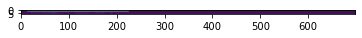

In [8]:
plt.figure()
plt.imshow(x[1].T)
i = 0
matplotlib.image.imsave("PNG/%d.png" %(i), x[i])

In [9]:
for i in range(x.shape[0]):
    if i < 323:
        matplotlib.image.imsave("PNG/healthy/%d.png" %(i), x[i])
    else:
        matplotlib.image.imsave("PNG/unhealthy/%d.png" %(i), x[i])

In [14]:
import random
random.seed(42)
num = random.sample(range(0,314), 91)
    
print(num)

[57, 12, 140, 125, 114, 71, 52, 279, 44, 302, 216, 16, 15, 47, 111, 119, 258, 13, 287, 101, 306, 214, 112, 229, 142, 3, 81, 303, 174, 289, 79, 110, 172, 307, 300, 194, 49, 183, 176, 135, 22, 235, 63, 193, 40, 150, 185, 98, 35, 23, 116, 148, 269, 298, 51, 278, 284, 232, 186, 41, 94, 90, 53, 171, 68, 179, 239, 285, 165, 18, 155, 162, 43, 136, 255, 62, 254, 118, 97, 69, 163, 275, 257, 56, 175, 83, 215, 196, 198, 14, 58]


In [15]:
train = []
test = []
train_label = []
test_label = []

for i in range(314):
    if i in num:
        train.append(x[i])
        train_label.append(y[i])
    else:
        test.append(x[i])
        test_label.append(y[i])
    
for i in range(314, x.shape[0]):
    train.append(x[i])
    train_label.append(y[i])
    
train = np.array(train).reshape(182, 5592)
test = np.array(test).reshape(223, 5592)
train_label = np.array(train_label)
test_label = np.array(test_label)

print(train_label.shape)
print(test.shape)


(182,)
(223, 5592)


In [17]:
def cal_acc(y, y_hat):
    return sum(yi == yi_hat for yi, yi_hat in zip(y, y_hat)) / len(y)

In [ ]:
classfier = KnnDtw(n_neighbors=1, max_warping_window=10)
classfier.fit(train, test)
label, proba, temp_k, temp_acc = classfier.predict(test, test_label)
print(temp_k, temp_acc)

 [                  0%                  ]
 [                  0%                  ]  2 of 40586 complete
 [                  0%                  ]  3 of 40586 complete
 [                  0%                  ]  4 of 40586 complete
 [                  0%                  ]  5 of 40586 complete
 [                  0%                  ]  6 of 40586 complete
 [                  0%                  ]  7 of 40586 complete
 [                  0%                  ]  8 of 40586 complete
 [                  0%                  ]  9 of 40586 complete
 [                  0%                  ]  10 of 40586 complete
 [                  0%                  ]  11 of 40586 complete
 [                  0%                  ]  12 of 40586 complete
 [                  0%                  ]  13 of 40586 complete
 [                  0%                  ]  14 of 40586 complete
 [                  0%                  ]  15 of 40586 complete
 [                  0%                  ]  16 of 40586 complete
 [    

 [                  0%                  ]  130 of 40586 complete
 [                  0%                  ]  131 of 40586 complete
 [                  0%                  ]  132 of 40586 complete
 [                  0%                  ]  133 of 40586 complete
 [                  0%                  ]  134 of 40586 complete
 [                  0%                  ]  135 of 40586 complete
 [                  0%                  ]  136 of 40586 complete
 [                  0%                  ]  137 of 40586 complete
 [                  0%                  ]  138 of 40586 complete
 [                  0%                  ]  139 of 40586 complete
 [                  0%                  ]  140 of 40586 complete
 [                  0%                  ]  141 of 40586 complete
 [                  0%                  ]  142 of 40586 complete
 [                  0%                  ]  143 of 40586 complete
 [                  0%                  ]  144 of 40586 complete
 [                  0%   

 [                  1%                  ]  257 of 40586 complete
 [                  1%                  ]  258 of 40586 complete
 [                  1%                  ]  259 of 40586 complete
 [                  1%                  ]  260 of 40586 complete
 [                  1%                  ]  261 of 40586 complete
 [                  1%                  ]  262 of 40586 complete
 [                  1%                  ]  263 of 40586 complete
 [                  1%                  ]  264 of 40586 complete
 [                  1%                  ]  265 of 40586 complete
 [                  1%                  ]  266 of 40586 complete
 [                  1%                  ]  267 of 40586 complete
 [                  1%                  ]  268 of 40586 complete
 [                  1%                  ]  269 of 40586 complete
 [                  1%                  ]  270 of 40586 complete
 [                  1%                  ]  271 of 40586 complete
 [                  1%   

 [                  1%                  ]  384 of 40586 complete
 [                  1%                  ]  385 of 40586 complete
 [                  1%                  ]  386 of 40586 complete
 [                  1%                  ]  387 of 40586 complete
 [                  1%                  ]  388 of 40586 complete
 [                  1%                  ]  389 of 40586 complete
 [                  1%                  ]  390 of 40586 complete
 [                  1%                  ]  391 of 40586 complete
 [                  1%                  ]  392 of 40586 complete
 [                  1%                  ]  393 of 40586 complete
 [                  1%                  ]  394 of 40586 complete
 [                  1%                  ]  395 of 40586 complete
 [                  1%                  ]  396 of 40586 complete
 [                  1%                  ]  397 of 40586 complete
 [                  1%                  ]  398 of 40586 complete
 [                  1%   

 [                  1%                  ]  511 of 40586 complete
 [                  1%                  ]  512 of 40586 complete
 [                  1%                  ]  513 of 40586 complete
 [                  1%                  ]  514 of 40586 complete
 [                  1%                  ]  515 of 40586 complete
 [                  1%                  ]  516 of 40586 complete
 [                  1%                  ]  517 of 40586 complete
 [                  1%                  ]  518 of 40586 complete
 [                  1%                  ]  519 of 40586 complete
 [                  1%                  ]  520 of 40586 complete
 [                  1%                  ]  521 of 40586 complete
 [                  1%                  ]  522 of 40586 complete
 [                  1%                  ]  523 of 40586 complete
 [                  1%                  ]  524 of 40586 complete
 [                  1%                  ]  525 of 40586 complete
 [                  1%   

 [*                 2%                  ]  638 of 40586 complete
 [*                 2%                  ]  639 of 40586 complete
 [*                 2%                  ]  640 of 40586 complete
 [*                 2%                  ]  641 of 40586 complete
 [*                 2%                  ]  642 of 40586 complete
 [*                 2%                  ]  643 of 40586 complete
 [*                 2%                  ]  644 of 40586 complete
 [*                 2%                  ]  645 of 40586 complete
 [*                 2%                  ]  646 of 40586 complete
 [*                 2%                  ]  647 of 40586 complete
 [*                 2%                  ]  648 of 40586 complete
 [*                 2%                  ]  649 of 40586 complete
 [*                 2%                  ]  650 of 40586 complete
 [*                 2%                  ]  651 of 40586 complete
 [*                 2%                  ]  652 of 40586 complete
 [*                 2%   

 [*                 2%                  ]  765 of 40586 complete
 [*                 2%                  ]  766 of 40586 complete
 [*                 2%                  ]  767 of 40586 complete
 [*                 2%                  ]  768 of 40586 complete
 [*                 2%                  ]  769 of 40586 complete
 [*                 2%                  ]  770 of 40586 complete
 [*                 2%                  ]  771 of 40586 complete
 [*                 2%                  ]  772 of 40586 complete
 [*                 2%                  ]  773 of 40586 complete
 [*                 2%                  ]  774 of 40586 complete
 [*                 2%                  ]  775 of 40586 complete
 [*                 2%                  ]  776 of 40586 complete
 [*                 2%                  ]  777 of 40586 complete
 [*                 2%                  ]  778 of 40586 complete
 [*                 2%                  ]  779 of 40586 complete
 [*                 2%   

 [*                 2%                  ]  892 of 40586 complete
 [*                 2%                  ]  893 of 40586 complete
 [*                 2%                  ]  894 of 40586 complete
 [*                 2%                  ]  895 of 40586 complete
 [*                 2%                  ]  896 of 40586 complete
 [*                 2%                  ]  897 of 40586 complete
 [*                 2%                  ]  898 of 40586 complete
 [*                 2%                  ]  899 of 40586 complete
 [*                 2%                  ]  900 of 40586 complete
 [*                 2%                  ]  901 of 40586 complete
 [*                 2%                  ]  902 of 40586 complete
 [*                 2%                  ]  903 of 40586 complete
 [*                 2%                  ]  904 of 40586 complete
 [*                 2%                  ]  905 of 40586 complete
 [*                 2%                  ]  906 of 40586 complete
 [*                 2%   

 [*                 3%                  ]  1018 of 40586 complete
 [*                 3%                  ]  1019 of 40586 complete
 [*                 3%                  ]  1020 of 40586 complete
 [*                 3%                  ]  1021 of 40586 complete
 [*                 3%                  ]  1022 of 40586 complete
 [*                 3%                  ]  1023 of 40586 complete
 [*                 3%                  ]  1024 of 40586 complete
 [*                 3%                  ]  1025 of 40586 complete
 [*                 3%                  ]  1026 of 40586 complete
 [*                 3%                  ]  1027 of 40586 complete
 [*                 3%                  ]  1028 of 40586 complete
 [*                 3%                  ]  1029 of 40586 complete
 [*                 3%                  ]  1030 of 40586 complete
 [*                 3%                  ]  1031 of 40586 complete
 [*                 3%                  ]  1032 of 40586 complete
 [*       

 [*                 3%                  ]  1143 of 40586 complete
 [*                 3%                  ]  1144 of 40586 complete
 [*                 3%                  ]  1145 of 40586 complete
 [*                 3%                  ]  1146 of 40586 complete
 [*                 3%                  ]  1147 of 40586 complete
 [*                 3%                  ]  1148 of 40586 complete
 [*                 3%                  ]  1149 of 40586 complete
 [*                 3%                  ]  1150 of 40586 complete
 [*                 3%                  ]  1151 of 40586 complete
 [*                 3%                  ]  1152 of 40586 complete
 [*                 3%                  ]  1153 of 40586 complete
 [*                 3%                  ]  1154 of 40586 complete
 [*                 3%                  ]  1155 of 40586 complete
 [*                 3%                  ]  1156 of 40586 complete
 [*                 3%                  ]  1157 of 40586 complete
 [*       

 [*                 3%                  ]  1268 of 40586 complete
 [*                 3%                  ]  1269 of 40586 complete
 [*                 3%                  ]  1270 of 40586 complete
 [*                 3%                  ]  1271 of 40586 complete
 [*                 3%                  ]  1272 of 40586 complete
 [*                 3%                  ]  1273 of 40586 complete
 [*                 3%                  ]  1274 of 40586 complete
 [*                 3%                  ]  1275 of 40586 complete
 [*                 3%                  ]  1276 of 40586 complete
 [*                 3%                  ]  1277 of 40586 complete
 [*                 3%                  ]  1278 of 40586 complete
 [*                 3%                  ]  1279 of 40586 complete
 [*                 3%                  ]  1280 of 40586 complete
 [*                 3%                  ]  1281 of 40586 complete
 [*                 3%                  ]  1282 of 40586 complete
 [*       

 [*                 3%                  ]  1393 of 40586 complete
 [*                 3%                  ]  1394 of 40586 complete
 [*                 3%                  ]  1395 of 40586 complete
 [*                 3%                  ]  1396 of 40586 complete
 [*                 3%                  ]  1397 of 40586 complete
 [*                 3%                  ]  1398 of 40586 complete
 [*                 3%                  ]  1399 of 40586 complete
 [*                 3%                  ]  1400 of 40586 complete
 [*                 3%                  ]  1401 of 40586 complete
 [*                 3%                  ]  1402 of 40586 complete
 [*                 3%                  ]  1403 of 40586 complete
 [*                 3%                  ]  1404 of 40586 complete
 [*                 3%                  ]  1405 of 40586 complete
 [*                 3%                  ]  1406 of 40586 complete
 [*                 3%                  ]  1407 of 40586 complete
 [*       

 [**                4%                  ]  1518 of 40586 complete
 [**                4%                  ]  1519 of 40586 complete
 [**                4%                  ]  1520 of 40586 complete
 [**                4%                  ]  1521 of 40586 complete
 [**                4%                  ]  1522 of 40586 complete
 [**                4%                  ]  1523 of 40586 complete
 [**                4%                  ]  1524 of 40586 complete
 [**                4%                  ]  1525 of 40586 complete
 [**                4%                  ]  1526 of 40586 complete
 [**                4%                  ]  1527 of 40586 complete
 [**                4%                  ]  1528 of 40586 complete
 [**                4%                  ]  1529 of 40586 complete
 [**                4%                  ]  1530 of 40586 complete
 [**                4%                  ]  1531 of 40586 complete
 [**                4%                  ]  1532 of 40586 complete
 [**      

 [**                4%                  ]  1643 of 40586 complete
 [**                4%                  ]  1644 of 40586 complete
 [**                4%                  ]  1645 of 40586 complete
 [**                4%                  ]  1646 of 40586 complete
 [**                4%                  ]  1647 of 40586 complete
 [**                4%                  ]  1648 of 40586 complete
 [**                4%                  ]  1649 of 40586 complete
 [**                4%                  ]  1650 of 40586 complete
 [**                4%                  ]  1651 of 40586 complete
 [**                4%                  ]  1652 of 40586 complete
 [**                4%                  ]  1653 of 40586 complete
 [**                4%                  ]  1654 of 40586 complete
 [**                4%                  ]  1655 of 40586 complete
 [**                4%                  ]  1656 of 40586 complete
 [**                4%                  ]  1657 of 40586 complete
 [**      

 [**                4%                  ]  1768 of 40586 complete
 [**                4%                  ]  1769 of 40586 complete
 [**                4%                  ]  1770 of 40586 complete
 [**                4%                  ]  1771 of 40586 complete
 [**                4%                  ]  1772 of 40586 complete
 [**                4%                  ]  1773 of 40586 complete
 [**                4%                  ]  1774 of 40586 complete
 [**                4%                  ]  1775 of 40586 complete
 [**                4%                  ]  1776 of 40586 complete
 [**                4%                  ]  1777 of 40586 complete
 [**                4%                  ]  1778 of 40586 complete
 [**                4%                  ]  1779 of 40586 complete
 [**                4%                  ]  1780 of 40586 complete
 [**                4%                  ]  1781 of 40586 complete
 [**                4%                  ]  1782 of 40586 complete
 [**      

 [**                5%                  ]  1893 of 40586 complete
 [**                5%                  ]  1894 of 40586 complete
 [**                5%                  ]  1895 of 40586 complete
 [**                5%                  ]  1896 of 40586 complete
 [**                5%                  ]  1897 of 40586 complete
 [**                5%                  ]  1898 of 40586 complete
 [**                5%                  ]  1899 of 40586 complete
 [**                5%                  ]  1900 of 40586 complete
 [**                5%                  ]  1901 of 40586 complete
 [**                5%                  ]  1902 of 40586 complete
 [**                5%                  ]  1903 of 40586 complete
 [**                5%                  ]  1904 of 40586 complete
 [**                5%                  ]  1905 of 40586 complete
 [**                5%                  ]  1906 of 40586 complete
 [**                5%                  ]  1907 of 40586 complete
 [**      

 [**                5%                  ]  2018 of 40586 complete
 [**                5%                  ]  2019 of 40586 complete
 [**                5%                  ]  2020 of 40586 complete
 [**                5%                  ]  2021 of 40586 complete
 [**                5%                  ]  2022 of 40586 complete
 [**                5%                  ]  2023 of 40586 complete
 [**                5%                  ]  2024 of 40586 complete
 [**                5%                  ]  2025 of 40586 complete
 [**                5%                  ]  2026 of 40586 complete
 [**                5%                  ]  2027 of 40586 complete
 [**                5%                  ]  2028 of 40586 complete
 [**                5%                  ]  2029 of 40586 complete
 [**                5%                  ]  2030 of 40586 complete
 [**                5%                  ]  2031 of 40586 complete
 [**                5%                  ]  2032 of 40586 complete
 [**      

 [**                5%                  ]  2143 of 40586 complete
 [**                5%                  ]  2144 of 40586 complete
 [**                5%                  ]  2145 of 40586 complete
 [**                5%                  ]  2146 of 40586 complete
 [**                5%                  ]  2147 of 40586 complete
 [**                5%                  ]  2148 of 40586 complete
 [**                5%                  ]  2149 of 40586 complete
 [**                5%                  ]  2150 of 40586 complete
 [**                5%                  ]  2151 of 40586 complete
 [**                5%                  ]  2152 of 40586 complete
 [**                5%                  ]  2153 of 40586 complete
 [**                5%                  ]  2154 of 40586 complete
 [**                5%                  ]  2155 of 40586 complete
 [**                5%                  ]  2156 of 40586 complete
 [**                5%                  ]  2157 of 40586 complete
 [**      

 [**                6%                  ]  2268 of 40586 complete
 [**                6%                  ]  2269 of 40586 complete
 [**                6%                  ]  2270 of 40586 complete
 [**                6%                  ]  2271 of 40586 complete
 [**                6%                  ]  2272 of 40586 complete
 [**                6%                  ]  2273 of 40586 complete
 [**                6%                  ]  2274 of 40586 complete
 [**                6%                  ]  2275 of 40586 complete
 [**                6%                  ]  2276 of 40586 complete
 [**                6%                  ]  2277 of 40586 complete
 [**                6%                  ]  2278 of 40586 complete
 [**                6%                  ]  2279 of 40586 complete
 [**                6%                  ]  2280 of 40586 complete
 [**                6%                  ]  2281 of 40586 complete
 [**                6%                  ]  2282 of 40586 complete
 [**      

 [**                6%                  ]  2393 of 40586 complete
 [**                6%                  ]  2394 of 40586 complete
 [**                6%                  ]  2395 of 40586 complete
 [**                6%                  ]  2396 of 40586 complete
 [**                6%                  ]  2397 of 40586 complete
 [**                6%                  ]  2398 of 40586 complete
 [**                6%                  ]  2399 of 40586 complete
 [**                6%                  ]  2400 of 40586 complete
 [**                6%                  ]  2401 of 40586 complete
 [**                6%                  ]  2402 of 40586 complete
 [**                6%                  ]  2403 of 40586 complete
 [**                6%                  ]  2404 of 40586 complete
 [**                6%                  ]  2405 of 40586 complete
 [**                6%                  ]  2406 of 40586 complete
 [**                6%                  ]  2407 of 40586 complete
 [**      

 [**                6%                  ]  2518 of 40586 complete
 [**                6%                  ]  2519 of 40586 complete
 [**                6%                  ]  2520 of 40586 complete
 [**                6%                  ]  2521 of 40586 complete
 [**                6%                  ]  2522 of 40586 complete
 [**                6%                  ]  2523 of 40586 complete
 [**                6%                  ]  2524 of 40586 complete
 [**                6%                  ]  2525 of 40586 complete
 [**                6%                  ]  2526 of 40586 complete
 [**                6%                  ]  2527 of 40586 complete
 [**                6%                  ]  2528 of 40586 complete
 [**                6%                  ]  2529 of 40586 complete
 [**                6%                  ]  2530 of 40586 complete
 [**                6%                  ]  2531 of 40586 complete
 [**                6%                  ]  2532 of 40586 complete
 [**      

 [***               7%                  ]  2643 of 40586 complete
 [***               7%                  ]  2644 of 40586 complete
 [***               7%                  ]  2645 of 40586 complete
 [***               7%                  ]  2646 of 40586 complete
 [***               7%                  ]  2647 of 40586 complete
 [***               7%                  ]  2648 of 40586 complete
 [***               7%                  ]  2649 of 40586 complete
 [***               7%                  ]  2650 of 40586 complete
 [***               7%                  ]  2651 of 40586 complete
 [***               7%                  ]  2652 of 40586 complete
 [***               7%                  ]  2653 of 40586 complete
 [***               7%                  ]  2654 of 40586 complete
 [***               7%                  ]  2655 of 40586 complete
 [***               7%                  ]  2656 of 40586 complete
 [***               7%                  ]  2657 of 40586 complete
 [***     

 [***               7%                  ]  2768 of 40586 complete
 [***               7%                  ]  2769 of 40586 complete
 [***               7%                  ]  2770 of 40586 complete
 [***               7%                  ]  2771 of 40586 complete
 [***               7%                  ]  2772 of 40586 complete
 [***               7%                  ]  2773 of 40586 complete
 [***               7%                  ]  2774 of 40586 complete
 [***               7%                  ]  2775 of 40586 complete
 [***               7%                  ]  2776 of 40586 complete
 [***               7%                  ]  2777 of 40586 complete
 [***               7%                  ]  2778 of 40586 complete
 [***               7%                  ]  2779 of 40586 complete
 [***               7%                  ]  2780 of 40586 complete
 [***               7%                  ]  2781 of 40586 complete
 [***               7%                  ]  2782 of 40586 complete
 [***     

 [***               7%                  ]  2893 of 40586 complete
 [***               7%                  ]  2894 of 40586 complete
 [***               7%                  ]  2895 of 40586 complete
 [***               7%                  ]  2896 of 40586 complete
 [***               7%                  ]  2897 of 40586 complete
 [***               7%                  ]  2898 of 40586 complete
 [***               7%                  ]  2899 of 40586 complete
 [***               7%                  ]  2900 of 40586 complete
 [***               7%                  ]  2901 of 40586 complete
 [***               7%                  ]  2902 of 40586 complete
 [***               7%                  ]  2903 of 40586 complete
 [***               7%                  ]  2904 of 40586 complete
 [***               7%                  ]  2905 of 40586 complete
 [***               7%                  ]  2906 of 40586 complete
 [***               7%                  ]  2907 of 40586 complete
 [***     

 [***               7%                  ]  3018 of 40586 complete
 [***               7%                  ]  3019 of 40586 complete
 [***               7%                  ]  3020 of 40586 complete
 [***               7%                  ]  3021 of 40586 complete
 [***               7%                  ]  3022 of 40586 complete
 [***               7%                  ]  3023 of 40586 complete
 [***               7%                  ]  3024 of 40586 complete
 [***               7%                  ]  3025 of 40586 complete
 [***               7%                  ]  3026 of 40586 complete
 [***               7%                  ]  3027 of 40586 complete
 [***               7%                  ]  3028 of 40586 complete
 [***               7%                  ]  3029 of 40586 complete
 [***               7%                  ]  3030 of 40586 complete
 [***               7%                  ]  3031 of 40586 complete
 [***               7%                  ]  3032 of 40586 complete
 [***     

 [***               8%                  ]  3143 of 40586 complete
 [***               8%                  ]  3144 of 40586 complete
 [***               8%                  ]  3145 of 40586 complete
 [***               8%                  ]  3146 of 40586 complete
 [***               8%                  ]  3147 of 40586 complete
 [***               8%                  ]  3148 of 40586 complete
 [***               8%                  ]  3149 of 40586 complete
 [***               8%                  ]  3150 of 40586 complete
 [***               8%                  ]  3151 of 40586 complete
 [***               8%                  ]  3152 of 40586 complete
 [***               8%                  ]  3153 of 40586 complete
 [***               8%                  ]  3154 of 40586 complete
 [***               8%                  ]  3155 of 40586 complete
 [***               8%                  ]  3156 of 40586 complete
 [***               8%                  ]  3157 of 40586 complete
 [***     

 [***               8%                  ]  3268 of 40586 complete
 [***               8%                  ]  3269 of 40586 complete
 [***               8%                  ]  3270 of 40586 complete
 [***               8%                  ]  3271 of 40586 complete
 [***               8%                  ]  3272 of 40586 complete
 [***               8%                  ]  3273 of 40586 complete
 [***               8%                  ]  3274 of 40586 complete
 [***               8%                  ]  3275 of 40586 complete
 [***               8%                  ]  3276 of 40586 complete
 [***               8%                  ]  3277 of 40586 complete
 [***               8%                  ]  3278 of 40586 complete
 [***               8%                  ]  3279 of 40586 complete
 [***               8%                  ]  3280 of 40586 complete
 [***               8%                  ]  3281 of 40586 complete
 [***               8%                  ]  3282 of 40586 complete
 [***     

 [***               8%                  ]  3393 of 40586 complete
 [***               8%                  ]  3394 of 40586 complete
 [***               8%                  ]  3395 of 40586 complete
 [***               8%                  ]  3396 of 40586 complete
 [***               8%                  ]  3397 of 40586 complete
 [***               8%                  ]  3398 of 40586 complete
 [***               8%                  ]  3399 of 40586 complete
 [***               8%                  ]  3400 of 40586 complete
 [***               8%                  ]  3401 of 40586 complete
 [***               8%                  ]  3402 of 40586 complete
 [***               8%                  ]  3403 of 40586 complete
 [***               8%                  ]  3404 of 40586 complete
 [***               8%                  ]  3405 of 40586 complete
 [***               8%                  ]  3406 of 40586 complete
 [***               8%                  ]  3407 of 40586 complete
 [***     

 [***               9%                  ]  3518 of 40586 complete
 [***               9%                  ]  3519 of 40586 complete
 [***               9%                  ]  3520 of 40586 complete
 [***               9%                  ]  3521 of 40586 complete
 [***               9%                  ]  3522 of 40586 complete
 [***               9%                  ]  3523 of 40586 complete
 [***               9%                  ]  3524 of 40586 complete
 [***               9%                  ]  3525 of 40586 complete
 [***               9%                  ]  3526 of 40586 complete
 [***               9%                  ]  3527 of 40586 complete
 [***               9%                  ]  3528 of 40586 complete
 [***               9%                  ]  3529 of 40586 complete
 [***               9%                  ]  3530 of 40586 complete
 [***               9%                  ]  3531 of 40586 complete
 [***               9%                  ]  3532 of 40586 complete
 [***     

 [***               9%                  ]  3643 of 40586 complete
 [***               9%                  ]  3644 of 40586 complete
 [***               9%                  ]  3645 of 40586 complete
 [***               9%                  ]  3646 of 40586 complete
 [***               9%                  ]  3647 of 40586 complete
 [***               9%                  ]  3648 of 40586 complete
 [***               9%                  ]  3649 of 40586 complete
 [***               9%                  ]  3650 of 40586 complete
 [***               9%                  ]  3651 of 40586 complete
 [***               9%                  ]  3652 of 40586 complete
 [***               9%                  ]  3653 of 40586 complete
 [***               9%                  ]  3654 of 40586 complete
 [***               9%                  ]  3655 of 40586 complete
 [***               9%                  ]  3656 of 40586 complete
 [***               9%                  ]  3657 of 40586 complete
 [***     

 [***               9%                  ]  3768 of 40586 complete
 [***               9%                  ]  3769 of 40586 complete
 [***               9%                  ]  3770 of 40586 complete
 [***               9%                  ]  3771 of 40586 complete
 [***               9%                  ]  3772 of 40586 complete
 [***               9%                  ]  3773 of 40586 complete
 [***               9%                  ]  3774 of 40586 complete
 [***               9%                  ]  3775 of 40586 complete
 [***               9%                  ]  3776 of 40586 complete
 [***               9%                  ]  3777 of 40586 complete
 [***               9%                  ]  3778 of 40586 complete
 [***               9%                  ]  3779 of 40586 complete
 [***               9%                  ]  3780 of 40586 complete
 [***               9%                  ]  3781 of 40586 complete
 [***               9%                  ]  3782 of 40586 complete
 [***     

 [****             10%                  ]  3893 of 40586 complete
 [****             10%                  ]  3894 of 40586 complete
 [****             10%                  ]  3895 of 40586 complete
 [****             10%                  ]  3896 of 40586 complete
 [****             10%                  ]  3897 of 40586 complete
 [****             10%                  ]  3898 of 40586 complete
 [****             10%                  ]  3899 of 40586 complete
 [****             10%                  ]  3900 of 40586 complete
 [****             10%                  ]  3901 of 40586 complete
 [****             10%                  ]  3902 of 40586 complete
 [****             10%                  ]  3903 of 40586 complete
 [****             10%                  ]  3904 of 40586 complete
 [****             10%                  ]  3905 of 40586 complete
 [****             10%                  ]  3906 of 40586 complete
 [****             10%                  ]  3907 of 40586 complete
 [****    

 [****             10%                  ]  4018 of 40586 complete
 [****             10%                  ]  4019 of 40586 complete
 [****             10%                  ]  4020 of 40586 complete
 [****             10%                  ]  4021 of 40586 complete
 [****             10%                  ]  4022 of 40586 complete
 [****             10%                  ]  4023 of 40586 complete
 [****             10%                  ]  4024 of 40586 complete
 [****             10%                  ]  4025 of 40586 complete
 [****             10%                  ]  4026 of 40586 complete
 [****             10%                  ]  4027 of 40586 complete
 [****             10%                  ]  4028 of 40586 complete
 [****             10%                  ]  4029 of 40586 complete
 [****             10%                  ]  4030 of 40586 complete
 [****             10%                  ]  4031 of 40586 complete
 [****             10%                  ]  4032 of 40586 complete
 [****    

 [****             10%                  ]  4143 of 40586 complete
 [****             10%                  ]  4144 of 40586 complete
 [****             10%                  ]  4145 of 40586 complete
 [****             10%                  ]  4146 of 40586 complete
 [****             10%                  ]  4147 of 40586 complete
 [****             10%                  ]  4148 of 40586 complete
 [****             10%                  ]  4149 of 40586 complete
 [****             10%                  ]  4150 of 40586 complete
 [****             10%                  ]  4151 of 40586 complete
 [****             10%                  ]  4152 of 40586 complete
 [****             10%                  ]  4153 of 40586 complete
 [****             10%                  ]  4154 of 40586 complete
 [****             10%                  ]  4155 of 40586 complete
 [****             10%                  ]  4156 of 40586 complete
 [****             10%                  ]  4157 of 40586 complete
 [****    

 [****             11%                  ]  4268 of 40586 complete
 [****             11%                  ]  4269 of 40586 complete
 [****             11%                  ]  4270 of 40586 complete
 [****             11%                  ]  4271 of 40586 complete
 [****             11%                  ]  4272 of 40586 complete
 [****             11%                  ]  4273 of 40586 complete
 [****             11%                  ]  4274 of 40586 complete
 [****             11%                  ]  4275 of 40586 complete
 [****             11%                  ]  4276 of 40586 complete
 [****             11%                  ]  4277 of 40586 complete
 [****             11%                  ]  4278 of 40586 complete
 [****             11%                  ]  4279 of 40586 complete
 [****             11%                  ]  4280 of 40586 complete
 [****             11%                  ]  4281 of 40586 complete
 [****             11%                  ]  4282 of 40586 complete
 [****    

 [****             11%                  ]  4393 of 40586 complete
 [****             11%                  ]  4394 of 40586 complete
 [****             11%                  ]  4395 of 40586 complete
 [****             11%                  ]  4396 of 40586 complete
 [****             11%                  ]  4397 of 40586 complete
 [****             11%                  ]  4398 of 40586 complete
 [****             11%                  ]  4399 of 40586 complete
 [****             11%                  ]  4400 of 40586 complete
 [****             11%                  ]  4401 of 40586 complete
 [****             11%                  ]  4402 of 40586 complete
 [****             11%                  ]  4403 of 40586 complete
 [****             11%                  ]  4404 of 40586 complete
 [****             11%                  ]  4405 of 40586 complete
 [****             11%                  ]  4406 of 40586 complete
 [****             11%                  ]  4407 of 40586 complete
 [****    

 [****             11%                  ]  4518 of 40586 complete
 [****             11%                  ]  4519 of 40586 complete
 [****             11%                  ]  4520 of 40586 complete
 [****             11%                  ]  4521 of 40586 complete
 [****             11%                  ]  4522 of 40586 complete
 [****             11%                  ]  4523 of 40586 complete
 [****             11%                  ]  4524 of 40586 complete
 [****             11%                  ]  4525 of 40586 complete
 [****             11%                  ]  4526 of 40586 complete
 [****             11%                  ]  4527 of 40586 complete
 [****             11%                  ]  4528 of 40586 complete
 [****             11%                  ]  4529 of 40586 complete
 [****             11%                  ]  4530 of 40586 complete
 [****             11%                  ]  4531 of 40586 complete
 [****             11%                  ]  4532 of 40586 complete
 [****    

 [****             11%                  ]  4643 of 40586 complete
 [****             11%                  ]  4644 of 40586 complete
 [****             11%                  ]  4645 of 40586 complete
 [****             11%                  ]  4646 of 40586 complete
 [****             11%                  ]  4647 of 40586 complete
 [****             11%                  ]  4648 of 40586 complete
 [****             11%                  ]  4649 of 40586 complete
 [****             11%                  ]  4650 of 40586 complete
 [****             11%                  ]  4651 of 40586 complete
 [****             11%                  ]  4652 of 40586 complete
 [****             11%                  ]  4653 of 40586 complete
 [****             11%                  ]  4654 of 40586 complete
 [****             11%                  ]  4655 of 40586 complete
 [****             11%                  ]  4656 of 40586 complete
 [****             11%                  ]  4657 of 40586 complete
 [****    

 [*****            12%                  ]  4768 of 40586 complete
 [*****            12%                  ]  4769 of 40586 complete
 [*****            12%                  ]  4770 of 40586 complete
 [*****            12%                  ]  4771 of 40586 complete
 [*****            12%                  ]  4772 of 40586 complete
 [*****            12%                  ]  4773 of 40586 complete
 [*****            12%                  ]  4774 of 40586 complete
 [*****            12%                  ]  4775 of 40586 complete
 [*****            12%                  ]  4776 of 40586 complete
 [*****            12%                  ]  4777 of 40586 complete
 [*****            12%                  ]  4778 of 40586 complete
 [*****            12%                  ]  4779 of 40586 complete
 [*****            12%                  ]  4780 of 40586 complete
 [*****            12%                  ]  4781 of 40586 complete
 [*****            12%                  ]  4782 of 40586 complete
 [*****   

 [*****            12%                  ]  4893 of 40586 complete
 [*****            12%                  ]  4894 of 40586 complete
 [*****            12%                  ]  4895 of 40586 complete
 [*****            12%                  ]  4896 of 40586 complete
 [*****            12%                  ]  4897 of 40586 complete
 [*****            12%                  ]  4898 of 40586 complete
 [*****            12%                  ]  4899 of 40586 complete
 [*****            12%                  ]  4900 of 40586 complete
 [*****            12%                  ]  4901 of 40586 complete
 [*****            12%                  ]  4902 of 40586 complete
 [*****            12%                  ]  4903 of 40586 complete
 [*****            12%                  ]  4904 of 40586 complete
 [*****            12%                  ]  4905 of 40586 complete
 [*****            12%                  ]  4906 of 40586 complete
 [*****            12%                  ]  4907 of 40586 complete
 [*****   

 [*****            12%                  ]  5018 of 40586 complete
 [*****            12%                  ]  5019 of 40586 complete
 [*****            12%                  ]  5020 of 40586 complete
 [*****            12%                  ]  5021 of 40586 complete
 [*****            12%                  ]  5022 of 40586 complete
 [*****            12%                  ]  5023 of 40586 complete
 [*****            12%                  ]  5024 of 40586 complete
 [*****            12%                  ]  5025 of 40586 complete
 [*****            12%                  ]  5026 of 40586 complete
 [*****            12%                  ]  5027 of 40586 complete
 [*****            12%                  ]  5028 of 40586 complete
 [*****            12%                  ]  5029 of 40586 complete
 [*****            12%                  ]  5030 of 40586 complete
 [*****            12%                  ]  5031 of 40586 complete
 [*****            12%                  ]  5032 of 40586 complete
 [*****   

 [*****            13%                  ]  5143 of 40586 complete
 [*****            13%                  ]  5144 of 40586 complete
 [*****            13%                  ]  5145 of 40586 complete
 [*****            13%                  ]  5146 of 40586 complete
 [*****            13%                  ]  5147 of 40586 complete
 [*****            13%                  ]  5148 of 40586 complete
 [*****            13%                  ]  5149 of 40586 complete
 [*****            13%                  ]  5150 of 40586 complete
 [*****            13%                  ]  5151 of 40586 complete
 [*****            13%                  ]  5152 of 40586 complete
 [*****            13%                  ]  5153 of 40586 complete
 [*****            13%                  ]  5154 of 40586 complete
 [*****            13%                  ]  5155 of 40586 complete
 [*****            13%                  ]  5156 of 40586 complete
 [*****            13%                  ]  5157 of 40586 complete
 [*****   

 [*****            13%                  ]  5268 of 40586 complete
 [*****            13%                  ]  5269 of 40586 complete
 [*****            13%                  ]  5270 of 40586 complete
 [*****            13%                  ]  5271 of 40586 complete
 [*****            13%                  ]  5272 of 40586 complete
 [*****            13%                  ]  5273 of 40586 complete
 [*****            13%                  ]  5274 of 40586 complete
 [*****            13%                  ]  5275 of 40586 complete
 [*****            13%                  ]  5276 of 40586 complete
 [*****            13%                  ]  5277 of 40586 complete
 [*****            13%                  ]  5278 of 40586 complete
 [*****            13%                  ]  5279 of 40586 complete
 [*****            13%                  ]  5280 of 40586 complete
 [*****            13%                  ]  5281 of 40586 complete
 [*****            13%                  ]  5282 of 40586 complete
 [*****   

 [*****            13%                  ]  5393 of 40586 complete
 [*****            13%                  ]  5394 of 40586 complete
 [*****            13%                  ]  5395 of 40586 complete
 [*****            13%                  ]  5396 of 40586 complete
 [*****            13%                  ]  5397 of 40586 complete
 [*****            13%                  ]  5398 of 40586 complete
 [*****            13%                  ]  5399 of 40586 complete
 [*****            13%                  ]  5400 of 40586 complete
 [*****            13%                  ]  5401 of 40586 complete
 [*****            13%                  ]  5402 of 40586 complete
 [*****            13%                  ]  5403 of 40586 complete
 [*****            13%                  ]  5404 of 40586 complete
 [*****            13%                  ]  5405 of 40586 complete
 [*****            13%                  ]  5406 of 40586 complete
 [*****            13%                  ]  5407 of 40586 complete
 [*****   

 [*****            14%                  ]  5518 of 40586 complete
 [*****            14%                  ]  5519 of 40586 complete
 [*****            14%                  ]  5520 of 40586 complete
 [*****            14%                  ]  5521 of 40586 complete
 [*****            14%                  ]  5522 of 40586 complete
 [*****            14%                  ]  5523 of 40586 complete
 [*****            14%                  ]  5524 of 40586 complete
 [*****            14%                  ]  5525 of 40586 complete
 [*****            14%                  ]  5526 of 40586 complete
 [*****            14%                  ]  5527 of 40586 complete
 [*****            14%                  ]  5528 of 40586 complete
 [*****            14%                  ]  5529 of 40586 complete
 [*****            14%                  ]  5530 of 40586 complete
 [*****            14%                  ]  5531 of 40586 complete
 [*****            14%                  ]  5532 of 40586 complete
 [*****   

 [*****            14%                  ]  5643 of 40586 complete
 [*****            14%                  ]  5644 of 40586 complete
 [*****            14%                  ]  5645 of 40586 complete
 [*****            14%                  ]  5646 of 40586 complete
 [*****            14%                  ]  5647 of 40586 complete
 [*****            14%                  ]  5648 of 40586 complete
 [*****            14%                  ]  5649 of 40586 complete
 [*****            14%                  ]  5650 of 40586 complete
 [*****            14%                  ]  5651 of 40586 complete
 [*****            14%                  ]  5652 of 40586 complete
 [*****            14%                  ]  5653 of 40586 complete
 [*****            14%                  ]  5654 of 40586 complete
 [*****            14%                  ]  5655 of 40586 complete
 [*****            14%                  ]  5656 of 40586 complete
 [*****            14%                  ]  5657 of 40586 complete
 [*****   

 [*****            14%                  ]  5768 of 40586 complete
 [*****            14%                  ]  5769 of 40586 complete
 [*****            14%                  ]  5770 of 40586 complete
 [*****            14%                  ]  5771 of 40586 complete
 [*****            14%                  ]  5772 of 40586 complete
 [*****            14%                  ]  5773 of 40586 complete
 [*****            14%                  ]  5774 of 40586 complete
 [*****            14%                  ]  5775 of 40586 complete
 [*****            14%                  ]  5776 of 40586 complete
 [*****            14%                  ]  5777 of 40586 complete
 [*****            14%                  ]  5778 of 40586 complete
 [*****            14%                  ]  5779 of 40586 complete
 [*****            14%                  ]  5780 of 40586 complete
 [*****            14%                  ]  5781 of 40586 complete
 [*****            14%                  ]  5782 of 40586 complete
 [*****   

 [******           15%                  ]  5893 of 40586 complete
 [******           15%                  ]  5894 of 40586 complete
 [******           15%                  ]  5895 of 40586 complete
 [******           15%                  ]  5896 of 40586 complete
 [******           15%                  ]  5897 of 40586 complete
 [******           15%                  ]  5898 of 40586 complete
 [******           15%                  ]  5899 of 40586 complete
 [******           15%                  ]  5900 of 40586 complete
 [******           15%                  ]  5901 of 40586 complete
 [******           15%                  ]  5902 of 40586 complete
 [******           15%                  ]  5903 of 40586 complete
 [******           15%                  ]  5904 of 40586 complete
 [******           15%                  ]  5905 of 40586 complete
 [******           15%                  ]  5906 of 40586 complete
 [******           15%                  ]  5907 of 40586 complete
 [******  

 [******           15%                  ]  6018 of 40586 complete
 [******           15%                  ]  6019 of 40586 complete
 [******           15%                  ]  6020 of 40586 complete
 [******           15%                  ]  6021 of 40586 complete
 [******           15%                  ]  6022 of 40586 complete
 [******           15%                  ]  6023 of 40586 complete
 [******           15%                  ]  6024 of 40586 complete
 [******           15%                  ]  6025 of 40586 complete
 [******           15%                  ]  6026 of 40586 complete
 [******           15%                  ]  6027 of 40586 complete
 [******           15%                  ]  6028 of 40586 complete
 [******           15%                  ]  6029 of 40586 complete
 [******           15%                  ]  6030 of 40586 complete
 [******           15%                  ]  6031 of 40586 complete
 [******           15%                  ]  6032 of 40586 complete
 [******  

 [******           15%                  ]  6143 of 40586 complete
 [******           15%                  ]  6144 of 40586 complete
 [******           15%                  ]  6145 of 40586 complete
 [******           15%                  ]  6146 of 40586 complete
 [******           15%                  ]  6147 of 40586 complete
 [******           15%                  ]  6148 of 40586 complete
 [******           15%                  ]  6149 of 40586 complete
 [******           15%                  ]  6150 of 40586 complete
 [******           15%                  ]  6151 of 40586 complete
 [******           15%                  ]  6152 of 40586 complete
 [******           15%                  ]  6153 of 40586 complete
 [******           15%                  ]  6154 of 40586 complete
 [******           15%                  ]  6155 of 40586 complete
 [******           15%                  ]  6156 of 40586 complete
 [******           15%                  ]  6157 of 40586 complete
 [******  

 [******           15%                  ]  6268 of 40586 complete
 [******           15%                  ]  6269 of 40586 complete
 [******           15%                  ]  6270 of 40586 complete
 [******           15%                  ]  6271 of 40586 complete
 [******           15%                  ]  6272 of 40586 complete
 [******           15%                  ]  6273 of 40586 complete
 [******           15%                  ]  6274 of 40586 complete
 [******           15%                  ]  6275 of 40586 complete
 [******           15%                  ]  6276 of 40586 complete
 [******           15%                  ]  6277 of 40586 complete
 [******           15%                  ]  6278 of 40586 complete
 [******           15%                  ]  6279 of 40586 complete
 [******           15%                  ]  6280 of 40586 complete
 [******           15%                  ]  6281 of 40586 complete
 [******           15%                  ]  6282 of 40586 complete
 [******  

 [******           16%                  ]  6393 of 40586 complete
 [******           16%                  ]  6394 of 40586 complete
 [******           16%                  ]  6395 of 40586 complete
 [******           16%                  ]  6396 of 40586 complete
 [******           16%                  ]  6397 of 40586 complete
 [******           16%                  ]  6398 of 40586 complete
 [******           16%                  ]  6399 of 40586 complete
 [******           16%                  ]  6400 of 40586 complete
 [******           16%                  ]  6401 of 40586 complete
 [******           16%                  ]  6402 of 40586 complete
 [******           16%                  ]  6403 of 40586 complete
 [******           16%                  ]  6404 of 40586 complete
 [******           16%                  ]  6405 of 40586 complete
 [******           16%                  ]  6406 of 40586 complete
 [******           16%                  ]  6407 of 40586 complete
 [******  

 [******           16%                  ]  6518 of 40586 complete
 [******           16%                  ]  6519 of 40586 complete
 [******           16%                  ]  6520 of 40586 complete
 [******           16%                  ]  6521 of 40586 complete
 [******           16%                  ]  6522 of 40586 complete
 [******           16%                  ]  6523 of 40586 complete
 [******           16%                  ]  6524 of 40586 complete
 [******           16%                  ]  6525 of 40586 complete
 [******           16%                  ]  6526 of 40586 complete
 [******           16%                  ]  6527 of 40586 complete
 [******           16%                  ]  6528 of 40586 complete
 [******           16%                  ]  6529 of 40586 complete
 [******           16%                  ]  6530 of 40586 complete
 [******           16%                  ]  6531 of 40586 complete
 [******           16%                  ]  6532 of 40586 complete
 [******  

 [******           16%                  ]  6643 of 40586 complete
 [******           16%                  ]  6644 of 40586 complete
 [******           16%                  ]  6645 of 40586 complete
 [******           16%                  ]  6646 of 40586 complete
 [******           16%                  ]  6647 of 40586 complete
 [******           16%                  ]  6648 of 40586 complete
 [******           16%                  ]  6649 of 40586 complete
 [******           16%                  ]  6650 of 40586 complete
 [******           16%                  ]  6651 of 40586 complete
 [******           16%                  ]  6652 of 40586 complete
 [******           16%                  ]  6653 of 40586 complete
 [******           16%                  ]  6654 of 40586 complete
 [******           16%                  ]  6655 of 40586 complete
 [******           16%                  ]  6656 of 40586 complete
 [******           16%                  ]  6657 of 40586 complete
 [******  

 [******           17%                  ]  6768 of 40586 complete
 [******           17%                  ]  6769 of 40586 complete
 [******           17%                  ]  6770 of 40586 complete
 [******           17%                  ]  6771 of 40586 complete
 [******           17%                  ]  6772 of 40586 complete
 [******           17%                  ]  6773 of 40586 complete
 [******           17%                  ]  6774 of 40586 complete
 [******           17%                  ]  6775 of 40586 complete
 [******           17%                  ]  6776 of 40586 complete
 [******           17%                  ]  6777 of 40586 complete
 [******           17%                  ]  6778 of 40586 complete
 [******           17%                  ]  6779 of 40586 complete
 [******           17%                  ]  6780 of 40586 complete
 [******           17%                  ]  6781 of 40586 complete
 [******           17%                  ]  6782 of 40586 complete
 [******  

 [******           17%                  ]  6893 of 40586 complete
 [******           17%                  ]  6894 of 40586 complete
 [******           17%                  ]  6895 of 40586 complete
 [******           17%                  ]  6896 of 40586 complete
 [******           17%                  ]  6897 of 40586 complete
 [******           17%                  ]  6898 of 40586 complete
 [******           17%                  ]  6899 of 40586 complete
 [******           17%                  ]  6900 of 40586 complete
 [******           17%                  ]  6901 of 40586 complete
 [******           17%                  ]  6902 of 40586 complete
 [******           17%                  ]  6903 of 40586 complete
 [******           17%                  ]  6904 of 40586 complete
 [******           17%                  ]  6905 of 40586 complete
 [******           17%                  ]  6906 of 40586 complete
 [******           17%                  ]  6907 of 40586 complete
 [******  

 [******           17%                  ]  7018 of 40586 complete
 [******           17%                  ]  7019 of 40586 complete
 [******           17%                  ]  7020 of 40586 complete
 [******           17%                  ]  7021 of 40586 complete
 [******           17%                  ]  7022 of 40586 complete
 [******           17%                  ]  7023 of 40586 complete
 [******           17%                  ]  7024 of 40586 complete
 [******           17%                  ]  7025 of 40586 complete
 [******           17%                  ]  7026 of 40586 complete
 [******           17%                  ]  7027 of 40586 complete
 [******           17%                  ]  7028 of 40586 complete
 [******           17%                  ]  7029 of 40586 complete
 [******           17%                  ]  7030 of 40586 complete
 [******           17%                  ]  7031 of 40586 complete
 [******           17%                  ]  7032 of 40586 complete
 [******  

 [*******          18%                  ]  7143 of 40586 complete
 [*******          18%                  ]  7144 of 40586 complete
 [*******          18%                  ]  7145 of 40586 complete
 [*******          18%                  ]  7146 of 40586 complete
 [*******          18%                  ]  7147 of 40586 complete
 [*******          18%                  ]  7148 of 40586 complete
 [*******          18%                  ]  7149 of 40586 complete
 [*******          18%                  ]  7150 of 40586 complete
 [*******          18%                  ]  7151 of 40586 complete
 [*******          18%                  ]  7152 of 40586 complete
 [*******          18%                  ]  7153 of 40586 complete
 [*******          18%                  ]  7154 of 40586 complete
 [*******          18%                  ]  7155 of 40586 complete
 [*******          18%                  ]  7156 of 40586 complete
 [*******          18%                  ]  7157 of 40586 complete
 [******* 

 [*******          18%                  ]  7268 of 40586 complete
 [*******          18%                  ]  7269 of 40586 complete
 [*******          18%                  ]  7270 of 40586 complete
 [*******          18%                  ]  7271 of 40586 complete
 [*******          18%                  ]  7272 of 40586 complete
 [*******          18%                  ]  7273 of 40586 complete
 [*******          18%                  ]  7274 of 40586 complete
 [*******          18%                  ]  7275 of 40586 complete
 [*******          18%                  ]  7276 of 40586 complete
 [*******          18%                  ]  7277 of 40586 complete
 [*******          18%                  ]  7278 of 40586 complete
 [*******          18%                  ]  7279 of 40586 complete
 [*******          18%                  ]  7280 of 40586 complete
 [*******          18%                  ]  7281 of 40586 complete
 [*******          18%                  ]  7282 of 40586 complete
 [******* 

 [*******          18%                  ]  7393 of 40586 complete
 [*******          18%                  ]  7394 of 40586 complete
 [*******          18%                  ]  7395 of 40586 complete
 [*******          18%                  ]  7396 of 40586 complete
 [*******          18%                  ]  7397 of 40586 complete
 [*******          18%                  ]  7398 of 40586 complete
 [*******          18%                  ]  7399 of 40586 complete
 [*******          18%                  ]  7400 of 40586 complete
 [*******          18%                  ]  7401 of 40586 complete
 [*******          18%                  ]  7402 of 40586 complete
 [*******          18%                  ]  7403 of 40586 complete
 [*******          18%                  ]  7404 of 40586 complete
 [*******          18%                  ]  7405 of 40586 complete
 [*******          18%                  ]  7406 of 40586 complete
 [*******          18%                  ]  7407 of 40586 complete
 [******* 

 [*******          19%                  ]  7518 of 40586 complete
 [*******          19%                  ]  7519 of 40586 complete
 [*******          19%                  ]  7520 of 40586 complete
 [*******          19%                  ]  7521 of 40586 complete
 [*******          19%                  ]  7522 of 40586 complete
 [*******          19%                  ]  7523 of 40586 complete
 [*******          19%                  ]  7524 of 40586 complete
 [*******          19%                  ]  7525 of 40586 complete
 [*******          19%                  ]  7526 of 40586 complete
 [*******          19%                  ]  7527 of 40586 complete
 [*******          19%                  ]  7528 of 40586 complete
 [*******          19%                  ]  7529 of 40586 complete
 [*******          19%                  ]  7530 of 40586 complete
 [*******          19%                  ]  7531 of 40586 complete
 [*******          19%                  ]  7532 of 40586 complete
 [******* 

 [*******          19%                  ]  7643 of 40586 complete
 [*******          19%                  ]  7644 of 40586 complete
 [*******          19%                  ]  7645 of 40586 complete
 [*******          19%                  ]  7646 of 40586 complete
 [*******          19%                  ]  7647 of 40586 complete
 [*******          19%                  ]  7648 of 40586 complete
 [*******          19%                  ]  7649 of 40586 complete
 [*******          19%                  ]  7650 of 40586 complete
 [*******          19%                  ]  7651 of 40586 complete
 [*******          19%                  ]  7652 of 40586 complete
 [*******          19%                  ]  7653 of 40586 complete
 [*******          19%                  ]  7654 of 40586 complete
 [*******          19%                  ]  7655 of 40586 complete
 [*******          19%                  ]  7656 of 40586 complete
 [*******          19%                  ]  7657 of 40586 complete
 [******* 

 [*******          19%                  ]  7768 of 40586 complete
 [*******          19%                  ]  7769 of 40586 complete
 [*******          19%                  ]  7770 of 40586 complete
 [*******          19%                  ]  7771 of 40586 complete
 [*******          19%                  ]  7772 of 40586 complete
 [*******          19%                  ]  7773 of 40586 complete
 [*******          19%                  ]  7774 of 40586 complete
 [*******          19%                  ]  7775 of 40586 complete
 [*******          19%                  ]  7776 of 40586 complete
 [*******          19%                  ]  7777 of 40586 complete
 [*******          19%                  ]  7778 of 40586 complete
 [*******          19%                  ]  7779 of 40586 complete
 [*******          19%                  ]  7780 of 40586 complete
 [*******          19%                  ]  7781 of 40586 complete
 [*******          19%                  ]  7782 of 40586 complete
 [******* 

 [*******          19%                  ]  7893 of 40586 complete
 [*******          19%                  ]  7894 of 40586 complete
 [*******          19%                  ]  7895 of 40586 complete
 [*******          19%                  ]  7896 of 40586 complete
 [*******          19%                  ]  7897 of 40586 complete
 [*******          19%                  ]  7898 of 40586 complete
 [*******          19%                  ]  7899 of 40586 complete
 [*******          19%                  ]  7900 of 40586 complete
 [*******          19%                  ]  7901 of 40586 complete
 [*******          19%                  ]  7902 of 40586 complete
 [*******          19%                  ]  7903 of 40586 complete
 [*******          19%                  ]  7904 of 40586 complete
 [*******          19%                  ]  7905 of 40586 complete
 [*******          19%                  ]  7906 of 40586 complete
 [*******          19%                  ]  7907 of 40586 complete
 [******* 

 [********         20%                  ]  8018 of 40586 complete
 [********         20%                  ]  8019 of 40586 complete
 [********         20%                  ]  8020 of 40586 complete
 [********         20%                  ]  8021 of 40586 complete
 [********         20%                  ]  8022 of 40586 complete
 [********         20%                  ]  8023 of 40586 complete
 [********         20%                  ]  8024 of 40586 complete
 [********         20%                  ]  8025 of 40586 complete
 [********         20%                  ]  8026 of 40586 complete
 [********         20%                  ]  8027 of 40586 complete
 [********         20%                  ]  8028 of 40586 complete
 [********         20%                  ]  8029 of 40586 complete
 [********         20%                  ]  8030 of 40586 complete
 [********         20%                  ]  8031 of 40586 complete
 [********         20%                  ]  8032 of 40586 complete
 [********

 [********         20%                  ]  8143 of 40586 complete
 [********         20%                  ]  8144 of 40586 complete
 [********         20%                  ]  8145 of 40586 complete
 [********         20%                  ]  8146 of 40586 complete
 [********         20%                  ]  8147 of 40586 complete
 [********         20%                  ]  8148 of 40586 complete
 [********         20%                  ]  8149 of 40586 complete
 [********         20%                  ]  8150 of 40586 complete
 [********         20%                  ]  8151 of 40586 complete
 [********         20%                  ]  8152 of 40586 complete
 [********         20%                  ]  8153 of 40586 complete
 [********         20%                  ]  8154 of 40586 complete
 [********         20%                  ]  8155 of 40586 complete
 [********         20%                  ]  8156 of 40586 complete
 [********         20%                  ]  8157 of 40586 complete
 [********

 [********         20%                  ]  8268 of 40586 complete
 [********         20%                  ]  8269 of 40586 complete
 [********         20%                  ]  8270 of 40586 complete
 [********         20%                  ]  8271 of 40586 complete
 [********         20%                  ]  8272 of 40586 complete
 [********         20%                  ]  8273 of 40586 complete
 [********         20%                  ]  8274 of 40586 complete
 [********         20%                  ]  8275 of 40586 complete
 [********         20%                  ]  8276 of 40586 complete
 [********         20%                  ]  8277 of 40586 complete
 [********         20%                  ]  8278 of 40586 complete
 [********         20%                  ]  8279 of 40586 complete
 [********         20%                  ]  8280 of 40586 complete
 [********         20%                  ]  8281 of 40586 complete
 [********         20%                  ]  8282 of 40586 complete
 [********

 [********         21%                  ]  8393 of 40586 complete
 [********         21%                  ]  8394 of 40586 complete
 [********         21%                  ]  8395 of 40586 complete
 [********         21%                  ]  8396 of 40586 complete
 [********         21%                  ]  8397 of 40586 complete
 [********         21%                  ]  8398 of 40586 complete
 [********         21%                  ]  8399 of 40586 complete
 [********         21%                  ]  8400 of 40586 complete
 [********         21%                  ]  8401 of 40586 complete
 [********         21%                  ]  8402 of 40586 complete
 [********         21%                  ]  8403 of 40586 complete
 [********         21%                  ]  8404 of 40586 complete
 [********         21%                  ]  8405 of 40586 complete
 [********         21%                  ]  8406 of 40586 complete
 [********         21%                  ]  8407 of 40586 complete
 [********

 [********         21%                  ]  8518 of 40586 complete
 [********         21%                  ]  8519 of 40586 complete
 [********         21%                  ]  8520 of 40586 complete
 [********         21%                  ]  8521 of 40586 complete
 [********         21%                  ]  8522 of 40586 complete
 [********         21%                  ]  8523 of 40586 complete
 [********         21%                  ]  8524 of 40586 complete
 [********         21%                  ]  8525 of 40586 complete
 [********         21%                  ]  8526 of 40586 complete
 [********         21%                  ]  8527 of 40586 complete
 [********         21%                  ]  8528 of 40586 complete
 [********         21%                  ]  8529 of 40586 complete
 [********         21%                  ]  8530 of 40586 complete
 [********         21%                  ]  8531 of 40586 complete
 [********         21%                  ]  8532 of 40586 complete
 [********

 [********         21%                  ]  8643 of 40586 complete
 [********         21%                  ]  8644 of 40586 complete
 [********         21%                  ]  8645 of 40586 complete
 [********         21%                  ]  8646 of 40586 complete
 [********         21%                  ]  8647 of 40586 complete
 [********         21%                  ]  8648 of 40586 complete
 [********         21%                  ]  8649 of 40586 complete
 [********         21%                  ]  8650 of 40586 complete
 [********         21%                  ]  8651 of 40586 complete
 [********         21%                  ]  8652 of 40586 complete
 [********         21%                  ]  8653 of 40586 complete
 [********         21%                  ]  8654 of 40586 complete
 [********         21%                  ]  8655 of 40586 complete
 [********         21%                  ]  8656 of 40586 complete
 [********         21%                  ]  8657 of 40586 complete
 [********

 [********         22%                  ]  8768 of 40586 complete
 [********         22%                  ]  8769 of 40586 complete
 [********         22%                  ]  8770 of 40586 complete
 [********         22%                  ]  8771 of 40586 complete
 [********         22%                  ]  8772 of 40586 complete
 [********         22%                  ]  8773 of 40586 complete
 [********         22%                  ]  8774 of 40586 complete
 [********         22%                  ]  8775 of 40586 complete
 [********         22%                  ]  8776 of 40586 complete
 [********         22%                  ]  8777 of 40586 complete
 [********         22%                  ]  8778 of 40586 complete
 [********         22%                  ]  8779 of 40586 complete
 [********         22%                  ]  8780 of 40586 complete
 [********         22%                  ]  8781 of 40586 complete
 [********         22%                  ]  8782 of 40586 complete
 [********

 [********         22%                  ]  8893 of 40586 complete
 [********         22%                  ]  8894 of 40586 complete
 [********         22%                  ]  8895 of 40586 complete
 [********         22%                  ]  8896 of 40586 complete
 [********         22%                  ]  8897 of 40586 complete
 [********         22%                  ]  8898 of 40586 complete
 [********         22%                  ]  8899 of 40586 complete
 [********         22%                  ]  8900 of 40586 complete
 [********         22%                  ]  8901 of 40586 complete
 [********         22%                  ]  8902 of 40586 complete
 [********         22%                  ]  8903 of 40586 complete
 [********         22%                  ]  8904 of 40586 complete
 [********         22%                  ]  8905 of 40586 complete
 [********         22%                  ]  8906 of 40586 complete
 [********         22%                  ]  8907 of 40586 complete
 [********

 [********         22%                  ]  9018 of 40586 complete
 [********         22%                  ]  9019 of 40586 complete
 [********         22%                  ]  9020 of 40586 complete
 [********         22%                  ]  9021 of 40586 complete
 [********         22%                  ]  9022 of 40586 complete
 [********         22%                  ]  9023 of 40586 complete
 [********         22%                  ]  9024 of 40586 complete
 [********         22%                  ]  9025 of 40586 complete
 [********         22%                  ]  9026 of 40586 complete
 [********         22%                  ]  9027 of 40586 complete
 [********         22%                  ]  9028 of 40586 complete
 [********         22%                  ]  9029 of 40586 complete
 [********         22%                  ]  9030 of 40586 complete
 [********         22%                  ]  9031 of 40586 complete
 [********         22%                  ]  9032 of 40586 complete
 [********

 [*********        23%                  ]  9143 of 40586 complete
 [*********        23%                  ]  9144 of 40586 complete
 [*********        23%                  ]  9145 of 40586 complete
 [*********        23%                  ]  9146 of 40586 complete
 [*********        23%                  ]  9147 of 40586 complete
 [*********        23%                  ]  9148 of 40586 complete
 [*********        23%                  ]  9149 of 40586 complete
 [*********        23%                  ]  9150 of 40586 complete
 [*********        23%                  ]  9151 of 40586 complete
 [*********        23%                  ]  9152 of 40586 complete
 [*********        23%                  ]  9153 of 40586 complete
 [*********        23%                  ]  9154 of 40586 complete
 [*********        23%                  ]  9155 of 40586 complete
 [*********        23%                  ]  9156 of 40586 complete
 [*********        23%                  ]  9157 of 40586 complete
 [********

 [*********        23%                  ]  9268 of 40586 complete
 [*********        23%                  ]  9269 of 40586 complete
 [*********        23%                  ]  9270 of 40586 complete
 [*********        23%                  ]  9271 of 40586 complete
 [*********        23%                  ]  9272 of 40586 complete
 [*********        23%                  ]  9273 of 40586 complete
 [*********        23%                  ]  9274 of 40586 complete
 [*********        23%                  ]  9275 of 40586 complete
 [*********        23%                  ]  9276 of 40586 complete
 [*********        23%                  ]  9277 of 40586 complete
 [*********        23%                  ]  9278 of 40586 complete
 [*********        23%                  ]  9279 of 40586 complete
 [*********        23%                  ]  9280 of 40586 complete
 [*********        23%                  ]  9281 of 40586 complete
 [*********        23%                  ]  9282 of 40586 complete
 [********

 [*********        23%                  ]  9393 of 40586 complete
 [*********        23%                  ]  9394 of 40586 complete
 [*********        23%                  ]  9395 of 40586 complete
 [*********        23%                  ]  9396 of 40586 complete
 [*********        23%                  ]  9397 of 40586 complete
 [*********        23%                  ]  9398 of 40586 complete
 [*********        23%                  ]  9399 of 40586 complete
 [*********        23%                  ]  9400 of 40586 complete
 [*********        23%                  ]  9401 of 40586 complete
 [*********        23%                  ]  9402 of 40586 complete
 [*********        23%                  ]  9403 of 40586 complete
 [*********        23%                  ]  9404 of 40586 complete
 [*********        23%                  ]  9405 of 40586 complete
 [*********        23%                  ]  9406 of 40586 complete
 [*********        23%                  ]  9407 of 40586 complete
 [********

 [*********        23%                  ]  9518 of 40586 complete
 [*********        23%                  ]  9519 of 40586 complete
 [*********        23%                  ]  9520 of 40586 complete
 [*********        23%                  ]  9521 of 40586 complete
 [*********        23%                  ]  9522 of 40586 complete
 [*********        23%                  ]  9523 of 40586 complete
 [*********        23%                  ]  9524 of 40586 complete
 [*********        23%                  ]  9525 of 40586 complete
 [*********        23%                  ]  9526 of 40586 complete
 [*********        23%                  ]  9527 of 40586 complete
 [*********        23%                  ]  9528 of 40586 complete
 [*********        23%                  ]  9529 of 40586 complete
 [*********        23%                  ]  9530 of 40586 complete
 [*********        23%                  ]  9531 of 40586 complete
 [*********        23%                  ]  9532 of 40586 complete
 [********

 [*********        24%                  ]  9643 of 40586 complete
 [*********        24%                  ]  9644 of 40586 complete
 [*********        24%                  ]  9645 of 40586 complete
 [*********        24%                  ]  9646 of 40586 complete
 [*********        24%                  ]  9647 of 40586 complete
 [*********        24%                  ]  9648 of 40586 complete
 [*********        24%                  ]  9649 of 40586 complete
 [*********        24%                  ]  9650 of 40586 complete
 [*********        24%                  ]  9651 of 40586 complete
 [*********        24%                  ]  9652 of 40586 complete
 [*********        24%                  ]  9653 of 40586 complete
 [*********        24%                  ]  9654 of 40586 complete
 [*********        24%                  ]  9655 of 40586 complete
 [*********        24%                  ]  9656 of 40586 complete
 [*********        24%                  ]  9657 of 40586 complete
 [********

 [*********        24%                  ]  9768 of 40586 complete
 [*********        24%                  ]  9769 of 40586 complete
 [*********        24%                  ]  9770 of 40586 complete
 [*********        24%                  ]  9771 of 40586 complete
 [*********        24%                  ]  9772 of 40586 complete
 [*********        24%                  ]  9773 of 40586 complete
 [*********        24%                  ]  9774 of 40586 complete
 [*********        24%                  ]  9775 of 40586 complete
 [*********        24%                  ]  9776 of 40586 complete
 [*********        24%                  ]  9777 of 40586 complete
 [*********        24%                  ]  9778 of 40586 complete
 [*********        24%                  ]  9779 of 40586 complete
 [*********        24%                  ]  9780 of 40586 complete
 [*********        24%                  ]  9781 of 40586 complete
 [*********        24%                  ]  9782 of 40586 complete
 [********

 [*********        24%                  ]  9893 of 40586 complete
 [*********        24%                  ]  9894 of 40586 complete
 [*********        24%                  ]  9895 of 40586 complete
 [*********        24%                  ]  9896 of 40586 complete
 [*********        24%                  ]  9897 of 40586 complete
 [*********        24%                  ]  9898 of 40586 complete
 [*********        24%                  ]  9899 of 40586 complete
 [*********        24%                  ]  9900 of 40586 complete
 [*********        24%                  ]  9901 of 40586 complete
 [*********        24%                  ]  9902 of 40586 complete
 [*********        24%                  ]  9903 of 40586 complete
 [*********        24%                  ]  9904 of 40586 complete
 [*********        24%                  ]  9905 of 40586 complete
 [*********        24%                  ]  9906 of 40586 complete
 [*********        24%                  ]  9907 of 40586 complete
 [********

 [**********       25%                  ]  10017 of 40586 complete
 [**********       25%                  ]  10018 of 40586 complete
 [**********       25%                  ]  10019 of 40586 complete
 [**********       25%                  ]  10020 of 40586 complete
 [**********       25%                  ]  10021 of 40586 complete
 [**********       25%                  ]  10022 of 40586 complete
 [**********       25%                  ]  10023 of 40586 complete
 [**********       25%                  ]  10024 of 40586 complete
 [**********       25%                  ]  10025 of 40586 complete
 [**********       25%                  ]  10026 of 40586 complete
 [**********       25%                  ]  10027 of 40586 complete
 [**********       25%                  ]  10028 of 40586 complete
 [**********       25%                  ]  10029 of 40586 complete
 [**********       25%                  ]  10030 of 40586 complete
 [**********       25%                  ]  10031 of 40586 comp

 [**********       25%                  ]  10140 of 40586 complete
 [**********       25%                  ]  10141 of 40586 complete
 [**********       25%                  ]  10142 of 40586 complete
 [**********       25%                  ]  10143 of 40586 complete
 [**********       25%                  ]  10144 of 40586 complete
 [**********       25%                  ]  10145 of 40586 complete
 [**********       25%                  ]  10146 of 40586 complete
 [**********       25%                  ]  10147 of 40586 complete
 [**********       25%                  ]  10148 of 40586 complete
 [**********       25%                  ]  10149 of 40586 complete
 [**********       25%                  ]  10150 of 40586 complete
 [**********       25%                  ]  10151 of 40586 complete
 [**********       25%                  ]  10152 of 40586 complete
 [**********       25%                  ]  10153 of 40586 complete
 [**********       25%                  ]  10154 of 40586 comp

 [**********       25%                  ]  10263 of 40586 complete
 [**********       25%                  ]  10264 of 40586 complete
 [**********       25%                  ]  10265 of 40586 complete
 [**********       25%                  ]  10266 of 40586 complete
 [**********       25%                  ]  10267 of 40586 complete
 [**********       25%                  ]  10268 of 40586 complete
 [**********       25%                  ]  10269 of 40586 complete
 [**********       25%                  ]  10270 of 40586 complete
 [**********       25%                  ]  10271 of 40586 complete
 [**********       25%                  ]  10272 of 40586 complete
 [**********       25%                  ]  10273 of 40586 complete
 [**********       25%                  ]  10274 of 40586 complete
 [**********       25%                  ]  10275 of 40586 complete
 [**********       25%                  ]  10276 of 40586 complete
 [**********       25%                  ]  10277 of 40586 comp

 [**********       26%                  ]  10386 of 40586 complete
 [**********       26%                  ]  10387 of 40586 complete
 [**********       26%                  ]  10388 of 40586 complete
 [**********       26%                  ]  10389 of 40586 complete
 [**********       26%                  ]  10390 of 40586 complete
 [**********       26%                  ]  10391 of 40586 complete
 [**********       26%                  ]  10392 of 40586 complete
 [**********       26%                  ]  10393 of 40586 complete
 [**********       26%                  ]  10394 of 40586 complete
 [**********       26%                  ]  10395 of 40586 complete
 [**********       26%                  ]  10396 of 40586 complete
 [**********       26%                  ]  10397 of 40586 complete
 [**********       26%                  ]  10398 of 40586 complete
 [**********       26%                  ]  10399 of 40586 complete
 [**********       26%                  ]  10400 of 40586 comp

 [**********       26%                  ]  10509 of 40586 complete
 [**********       26%                  ]  10510 of 40586 complete
 [**********       26%                  ]  10511 of 40586 complete
 [**********       26%                  ]  10512 of 40586 complete
 [**********       26%                  ]  10513 of 40586 complete
 [**********       26%                  ]  10514 of 40586 complete
 [**********       26%                  ]  10515 of 40586 complete
 [**********       26%                  ]  10516 of 40586 complete
 [**********       26%                  ]  10517 of 40586 complete
 [**********       26%                  ]  10518 of 40586 complete
 [**********       26%                  ]  10519 of 40586 complete
 [**********       26%                  ]  10520 of 40586 complete
 [**********       26%                  ]  10521 of 40586 complete
 [**********       26%                  ]  10522 of 40586 complete
 [**********       26%                  ]  10523 of 40586 comp

 [**********       26%                  ]  10632 of 40586 complete
 [**********       26%                  ]  10633 of 40586 complete
 [**********       26%                  ]  10634 of 40586 complete
 [**********       26%                  ]  10635 of 40586 complete
 [**********       26%                  ]  10636 of 40586 complete
 [**********       26%                  ]  10637 of 40586 complete
 [**********       26%                  ]  10638 of 40586 complete
 [**********       26%                  ]  10639 of 40586 complete
 [**********       26%                  ]  10640 of 40586 complete
 [**********       26%                  ]  10641 of 40586 complete
 [**********       26%                  ]  10642 of 40586 complete
 [**********       26%                  ]  10643 of 40586 complete
 [**********       26%                  ]  10644 of 40586 complete
 [**********       26%                  ]  10645 of 40586 complete
 [**********       26%                  ]  10646 of 40586 comp

 [**********       26%                  ]  10755 of 40586 complete
 [**********       27%                  ]  10756 of 40586 complete
 [**********       27%                  ]  10757 of 40586 complete
 [**********       27%                  ]  10758 of 40586 complete
 [**********       27%                  ]  10759 of 40586 complete
 [**********       27%                  ]  10760 of 40586 complete
 [**********       27%                  ]  10761 of 40586 complete
 [**********       27%                  ]  10762 of 40586 complete
 [**********       27%                  ]  10763 of 40586 complete
 [**********       27%                  ]  10764 of 40586 complete
 [**********       27%                  ]  10765 of 40586 complete
 [**********       27%                  ]  10766 of 40586 complete
 [**********       27%                  ]  10767 of 40586 complete
 [**********       27%                  ]  10768 of 40586 complete
 [**********       27%                  ]  10769 of 40586 comp

 [**********       27%                  ]  10878 of 40586 complete
 [**********       27%                  ]  10879 of 40586 complete
 [**********       27%                  ]  10880 of 40586 complete
 [**********       27%                  ]  10881 of 40586 complete
 [**********       27%                  ]  10882 of 40586 complete
 [**********       27%                  ]  10883 of 40586 complete
 [**********       27%                  ]  10884 of 40586 complete
 [**********       27%                  ]  10885 of 40586 complete
 [**********       27%                  ]  10886 of 40586 complete
 [**********       27%                  ]  10887 of 40586 complete
 [**********       27%                  ]  10888 of 40586 complete
 [**********       27%                  ]  10889 of 40586 complete
 [**********       27%                  ]  10890 of 40586 complete
 [**********       27%                  ]  10891 of 40586 complete
 [**********       27%                  ]  10892 of 40586 comp

 [**********       27%                  ]  11001 of 40586 complete
 [**********       27%                  ]  11002 of 40586 complete
 [**********       27%                  ]  11003 of 40586 complete
 [**********       27%                  ]  11004 of 40586 complete
 [**********       27%                  ]  11005 of 40586 complete
 [**********       27%                  ]  11006 of 40586 complete
 [**********       27%                  ]  11007 of 40586 complete
 [**********       27%                  ]  11008 of 40586 complete
 [**********       27%                  ]  11009 of 40586 complete
 [**********       27%                  ]  11010 of 40586 complete
 [**********       27%                  ]  11011 of 40586 complete
 [**********       27%                  ]  11012 of 40586 complete
 [**********       27%                  ]  11013 of 40586 complete
 [**********       27%                  ]  11014 of 40586 complete
 [**********       27%                  ]  11015 of 40586 comp

 [**********       27%                  ]  11124 of 40586 complete
 [**********       27%                  ]  11125 of 40586 complete
 [**********       27%                  ]  11126 of 40586 complete
 [**********       27%                  ]  11127 of 40586 complete
 [**********       27%                  ]  11128 of 40586 complete
 [**********       27%                  ]  11129 of 40586 complete
 [**********       27%                  ]  11130 of 40586 complete
 [**********       27%                  ]  11131 of 40586 complete
 [**********       27%                  ]  11132 of 40586 complete
 [**********       27%                  ]  11133 of 40586 complete
 [**********       27%                  ]  11134 of 40586 complete
 [**********       27%                  ]  11135 of 40586 complete
 [**********       27%                  ]  11136 of 40586 complete
 [**********       27%                  ]  11137 of 40586 complete
 [**********       27%                  ]  11138 of 40586 comp

 [***********      28%                  ]  11247 of 40586 complete
 [***********      28%                  ]  11248 of 40586 complete
 [***********      28%                  ]  11249 of 40586 complete
 [***********      28%                  ]  11250 of 40586 complete
 [***********      28%                  ]  11251 of 40586 complete
 [***********      28%                  ]  11252 of 40586 complete
 [***********      28%                  ]  11253 of 40586 complete
 [***********      28%                  ]  11254 of 40586 complete
 [***********      28%                  ]  11255 of 40586 complete
 [***********      28%                  ]  11256 of 40586 complete
 [***********      28%                  ]  11257 of 40586 complete
 [***********      28%                  ]  11258 of 40586 complete
 [***********      28%                  ]  11259 of 40586 complete
 [***********      28%                  ]  11260 of 40586 complete
 [***********      28%                  ]  11261 of 40586 comp

 [***********      28%                  ]  11370 of 40586 complete
 [***********      28%                  ]  11371 of 40586 complete
 [***********      28%                  ]  11372 of 40586 complete
 [***********      28%                  ]  11373 of 40586 complete
 [***********      28%                  ]  11374 of 40586 complete
 [***********      28%                  ]  11375 of 40586 complete
 [***********      28%                  ]  11376 of 40586 complete
 [***********      28%                  ]  11377 of 40586 complete
 [***********      28%                  ]  11378 of 40586 complete
 [***********      28%                  ]  11379 of 40586 complete
 [***********      28%                  ]  11380 of 40586 complete
 [***********      28%                  ]  11381 of 40586 complete
 [***********      28%                  ]  11382 of 40586 complete
 [***********      28%                  ]  11383 of 40586 complete
 [***********      28%                  ]  11384 of 40586 comp

 [***********      28%                  ]  11493 of 40586 complete
 [***********      28%                  ]  11494 of 40586 complete
 [***********      28%                  ]  11495 of 40586 complete
 [***********      28%                  ]  11496 of 40586 complete
 [***********      28%                  ]  11497 of 40586 complete
 [***********      28%                  ]  11498 of 40586 complete
 [***********      28%                  ]  11499 of 40586 complete
 [***********      28%                  ]  11500 of 40586 complete
 [***********      28%                  ]  11501 of 40586 complete
 [***********      28%                  ]  11502 of 40586 complete
 [***********      28%                  ]  11503 of 40586 complete
 [***********      28%                  ]  11504 of 40586 complete
 [***********      28%                  ]  11505 of 40586 complete
 [***********      28%                  ]  11506 of 40586 complete
 [***********      28%                  ]  11507 of 40586 comp

 [***********      29%                  ]  11616 of 40586 complete
 [***********      29%                  ]  11617 of 40586 complete
 [***********      29%                  ]  11618 of 40586 complete
 [***********      29%                  ]  11619 of 40586 complete
 [***********      29%                  ]  11620 of 40586 complete
 [***********      29%                  ]  11621 of 40586 complete
 [***********      29%                  ]  11622 of 40586 complete
 [***********      29%                  ]  11623 of 40586 complete
 [***********      29%                  ]  11624 of 40586 complete
 [***********      29%                  ]  11625 of 40586 complete
 [***********      29%                  ]  11626 of 40586 complete
 [***********      29%                  ]  11627 of 40586 complete
 [***********      29%                  ]  11628 of 40586 complete
 [***********      29%                  ]  11629 of 40586 complete
 [***********      29%                  ]  11630 of 40586 comp

 [***********      29%                  ]  11739 of 40586 complete
 [***********      29%                  ]  11740 of 40586 complete
 [***********      29%                  ]  11741 of 40586 complete
 [***********      29%                  ]  11742 of 40586 complete
 [***********      29%                  ]  11743 of 40586 complete
 [***********      29%                  ]  11744 of 40586 complete
 [***********      29%                  ]  11745 of 40586 complete
 [***********      29%                  ]  11746 of 40586 complete
 [***********      29%                  ]  11747 of 40586 complete
 [***********      29%                  ]  11748 of 40586 complete
 [***********      29%                  ]  11749 of 40586 complete
 [***********      29%                  ]  11750 of 40586 complete
 [***********      29%                  ]  11751 of 40586 complete
 [***********      29%                  ]  11752 of 40586 complete
 [***********      29%                  ]  11753 of 40586 comp

 [***********      29%                  ]  11862 of 40586 complete
 [***********      29%                  ]  11863 of 40586 complete
 [***********      29%                  ]  11864 of 40586 complete
 [***********      29%                  ]  11865 of 40586 complete
 [***********      29%                  ]  11866 of 40586 complete
 [***********      29%                  ]  11867 of 40586 complete
 [***********      29%                  ]  11868 of 40586 complete
 [***********      29%                  ]  11869 of 40586 complete
 [***********      29%                  ]  11870 of 40586 complete
 [***********      29%                  ]  11871 of 40586 complete
 [***********      29%                  ]  11872 of 40586 complete
 [***********      29%                  ]  11873 of 40586 complete
 [***********      29%                  ]  11874 of 40586 complete
 [***********      29%                  ]  11875 of 40586 complete
 [***********      29%                  ]  11876 of 40586 comp

 [***********      30%                  ]  11985 of 40586 complete
 [***********      30%                  ]  11986 of 40586 complete
 [***********      30%                  ]  11987 of 40586 complete
 [***********      30%                  ]  11988 of 40586 complete
 [***********      30%                  ]  11989 of 40586 complete
 [***********      30%                  ]  11990 of 40586 complete
 [***********      30%                  ]  11991 of 40586 complete
 [***********      30%                  ]  11992 of 40586 complete
 [***********      30%                  ]  11993 of 40586 complete
 [***********      30%                  ]  11994 of 40586 complete
 [***********      30%                  ]  11995 of 40586 complete
 [***********      30%                  ]  11996 of 40586 complete
 [***********      30%                  ]  11997 of 40586 complete
 [***********      30%                  ]  11998 of 40586 complete
 [***********      30%                  ]  11999 of 40586 comp

 [***********      30%                  ]  12108 of 40586 complete
 [***********      30%                  ]  12109 of 40586 complete
 [***********      30%                  ]  12110 of 40586 complete
 [***********      30%                  ]  12111 of 40586 complete
 [***********      30%                  ]  12112 of 40586 complete
 [***********      30%                  ]  12113 of 40586 complete
 [***********      30%                  ]  12114 of 40586 complete
 [***********      30%                  ]  12115 of 40586 complete
 [***********      30%                  ]  12116 of 40586 complete
 [***********      30%                  ]  12117 of 40586 complete
 [***********      30%                  ]  12118 of 40586 complete
 [***********      30%                  ]  12119 of 40586 complete
 [***********      30%                  ]  12120 of 40586 complete
 [***********      30%                  ]  12121 of 40586 complete
 [***********      30%                  ]  12122 of 40586 comp

 [***********      30%                  ]  12231 of 40586 complete
 [***********      30%                  ]  12232 of 40586 complete
 [***********      30%                  ]  12233 of 40586 complete
 [***********      30%                  ]  12234 of 40586 complete
 [***********      30%                  ]  12235 of 40586 complete
 [***********      30%                  ]  12236 of 40586 complete
 [***********      30%                  ]  12237 of 40586 complete
 [***********      30%                  ]  12238 of 40586 complete
 [***********      30%                  ]  12239 of 40586 complete
 [***********      30%                  ]  12240 of 40586 complete
 [***********      30%                  ]  12241 of 40586 complete
 [***********      30%                  ]  12242 of 40586 complete
 [***********      30%                  ]  12243 of 40586 complete
 [***********      30%                  ]  12244 of 40586 complete
 [***********      30%                  ]  12245 of 40586 comp

 [***********      30%                  ]  12354 of 40586 complete
 [***********      30%                  ]  12355 of 40586 complete
 [***********      30%                  ]  12356 of 40586 complete
 [***********      30%                  ]  12357 of 40586 complete
 [***********      30%                  ]  12358 of 40586 complete
 [***********      30%                  ]  12359 of 40586 complete
 [***********      30%                  ]  12360 of 40586 complete
 [***********      30%                  ]  12361 of 40586 complete
 [***********      30%                  ]  12362 of 40586 complete
 [***********      30%                  ]  12363 of 40586 complete
 [***********      30%                  ]  12364 of 40586 complete
 [***********      30%                  ]  12365 of 40586 complete
 [***********      30%                  ]  12366 of 40586 complete
 [***********      30%                  ]  12367 of 40586 complete
 [***********      30%                  ]  12368 of 40586 comp

 [************     31%                  ]  12477 of 40586 complete
 [************     31%                  ]  12478 of 40586 complete
 [************     31%                  ]  12479 of 40586 complete
 [************     31%                  ]  12480 of 40586 complete
 [************     31%                  ]  12481 of 40586 complete
 [************     31%                  ]  12482 of 40586 complete
 [************     31%                  ]  12483 of 40586 complete
 [************     31%                  ]  12484 of 40586 complete
 [************     31%                  ]  12485 of 40586 complete
 [************     31%                  ]  12486 of 40586 complete
 [************     31%                  ]  12487 of 40586 complete
 [************     31%                  ]  12488 of 40586 complete
 [************     31%                  ]  12489 of 40586 complete
 [************     31%                  ]  12490 of 40586 complete
 [************     31%                  ]  12491 of 40586 comp

 [************     31%                  ]  12600 of 40586 complete
 [************     31%                  ]  12601 of 40586 complete
 [************     31%                  ]  12602 of 40586 complete
 [************     31%                  ]  12603 of 40586 complete
 [************     31%                  ]  12604 of 40586 complete
 [************     31%                  ]  12605 of 40586 complete
 [************     31%                  ]  12606 of 40586 complete
 [************     31%                  ]  12607 of 40586 complete
 [************     31%                  ]  12608 of 40586 complete
 [************     31%                  ]  12609 of 40586 complete
 [************     31%                  ]  12610 of 40586 complete
 [************     31%                  ]  12611 of 40586 complete
 [************     31%                  ]  12612 of 40586 complete
 [************     31%                  ]  12613 of 40586 complete
 [************     31%                  ]  12614 of 40586 comp

 [************     31%                  ]  12723 of 40586 complete
 [************     31%                  ]  12724 of 40586 complete
 [************     31%                  ]  12725 of 40586 complete
 [************     31%                  ]  12726 of 40586 complete
 [************     31%                  ]  12727 of 40586 complete
 [************     31%                  ]  12728 of 40586 complete
 [************     31%                  ]  12729 of 40586 complete
 [************     31%                  ]  12730 of 40586 complete
 [************     31%                  ]  12731 of 40586 complete
 [************     31%                  ]  12732 of 40586 complete
 [************     31%                  ]  12733 of 40586 complete
 [************     31%                  ]  12734 of 40586 complete
 [************     31%                  ]  12735 of 40586 complete
 [************     31%                  ]  12736 of 40586 complete
 [************     31%                  ]  12737 of 40586 comp

 [************     32%                  ]  12846 of 40586 complete
 [************     32%                  ]  12847 of 40586 complete
 [************     32%                  ]  12848 of 40586 complete
 [************     32%                  ]  12849 of 40586 complete
 [************     32%                  ]  12850 of 40586 complete
 [************     32%                  ]  12851 of 40586 complete
 [************     32%                  ]  12852 of 40586 complete
 [************     32%                  ]  12853 of 40586 complete
 [************     32%                  ]  12854 of 40586 complete
 [************     32%                  ]  12855 of 40586 complete
 [************     32%                  ]  12856 of 40586 complete
 [************     32%                  ]  12857 of 40586 complete
 [************     32%                  ]  12858 of 40586 complete
 [************     32%                  ]  12859 of 40586 complete
 [************     32%                  ]  12860 of 40586 comp

 [************     32%                  ]  12969 of 40586 complete
 [************     32%                  ]  12970 of 40586 complete
 [************     32%                  ]  12971 of 40586 complete
 [************     32%                  ]  12972 of 40586 complete
 [************     32%                  ]  12973 of 40586 complete
 [************     32%                  ]  12974 of 40586 complete
 [************     32%                  ]  12975 of 40586 complete
 [************     32%                  ]  12976 of 40586 complete
 [************     32%                  ]  12977 of 40586 complete
 [************     32%                  ]  12978 of 40586 complete
 [************     32%                  ]  12979 of 40586 complete
 [************     32%                  ]  12980 of 40586 complete
 [************     32%                  ]  12981 of 40586 complete
 [************     32%                  ]  12982 of 40586 complete
 [************     32%                  ]  12983 of 40586 comp

 [************     32%                  ]  13092 of 40586 complete
 [************     32%                  ]  13093 of 40586 complete
 [************     32%                  ]  13094 of 40586 complete
 [************     32%                  ]  13095 of 40586 complete
 [************     32%                  ]  13096 of 40586 complete
 [************     32%                  ]  13097 of 40586 complete
 [************     32%                  ]  13098 of 40586 complete
 [************     32%                  ]  13099 of 40586 complete
 [************     32%                  ]  13100 of 40586 complete
 [************     32%                  ]  13101 of 40586 complete
 [************     32%                  ]  13102 of 40586 complete
 [************     32%                  ]  13103 of 40586 complete
 [************     32%                  ]  13104 of 40586 complete
 [************     32%                  ]  13105 of 40586 complete
 [************     32%                  ]  13106 of 40586 comp

 [*************    33%                  ]  13215 of 40586 complete
 [*************    33%                  ]  13216 of 40586 complete
 [*************    33%                  ]  13217 of 40586 complete
 [*************    33%                  ]  13218 of 40586 complete
 [*************    33%                  ]  13219 of 40586 complete
 [*************    33%                  ]  13220 of 40586 complete
 [*************    33%                  ]  13221 of 40586 complete
 [*************    33%                  ]  13222 of 40586 complete
 [*************    33%                  ]  13223 of 40586 complete
 [*************    33%                  ]  13224 of 40586 complete
 [*************    33%                  ]  13225 of 40586 complete
 [*************    33%                  ]  13226 of 40586 complete
 [*************    33%                  ]  13227 of 40586 complete
 [*************    33%                  ]  13228 of 40586 complete
 [*************    33%                  ]  13229 of 40586 comp

 [*************    33%                  ]  13338 of 40586 complete
 [*************    33%                  ]  13339 of 40586 complete
 [*************    33%                  ]  13340 of 40586 complete
 [*************    33%                  ]  13341 of 40586 complete
 [*************    33%                  ]  13342 of 40586 complete
 [*************    33%                  ]  13343 of 40586 complete
 [*************    33%                  ]  13344 of 40586 complete
 [*************    33%                  ]  13345 of 40586 complete
 [*************    33%                  ]  13346 of 40586 complete
 [*************    33%                  ]  13347 of 40586 complete
 [*************    33%                  ]  13348 of 40586 complete
 [*************    33%                  ]  13349 of 40586 complete
 [*************    33%                  ]  13350 of 40586 complete
 [*************    33%                  ]  13351 of 40586 complete
 [*************    33%                  ]  13352 of 40586 comp

 [*************    33%                  ]  13461 of 40586 complete
 [*************    33%                  ]  13462 of 40586 complete
 [*************    33%                  ]  13463 of 40586 complete
 [*************    33%                  ]  13464 of 40586 complete
 [*************    33%                  ]  13465 of 40586 complete
 [*************    33%                  ]  13466 of 40586 complete
 [*************    33%                  ]  13467 of 40586 complete
 [*************    33%                  ]  13468 of 40586 complete
 [*************    33%                  ]  13469 of 40586 complete
 [*************    33%                  ]  13470 of 40586 complete
 [*************    33%                  ]  13471 of 40586 complete
 [*************    33%                  ]  13472 of 40586 complete
 [*************    33%                  ]  13473 of 40586 complete
 [*************    33%                  ]  13474 of 40586 complete
 [*************    33%                  ]  13475 of 40586 comp

 [*************    33%                  ]  13584 of 40586 complete
 [*************    33%                  ]  13585 of 40586 complete
 [*************    33%                  ]  13586 of 40586 complete
 [*************    33%                  ]  13587 of 40586 complete
 [*************    33%                  ]  13588 of 40586 complete
 [*************    33%                  ]  13589 of 40586 complete
 [*************    33%                  ]  13590 of 40586 complete
 [*************    33%                  ]  13591 of 40586 complete
 [*************    33%                  ]  13592 of 40586 complete
 [*************    33%                  ]  13593 of 40586 complete
 [*************    33%                  ]  13594 of 40586 complete
 [*************    33%                  ]  13595 of 40586 complete
 [*************    33%                  ]  13596 of 40586 complete
 [*************    34%                  ]  13597 of 40586 complete
 [*************    34%                  ]  13598 of 40586 comp

 [*************    34%                  ]  13707 of 40586 complete
 [*************    34%                  ]  13708 of 40586 complete
 [*************    34%                  ]  13709 of 40586 complete
 [*************    34%                  ]  13710 of 40586 complete
 [*************    34%                  ]  13711 of 40586 complete
 [*************    34%                  ]  13712 of 40586 complete
 [*************    34%                  ]  13713 of 40586 complete
 [*************    34%                  ]  13714 of 40586 complete
 [*************    34%                  ]  13715 of 40586 complete
 [*************    34%                  ]  13716 of 40586 complete
 [*************    34%                  ]  13717 of 40586 complete
 [*************    34%                  ]  13718 of 40586 complete
 [*************    34%                  ]  13719 of 40586 complete
 [*************    34%                  ]  13720 of 40586 complete
 [*************    34%                  ]  13721 of 40586 comp

 [*************    34%                  ]  13830 of 40586 complete
 [*************    34%                  ]  13831 of 40586 complete
 [*************    34%                  ]  13832 of 40586 complete
 [*************    34%                  ]  13833 of 40586 complete
 [*************    34%                  ]  13834 of 40586 complete
 [*************    34%                  ]  13835 of 40586 complete
 [*************    34%                  ]  13836 of 40586 complete
 [*************    34%                  ]  13837 of 40586 complete
 [*************    34%                  ]  13838 of 40586 complete
 [*************    34%                  ]  13839 of 40586 complete
 [*************    34%                  ]  13840 of 40586 complete
 [*************    34%                  ]  13841 of 40586 complete
 [*************    34%                  ]  13842 of 40586 complete
 [*************    34%                  ]  13843 of 40586 complete
 [*************    34%                  ]  13844 of 40586 comp

 [*************    34%                  ]  13953 of 40586 complete
 [*************    34%                  ]  13954 of 40586 complete
 [*************    34%                  ]  13955 of 40586 complete
 [*************    34%                  ]  13956 of 40586 complete
 [*************    34%                  ]  13957 of 40586 complete
 [*************    34%                  ]  13958 of 40586 complete
 [*************    34%                  ]  13959 of 40586 complete
 [*************    34%                  ]  13960 of 40586 complete
 [*************    34%                  ]  13961 of 40586 complete
 [*************    34%                  ]  13962 of 40586 complete
 [*************    34%                  ]  13963 of 40586 complete
 [*************    34%                  ]  13964 of 40586 complete
 [*************    34%                  ]  13965 of 40586 complete
 [*************    34%                  ]  13966 of 40586 complete
 [*************    34%                  ]  13967 of 40586 comp

 [*************    35%                  ]  14076 of 40586 complete
 [*************    35%                  ]  14077 of 40586 complete
 [*************    35%                  ]  14078 of 40586 complete
 [*************    35%                  ]  14079 of 40586 complete
 [*************    35%                  ]  14080 of 40586 complete
 [*************    35%                  ]  14081 of 40586 complete
 [*************    35%                  ]  14082 of 40586 complete
 [*************    35%                  ]  14083 of 40586 complete
 [*************    35%                  ]  14084 of 40586 complete
 [*************    35%                  ]  14085 of 40586 complete
 [*************    35%                  ]  14086 of 40586 complete
 [*************    35%                  ]  14087 of 40586 complete
 [*************    35%                  ]  14088 of 40586 complete
 [*************    35%                  ]  14089 of 40586 complete
 [*************    35%                  ]  14090 of 40586 comp

 [*************    35%                  ]  14199 of 40586 complete
 [*************    35%                  ]  14200 of 40586 complete
 [*************    35%                  ]  14201 of 40586 complete
 [*************    35%                  ]  14202 of 40586 complete
 [*************    35%                  ]  14203 of 40586 complete
 [*************    35%                  ]  14204 of 40586 complete
 [*************    35%                  ]  14205 of 40586 complete
 [*************    35%                  ]  14206 of 40586 complete
 [*************    35%                  ]  14207 of 40586 complete
 [*************    35%                  ]  14208 of 40586 complete
 [*************    35%                  ]  14209 of 40586 complete
 [*************    35%                  ]  14210 of 40586 complete
 [*************    35%                  ]  14211 of 40586 complete
 [*************    35%                  ]  14212 of 40586 complete
 [*************    35%                  ]  14213 of 40586 comp

 [*************    35%                  ]  14322 of 40586 complete
 [*************    35%                  ]  14323 of 40586 complete
 [*************    35%                  ]  14324 of 40586 complete
 [*************    35%                  ]  14325 of 40586 complete
 [*************    35%                  ]  14326 of 40586 complete
 [*************    35%                  ]  14327 of 40586 complete
 [*************    35%                  ]  14328 of 40586 complete
 [*************    35%                  ]  14329 of 40586 complete
 [*************    35%                  ]  14330 of 40586 complete
 [*************    35%                  ]  14331 of 40586 complete
 [*************    35%                  ]  14332 of 40586 complete
 [*************    35%                  ]  14333 of 40586 complete
 [*************    35%                  ]  14334 of 40586 complete
 [*************    35%                  ]  14335 of 40586 complete
 [*************    35%                  ]  14336 of 40586 comp

 [**************   36%                  ]  14445 of 40586 complete
 [**************   36%                  ]  14446 of 40586 complete
 [**************   36%                  ]  14447 of 40586 complete
 [**************   36%                  ]  14448 of 40586 complete
 [**************   36%                  ]  14449 of 40586 complete
 [**************   36%                  ]  14450 of 40586 complete
 [**************   36%                  ]  14451 of 40586 complete
 [**************   36%                  ]  14452 of 40586 complete
 [**************   36%                  ]  14453 of 40586 complete
 [**************   36%                  ]  14454 of 40586 complete
 [**************   36%                  ]  14455 of 40586 complete
 [**************   36%                  ]  14456 of 40586 complete
 [**************   36%                  ]  14457 of 40586 complete
 [**************   36%                  ]  14458 of 40586 complete
 [**************   36%                  ]  14459 of 40586 comp

 [**************   36%                  ]  14568 of 40586 complete
 [**************   36%                  ]  14569 of 40586 complete
 [**************   36%                  ]  14570 of 40586 complete
 [**************   36%                  ]  14571 of 40586 complete
 [**************   36%                  ]  14572 of 40586 complete
 [**************   36%                  ]  14573 of 40586 complete
 [**************   36%                  ]  14574 of 40586 complete
 [**************   36%                  ]  14575 of 40586 complete
 [**************   36%                  ]  14576 of 40586 complete
 [**************   36%                  ]  14577 of 40586 complete
 [**************   36%                  ]  14578 of 40586 complete
 [**************   36%                  ]  14579 of 40586 complete
 [**************   36%                  ]  14580 of 40586 complete
 [**************   36%                  ]  14581 of 40586 complete
 [**************   36%                  ]  14582 of 40586 comp

 [**************   36%                  ]  14691 of 40586 complete
 [**************   36%                  ]  14692 of 40586 complete
 [**************   36%                  ]  14693 of 40586 complete
 [**************   36%                  ]  14694 of 40586 complete
 [**************   36%                  ]  14695 of 40586 complete
 [**************   36%                  ]  14696 of 40586 complete
 [**************   36%                  ]  14697 of 40586 complete
 [**************   36%                  ]  14698 of 40586 complete
 [**************   36%                  ]  14699 of 40586 complete
 [**************   36%                  ]  14700 of 40586 complete
 [**************   36%                  ]  14701 of 40586 complete
 [**************   36%                  ]  14702 of 40586 complete
 [**************   36%                  ]  14703 of 40586 complete
 [**************   36%                  ]  14704 of 40586 complete
 [**************   36%                  ]  14705 of 40586 comp

 [**************   37%                  ]  14814 of 40586 complete
 [**************   37%                  ]  14815 of 40586 complete
 [**************   37%                  ]  14816 of 40586 complete
 [**************   37%                  ]  14817 of 40586 complete
 [**************   37%                  ]  14818 of 40586 complete
 [**************   37%                  ]  14819 of 40586 complete
 [**************   37%                  ]  14820 of 40586 complete
 [**************   37%                  ]  14821 of 40586 complete
 [**************   37%                  ]  14822 of 40586 complete
 [**************   37%                  ]  14823 of 40586 complete
 [**************   37%                  ]  14824 of 40586 complete
 [**************   37%                  ]  14825 of 40586 complete
 [**************   37%                  ]  14826 of 40586 complete
 [**************   37%                  ]  14827 of 40586 complete
 [**************   37%                  ]  14828 of 40586 comp

 [**************   37%                  ]  14937 of 40586 complete
 [**************   37%                  ]  14938 of 40586 complete
 [**************   37%                  ]  14939 of 40586 complete
 [**************   37%                  ]  14940 of 40586 complete
 [**************   37%                  ]  14941 of 40586 complete
 [**************   37%                  ]  14942 of 40586 complete
 [**************   37%                  ]  14943 of 40586 complete
 [**************   37%                  ]  14944 of 40586 complete
 [**************   37%                  ]  14945 of 40586 complete
 [**************   37%                  ]  14946 of 40586 complete
 [**************   37%                  ]  14947 of 40586 complete
 [**************   37%                  ]  14948 of 40586 complete
 [**************   37%                  ]  14949 of 40586 complete
 [**************   37%                  ]  14950 of 40586 complete
 [**************   37%                  ]  14951 of 40586 comp

 [**************   37%                  ]  15060 of 40586 complete
 [**************   37%                  ]  15061 of 40586 complete
 [**************   37%                  ]  15062 of 40586 complete
 [**************   37%                  ]  15063 of 40586 complete
 [**************   37%                  ]  15064 of 40586 complete
 [**************   37%                  ]  15065 of 40586 complete
 [**************   37%                  ]  15066 of 40586 complete
 [**************   37%                  ]  15067 of 40586 complete
 [**************   37%                  ]  15068 of 40586 complete
 [**************   37%                  ]  15069 of 40586 complete
 [**************   37%                  ]  15070 of 40586 complete
 [**************   37%                  ]  15071 of 40586 complete
 [**************   37%                  ]  15072 of 40586 complete
 [**************   37%                  ]  15073 of 40586 complete
 [**************   37%                  ]  15074 of 40586 comp

 [**************   37%                  ]  15183 of 40586 complete
 [**************   37%                  ]  15184 of 40586 complete
 [**************   37%                  ]  15185 of 40586 complete
 [**************   37%                  ]  15186 of 40586 complete
 [**************   37%                  ]  15187 of 40586 complete
 [**************   37%                  ]  15188 of 40586 complete
 [**************   37%                  ]  15189 of 40586 complete
 [**************   37%                  ]  15190 of 40586 complete
 [**************   37%                  ]  15191 of 40586 complete
 [**************   37%                  ]  15192 of 40586 complete
 [**************   37%                  ]  15193 of 40586 complete
 [**************   37%                  ]  15194 of 40586 complete
 [**************   37%                  ]  15195 of 40586 complete
 [**************   37%                  ]  15196 of 40586 complete
 [**************   37%                  ]  15197 of 40586 comp

 [**************   38%                  ]  15306 of 40586 complete
 [**************   38%                  ]  15307 of 40586 complete
 [**************   38%                  ]  15308 of 40586 complete
 [**************   38%                  ]  15309 of 40586 complete
 [**************   38%                  ]  15310 of 40586 complete
 [**************   38%                  ]  15311 of 40586 complete
 [**************   38%                  ]  15312 of 40586 complete
 [**************   38%                  ]  15313 of 40586 complete
 [**************   38%                  ]  15314 of 40586 complete
 [**************   38%                  ]  15315 of 40586 complete
 [**************   38%                  ]  15316 of 40586 complete
 [**************   38%                  ]  15317 of 40586 complete
 [**************   38%                  ]  15318 of 40586 complete
 [**************   38%                  ]  15319 of 40586 complete
 [**************   38%                  ]  15320 of 40586 comp

 [**************   38%                  ]  15429 of 40586 complete
 [**************   38%                  ]  15430 of 40586 complete
 [**************   38%                  ]  15431 of 40586 complete
 [**************   38%                  ]  15432 of 40586 complete
 [**************   38%                  ]  15433 of 40586 complete
 [**************   38%                  ]  15434 of 40586 complete
 [**************   38%                  ]  15435 of 40586 complete
 [**************   38%                  ]  15436 of 40586 complete
 [**************   38%                  ]  15437 of 40586 complete
 [**************   38%                  ]  15438 of 40586 complete
 [**************   38%                  ]  15439 of 40586 complete
 [**************   38%                  ]  15440 of 40586 complete
 [**************   38%                  ]  15441 of 40586 complete
 [**************   38%                  ]  15442 of 40586 complete
 [**************   38%                  ]  15443 of 40586 comp

 [**************   38%                  ]  15552 of 40586 complete
 [**************   38%                  ]  15553 of 40586 complete
 [**************   38%                  ]  15554 of 40586 complete
 [**************   38%                  ]  15555 of 40586 complete
 [**************   38%                  ]  15556 of 40586 complete
 [**************   38%                  ]  15557 of 40586 complete
 [**************   38%                  ]  15558 of 40586 complete
 [**************   38%                  ]  15559 of 40586 complete
 [**************   38%                  ]  15560 of 40586 complete
 [**************   38%                  ]  15561 of 40586 complete
 [**************   38%                  ]  15562 of 40586 complete
 [**************   38%                  ]  15563 of 40586 complete
 [**************   38%                  ]  15564 of 40586 complete
 [**************   38%                  ]  15565 of 40586 complete
 [**************   38%                  ]  15566 of 40586 comp

 [***************  39%                  ]  15675 of 40586 complete
 [***************  39%                  ]  15676 of 40586 complete
 [***************  39%                  ]  15677 of 40586 complete
 [***************  39%                  ]  15678 of 40586 complete
 [***************  39%                  ]  15679 of 40586 complete
 [***************  39%                  ]  15680 of 40586 complete
 [***************  39%                  ]  15681 of 40586 complete
 [***************  39%                  ]  15682 of 40586 complete
 [***************  39%                  ]  15683 of 40586 complete
 [***************  39%                  ]  15684 of 40586 complete
 [***************  39%                  ]  15685 of 40586 complete
 [***************  39%                  ]  15686 of 40586 complete
 [***************  39%                  ]  15687 of 40586 complete
 [***************  39%                  ]  15688 of 40586 complete
 [***************  39%                  ]  15689 of 40586 comp

 [***************  39%                  ]  15798 of 40586 complete
 [***************  39%                  ]  15799 of 40586 complete
 [***************  39%                  ]  15800 of 40586 complete
 [***************  39%                  ]  15801 of 40586 complete
 [***************  39%                  ]  15802 of 40586 complete
 [***************  39%                  ]  15803 of 40586 complete
 [***************  39%                  ]  15804 of 40586 complete
 [***************  39%                  ]  15805 of 40586 complete
 [***************  39%                  ]  15806 of 40586 complete
 [***************  39%                  ]  15807 of 40586 complete
 [***************  39%                  ]  15808 of 40586 complete
 [***************  39%                  ]  15809 of 40586 complete
 [***************  39%                  ]  15810 of 40586 complete
 [***************  39%                  ]  15811 of 40586 complete
 [***************  39%                  ]  15812 of 40586 comp

 [***************  39%                  ]  15921 of 40586 complete
 [***************  39%                  ]  15922 of 40586 complete
 [***************  39%                  ]  15923 of 40586 complete
 [***************  39%                  ]  15924 of 40586 complete
 [***************  39%                  ]  15925 of 40586 complete
 [***************  39%                  ]  15926 of 40586 complete
 [***************  39%                  ]  15927 of 40586 complete
 [***************  39%                  ]  15928 of 40586 complete
 [***************  39%                  ]  15929 of 40586 complete
 [***************  39%                  ]  15930 of 40586 complete
 [***************  39%                  ]  15931 of 40586 complete
 [***************  39%                  ]  15932 of 40586 complete
 [***************  39%                  ]  15933 of 40586 complete
 [***************  39%                  ]  15934 of 40586 complete
 [***************  39%                  ]  15935 of 40586 comp

 [***************  40%                  ]  16044 of 40586 complete
 [***************  40%                  ]  16045 of 40586 complete
 [***************  40%                  ]  16046 of 40586 complete
 [***************  40%                  ]  16047 of 40586 complete
 [***************  40%                  ]  16048 of 40586 complete
 [***************  40%                  ]  16049 of 40586 complete
 [***************  40%                  ]  16050 of 40586 complete
 [***************  40%                  ]  16051 of 40586 complete
 [***************  40%                  ]  16052 of 40586 complete
 [***************  40%                  ]  16053 of 40586 complete
 [***************  40%                  ]  16054 of 40586 complete
 [***************  40%                  ]  16055 of 40586 complete
 [***************  40%                  ]  16056 of 40586 complete
 [***************  40%                  ]  16057 of 40586 complete
 [***************  40%                  ]  16058 of 40586 comp

 [***************  40%                  ]  16167 of 40586 complete
 [***************  40%                  ]  16168 of 40586 complete
 [***************  40%                  ]  16169 of 40586 complete
 [***************  40%                  ]  16170 of 40586 complete
 [***************  40%                  ]  16171 of 40586 complete
 [***************  40%                  ]  16172 of 40586 complete
 [***************  40%                  ]  16173 of 40586 complete
 [***************  40%                  ]  16174 of 40586 complete
 [***************  40%                  ]  16175 of 40586 complete
 [***************  40%                  ]  16176 of 40586 complete
 [***************  40%                  ]  16177 of 40586 complete
 [***************  40%                  ]  16178 of 40586 complete
 [***************  40%                  ]  16179 of 40586 complete
 [***************  40%                  ]  16180 of 40586 complete
 [***************  40%                  ]  16181 of 40586 comp

 [***************  40%                  ]  16290 of 40586 complete
 [***************  40%                  ]  16291 of 40586 complete
 [***************  40%                  ]  16292 of 40586 complete
 [***************  40%                  ]  16293 of 40586 complete
 [***************  40%                  ]  16294 of 40586 complete
 [***************  40%                  ]  16295 of 40586 complete
 [***************  40%                  ]  16296 of 40586 complete
 [***************  40%                  ]  16297 of 40586 complete
 [***************  40%                  ]  16298 of 40586 complete
 [***************  40%                  ]  16299 of 40586 complete
 [***************  40%                  ]  16300 of 40586 complete
 [***************  40%                  ]  16301 of 40586 complete
 [***************  40%                  ]  16302 of 40586 complete
 [***************  40%                  ]  16303 of 40586 complete
 [***************  40%                  ]  16304 of 40586 comp

 [***************  40%                  ]  16413 of 40586 complete
 [***************  40%                  ]  16414 of 40586 complete
 [***************  40%                  ]  16415 of 40586 complete
 [***************  40%                  ]  16416 of 40586 complete
 [***************  40%                  ]  16417 of 40586 complete
 [***************  40%                  ]  16418 of 40586 complete
 [***************  40%                  ]  16419 of 40586 complete
 [***************  40%                  ]  16420 of 40586 complete
 [***************  40%                  ]  16421 of 40586 complete
 [***************  40%                  ]  16422 of 40586 complete
 [***************  40%                  ]  16423 of 40586 complete
 [***************  40%                  ]  16424 of 40586 complete
 [***************  40%                  ]  16425 of 40586 complete
 [***************  40%                  ]  16426 of 40586 complete
 [***************  40%                  ]  16427 of 40586 comp

 [**************** 41%                  ]  16536 of 40586 complete
 [**************** 41%                  ]  16537 of 40586 complete
 [**************** 41%                  ]  16538 of 40586 complete
 [**************** 41%                  ]  16539 of 40586 complete
 [**************** 41%                  ]  16540 of 40586 complete
 [**************** 41%                  ]  16541 of 40586 complete
 [**************** 41%                  ]  16542 of 40586 complete
 [**************** 41%                  ]  16543 of 40586 complete
 [**************** 41%                  ]  16544 of 40586 complete
 [**************** 41%                  ]  16545 of 40586 complete
 [**************** 41%                  ]  16546 of 40586 complete
 [**************** 41%                  ]  16547 of 40586 complete
 [**************** 41%                  ]  16548 of 40586 complete
 [**************** 41%                  ]  16549 of 40586 complete
 [**************** 41%                  ]  16550 of 40586 comp

 [**************** 41%                  ]  16659 of 40586 complete
 [**************** 41%                  ]  16660 of 40586 complete
 [**************** 41%                  ]  16661 of 40586 complete
 [**************** 41%                  ]  16662 of 40586 complete
 [**************** 41%                  ]  16663 of 40586 complete
 [**************** 41%                  ]  16664 of 40586 complete
 [**************** 41%                  ]  16665 of 40586 complete
 [**************** 41%                  ]  16666 of 40586 complete
 [**************** 41%                  ]  16667 of 40586 complete
 [**************** 41%                  ]  16668 of 40586 complete
 [**************** 41%                  ]  16669 of 40586 complete
 [**************** 41%                  ]  16670 of 40586 complete
 [**************** 41%                  ]  16671 of 40586 complete
 [**************** 41%                  ]  16672 of 40586 complete
 [**************** 41%                  ]  16673 of 40586 comp

 [**************** 41%                  ]  16782 of 40586 complete
 [**************** 41%                  ]  16783 of 40586 complete
 [**************** 41%                  ]  16784 of 40586 complete
 [**************** 41%                  ]  16785 of 40586 complete
 [**************** 41%                  ]  16786 of 40586 complete
 [**************** 41%                  ]  16787 of 40586 complete
 [**************** 41%                  ]  16788 of 40586 complete
 [**************** 41%                  ]  16789 of 40586 complete
 [**************** 41%                  ]  16790 of 40586 complete
 [**************** 41%                  ]  16791 of 40586 complete
 [**************** 41%                  ]  16792 of 40586 complete
 [**************** 41%                  ]  16793 of 40586 complete
 [**************** 41%                  ]  16794 of 40586 complete
 [**************** 41%                  ]  16795 of 40586 complete
 [**************** 41%                  ]  16796 of 40586 comp

 [**************** 42%                  ]  16905 of 40586 complete
 [**************** 42%                  ]  16906 of 40586 complete
 [**************** 42%                  ]  16907 of 40586 complete
 [**************** 42%                  ]  16908 of 40586 complete
 [**************** 42%                  ]  16909 of 40586 complete
 [**************** 42%                  ]  16910 of 40586 complete
 [**************** 42%                  ]  16911 of 40586 complete
 [**************** 42%                  ]  16912 of 40586 complete
 [**************** 42%                  ]  16913 of 40586 complete
 [**************** 42%                  ]  16914 of 40586 complete
 [**************** 42%                  ]  16915 of 40586 complete
 [**************** 42%                  ]  16916 of 40586 complete
 [**************** 42%                  ]  16917 of 40586 complete
 [**************** 42%                  ]  16918 of 40586 complete
 [**************** 42%                  ]  16919 of 40586 comp

 [**************** 42%                  ]  17028 of 40586 complete
 [**************** 42%                  ]  17029 of 40586 complete
 [**************** 42%                  ]  17030 of 40586 complete
 [**************** 42%                  ]  17031 of 40586 complete
 [**************** 42%                  ]  17032 of 40586 complete
 [**************** 42%                  ]  17033 of 40586 complete
 [**************** 42%                  ]  17034 of 40586 complete
 [**************** 42%                  ]  17035 of 40586 complete
 [**************** 42%                  ]  17036 of 40586 complete
 [**************** 42%                  ]  17037 of 40586 complete
 [**************** 42%                  ]  17038 of 40586 complete
 [**************** 42%                  ]  17039 of 40586 complete
 [**************** 42%                  ]  17040 of 40586 complete
 [**************** 42%                  ]  17041 of 40586 complete
 [**************** 42%                  ]  17042 of 40586 comp

 [**************** 42%                  ]  17151 of 40586 complete
 [**************** 42%                  ]  17152 of 40586 complete
 [**************** 42%                  ]  17153 of 40586 complete
 [**************** 42%                  ]  17154 of 40586 complete
 [**************** 42%                  ]  17155 of 40586 complete
 [**************** 42%                  ]  17156 of 40586 complete
 [**************** 42%                  ]  17157 of 40586 complete
 [**************** 42%                  ]  17158 of 40586 complete
 [**************** 42%                  ]  17159 of 40586 complete
 [**************** 42%                  ]  17160 of 40586 complete
 [**************** 42%                  ]  17161 of 40586 complete
 [**************** 42%                  ]  17162 of 40586 complete
 [**************** 42%                  ]  17163 of 40586 complete
 [**************** 42%                  ]  17164 of 40586 complete
 [**************** 42%                  ]  17165 of 40586 comp

 [**************** 43%                  ]  17274 of 40586 complete
 [**************** 43%                  ]  17275 of 40586 complete
 [**************** 43%                  ]  17276 of 40586 complete
 [**************** 43%                  ]  17277 of 40586 complete
 [**************** 43%                  ]  17278 of 40586 complete
 [**************** 43%                  ]  17279 of 40586 complete
 [**************** 43%                  ]  17280 of 40586 complete
 [**************** 43%                  ]  17281 of 40586 complete
 [**************** 43%                  ]  17282 of 40586 complete
 [**************** 43%                  ]  17283 of 40586 complete
 [**************** 43%                  ]  17284 of 40586 complete
 [**************** 43%                  ]  17285 of 40586 complete
 [**************** 43%                  ]  17286 of 40586 complete
 [**************** 43%                  ]  17287 of 40586 complete
 [**************** 43%                  ]  17288 of 40586 comp

 [**************** 43%                  ]  17397 of 40586 complete
 [**************** 43%                  ]  17398 of 40586 complete
 [**************** 43%                  ]  17399 of 40586 complete
 [**************** 43%                  ]  17400 of 40586 complete
 [**************** 43%                  ]  17401 of 40586 complete
 [**************** 43%                  ]  17402 of 40586 complete
 [**************** 43%                  ]  17403 of 40586 complete
 [**************** 43%                  ]  17404 of 40586 complete
 [**************** 43%                  ]  17405 of 40586 complete
 [**************** 43%                  ]  17406 of 40586 complete
 [**************** 43%                  ]  17407 of 40586 complete
 [**************** 43%                  ]  17408 of 40586 complete
 [**************** 43%                  ]  17409 of 40586 complete
 [**************** 43%                  ]  17410 of 40586 complete
 [**************** 43%                  ]  17411 of 40586 comp

 [**************** 43%                  ]  17520 of 40586 complete
 [**************** 43%                  ]  17521 of 40586 complete
 [**************** 43%                  ]  17522 of 40586 complete
 [**************** 43%                  ]  17523 of 40586 complete
 [**************** 43%                  ]  17524 of 40586 complete
 [**************** 43%                  ]  17525 of 40586 complete
 [**************** 43%                  ]  17526 of 40586 complete
 [**************** 43%                  ]  17527 of 40586 complete
 [**************** 43%                  ]  17528 of 40586 complete
 [**************** 43%                  ]  17529 of 40586 complete
 [**************** 43%                  ]  17530 of 40586 complete
 [**************** 43%                  ]  17531 of 40586 complete
 [**************** 43%                  ]  17532 of 40586 complete
 [**************** 43%                  ]  17533 of 40586 complete
 [**************** 43%                  ]  17534 of 40586 comp

 [**************** 43%                  ]  17643 of 40586 complete
 [**************** 43%                  ]  17644 of 40586 complete
 [**************** 43%                  ]  17645 of 40586 complete
 [**************** 43%                  ]  17646 of 40586 complete
 [**************** 43%                  ]  17647 of 40586 complete
 [**************** 43%                  ]  17648 of 40586 complete
 [**************** 43%                  ]  17649 of 40586 complete
 [**************** 43%                  ]  17650 of 40586 complete
 [**************** 43%                  ]  17651 of 40586 complete
 [**************** 43%                  ]  17652 of 40586 complete
 [**************** 43%                  ]  17653 of 40586 complete
 [**************** 43%                  ]  17654 of 40586 complete
 [*****************44%                  ]  17655 of 40586 complete
 [*****************44%                  ]  17656 of 40586 complete
 [*****************44%                  ]  17657 of 40586 comp

 [*****************44%                  ]  17766 of 40586 complete
 [*****************44%                  ]  17767 of 40586 complete
 [*****************44%                  ]  17768 of 40586 complete
 [*****************44%                  ]  17769 of 40586 complete
 [*****************44%                  ]  17770 of 40586 complete
 [*****************44%                  ]  17771 of 40586 complete
 [*****************44%                  ]  17772 of 40586 complete
 [*****************44%                  ]  17773 of 40586 complete
 [*****************44%                  ]  17774 of 40586 complete
 [*****************44%                  ]  17775 of 40586 complete
 [*****************44%                  ]  17776 of 40586 complete
 [*****************44%                  ]  17777 of 40586 complete
 [*****************44%                  ]  17778 of 40586 complete
 [*****************44%                  ]  17779 of 40586 complete
 [*****************44%                  ]  17780 of 40586 comp

 [*****************44%                  ]  17889 of 40586 complete
 [*****************44%                  ]  17890 of 40586 complete
 [*****************44%                  ]  17891 of 40586 complete
 [*****************44%                  ]  17892 of 40586 complete
 [*****************44%                  ]  17893 of 40586 complete
 [*****************44%                  ]  17894 of 40586 complete
 [*****************44%                  ]  17895 of 40586 complete
 [*****************44%                  ]  17896 of 40586 complete
 [*****************44%                  ]  17897 of 40586 complete
 [*****************44%                  ]  17898 of 40586 complete
 [*****************44%                  ]  17899 of 40586 complete
 [*****************44%                  ]  17900 of 40586 complete
 [*****************44%                  ]  17901 of 40586 complete
 [*****************44%                  ]  17902 of 40586 complete
 [*****************44%                  ]  17903 of 40586 comp

 [*****************44%                  ]  18012 of 40586 complete
 [*****************44%                  ]  18013 of 40586 complete
 [*****************44%                  ]  18014 of 40586 complete
 [*****************44%                  ]  18015 of 40586 complete
 [*****************44%                  ]  18016 of 40586 complete
 [*****************44%                  ]  18017 of 40586 complete
 [*****************44%                  ]  18018 of 40586 complete
 [*****************44%                  ]  18019 of 40586 complete
 [*****************44%                  ]  18020 of 40586 complete
 [*****************44%                  ]  18021 of 40586 complete
 [*****************44%                  ]  18022 of 40586 complete
 [*****************44%                  ]  18023 of 40586 complete
 [*****************44%                  ]  18024 of 40586 complete
 [*****************44%                  ]  18025 of 40586 complete
 [*****************44%                  ]  18026 of 40586 comp

 [*****************45%                  ]  18135 of 40586 complete
 [*****************45%                  ]  18136 of 40586 complete
 [*****************45%                  ]  18137 of 40586 complete
 [*****************45%                  ]  18138 of 40586 complete
 [*****************45%                  ]  18139 of 40586 complete
 [*****************45%                  ]  18140 of 40586 complete
 [*****************45%                  ]  18141 of 40586 complete
 [*****************45%                  ]  18142 of 40586 complete
 [*****************45%                  ]  18143 of 40586 complete
 [*****************45%                  ]  18144 of 40586 complete
 [*****************45%                  ]  18145 of 40586 complete
 [*****************45%                  ]  18146 of 40586 complete
 [*****************45%                  ]  18147 of 40586 complete
 [*****************45%                  ]  18148 of 40586 complete
 [*****************45%                  ]  18149 of 40586 comp

 [*****************45%                  ]  18258 of 40586 complete
 [*****************45%                  ]  18259 of 40586 complete
 [*****************45%                  ]  18260 of 40586 complete
 [*****************45%                  ]  18261 of 40586 complete
 [*****************45%                  ]  18262 of 40586 complete
 [*****************45%                  ]  18263 of 40586 complete
 [*****************45%                  ]  18264 of 40586 complete
 [*****************45%                  ]  18265 of 40586 complete
 [*****************45%                  ]  18266 of 40586 complete
 [*****************45%                  ]  18267 of 40586 complete
 [*****************45%                  ]  18268 of 40586 complete
 [*****************45%                  ]  18269 of 40586 complete
 [*****************45%                  ]  18270 of 40586 complete
 [*****************45%                  ]  18271 of 40586 complete
 [*****************45%                  ]  18272 of 40586 comp

 [*****************45%                  ]  18381 of 40586 complete
 [*****************45%                  ]  18382 of 40586 complete
 [*****************45%                  ]  18383 of 40586 complete
 [*****************45%                  ]  18384 of 40586 complete
 [*****************45%                  ]  18385 of 40586 complete
 [*****************45%                  ]  18386 of 40586 complete
 [*****************45%                  ]  18387 of 40586 complete
 [*****************45%                  ]  18388 of 40586 complete
 [*****************45%                  ]  18389 of 40586 complete
 [*****************45%                  ]  18390 of 40586 complete
 [*****************45%                  ]  18391 of 40586 complete
 [*****************45%                  ]  18392 of 40586 complete
 [*****************45%                  ]  18393 of 40586 complete
 [*****************45%                  ]  18394 of 40586 complete
 [*****************45%                  ]  18395 of 40586 comp

 [*****************46%                  ]  18504 of 40586 complete
 [*****************46%                  ]  18505 of 40586 complete
 [*****************46%                  ]  18506 of 40586 complete
 [*****************46%                  ]  18507 of 40586 complete
 [*****************46%                  ]  18508 of 40586 complete
 [*****************46%                  ]  18509 of 40586 complete
 [*****************46%                  ]  18510 of 40586 complete
 [*****************46%                  ]  18511 of 40586 complete
 [*****************46%                  ]  18512 of 40586 complete
 [*****************46%                  ]  18513 of 40586 complete
 [*****************46%                  ]  18514 of 40586 complete
 [*****************46%                  ]  18515 of 40586 complete
 [*****************46%                  ]  18516 of 40586 complete
 [*****************46%                  ]  18517 of 40586 complete
 [*****************46%                  ]  18518 of 40586 comp

 [*****************46%                  ]  18627 of 40586 complete
 [*****************46%                  ]  18628 of 40586 complete
 [*****************46%                  ]  18629 of 40586 complete
 [*****************46%                  ]  18630 of 40586 complete
 [*****************46%                  ]  18631 of 40586 complete
 [*****************46%                  ]  18632 of 40586 complete
 [*****************46%                  ]  18633 of 40586 complete
 [*****************46%                  ]  18634 of 40586 complete
 [*****************46%                  ]  18635 of 40586 complete
 [*****************46%                  ]  18636 of 40586 complete
 [*****************46%                  ]  18637 of 40586 complete
 [*****************46%                  ]  18638 of 40586 complete
 [*****************46%                  ]  18639 of 40586 complete
 [*****************46%                  ]  18640 of 40586 complete
 [*****************46%                  ]  18641 of 40586 comp

 [*****************46%                  ]  18750 of 40586 complete
 [*****************46%                  ]  18751 of 40586 complete
 [*****************46%                  ]  18752 of 40586 complete
 [*****************46%                  ]  18753 of 40586 complete
 [*****************46%                  ]  18754 of 40586 complete
 [*****************46%                  ]  18755 of 40586 complete
 [*****************46%                  ]  18756 of 40586 complete
 [*****************46%                  ]  18757 of 40586 complete
 [*****************46%                  ]  18758 of 40586 complete
 [*****************46%                  ]  18759 of 40586 complete
 [*****************46%                  ]  18760 of 40586 complete
 [*****************46%                  ]  18761 of 40586 complete
 [*****************46%                  ]  18762 of 40586 complete
 [*****************46%                  ]  18763 of 40586 complete
 [*****************46%                  ]  18764 of 40586 comp

 [*****************47%                  ]  18873 of 40586 complete
 [*****************47%                  ]  18874 of 40586 complete
 [*****************47%                  ]  18875 of 40586 complete
 [*****************47%                  ]  18876 of 40586 complete
 [*****************47%                  ]  18877 of 40586 complete
 [*****************47%                  ]  18878 of 40586 complete
 [*****************47%                  ]  18879 of 40586 complete
 [*****************47%                  ]  18880 of 40586 complete
 [*****************47%                  ]  18881 of 40586 complete
 [*****************47%                  ]  18882 of 40586 complete
 [*****************47%                  ]  18883 of 40586 complete
 [*****************47%                  ]  18884 of 40586 complete
 [*****************47%                  ]  18885 of 40586 complete
 [*****************47%                  ]  18886 of 40586 complete
 [*****************47%                  ]  18887 of 40586 comp

 [*****************47%                  ]  18996 of 40586 complete
 [*****************47%                  ]  18997 of 40586 complete
 [*****************47%                  ]  18998 of 40586 complete
 [*****************47%                  ]  18999 of 40586 complete
 [*****************47%                  ]  19000 of 40586 complete
 [*****************47%                  ]  19001 of 40586 complete
 [*****************47%                  ]  19002 of 40586 complete
 [*****************47%                  ]  19003 of 40586 complete
 [*****************47%                  ]  19004 of 40586 complete
 [*****************47%                  ]  19005 of 40586 complete
 [*****************47%                  ]  19006 of 40586 complete
 [*****************47%                  ]  19007 of 40586 complete
 [*****************47%                  ]  19008 of 40586 complete
 [*****************47%                  ]  19009 of 40586 complete
 [*****************47%                  ]  19010 of 40586 comp

 [*****************47%                  ]  19119 of 40586 complete
 [*****************47%                  ]  19120 of 40586 complete
 [*****************47%                  ]  19121 of 40586 complete
 [*****************47%                  ]  19122 of 40586 complete
 [*****************47%                  ]  19123 of 40586 complete
 [*****************47%                  ]  19124 of 40586 complete
 [*****************47%                  ]  19125 of 40586 complete
 [*****************47%                  ]  19126 of 40586 complete
 [*****************47%                  ]  19127 of 40586 complete
 [*****************47%                  ]  19128 of 40586 complete
 [*****************47%                  ]  19129 of 40586 complete
 [*****************47%                  ]  19130 of 40586 complete
 [*****************47%                  ]  19131 of 40586 complete
 [*****************47%                  ]  19132 of 40586 complete
 [*****************47%                  ]  19133 of 40586 comp

 [*****************47%                  ]  19242 of 40586 complete
 [*****************47%                  ]  19243 of 40586 complete
 [*****************47%                  ]  19244 of 40586 complete
 [*****************47%                  ]  19245 of 40586 complete
 [*****************47%                  ]  19246 of 40586 complete
 [*****************47%                  ]  19247 of 40586 complete
 [*****************47%                  ]  19248 of 40586 complete
 [*****************47%                  ]  19249 of 40586 complete
 [*****************47%                  ]  19250 of 40586 complete
 [*****************47%                  ]  19251 of 40586 complete
 [*****************47%                  ]  19252 of 40586 complete
 [*****************47%                  ]  19253 of 40586 complete
 [*****************47%                  ]  19254 of 40586 complete
 [*****************47%                  ]  19255 of 40586 complete
 [*****************47%                  ]  19256 of 40586 comp

 [*****************48%                  ]  19365 of 40586 complete
 [*****************48%                  ]  19366 of 40586 complete
 [*****************48%                  ]  19367 of 40586 complete
 [*****************48%                  ]  19368 of 40586 complete
 [*****************48%                  ]  19369 of 40586 complete
 [*****************48%                  ]  19370 of 40586 complete
 [*****************48%                  ]  19371 of 40586 complete
 [*****************48%                  ]  19372 of 40586 complete
 [*****************48%                  ]  19373 of 40586 complete
 [*****************48%                  ]  19374 of 40586 complete
 [*****************48%                  ]  19375 of 40586 complete
 [*****************48%                  ]  19376 of 40586 complete
 [*****************48%                  ]  19377 of 40586 complete
 [*****************48%                  ]  19378 of 40586 complete
 [*****************48%                  ]  19379 of 40586 comp

 [*****************48%                  ]  19488 of 40586 complete
 [*****************48%                  ]  19489 of 40586 complete
 [*****************48%                  ]  19490 of 40586 complete
 [*****************48%                  ]  19491 of 40586 complete
 [*****************48%                  ]  19492 of 40586 complete
 [*****************48%                  ]  19493 of 40586 complete
 [*****************48%                  ]  19494 of 40586 complete
 [*****************48%                  ]  19495 of 40586 complete
 [*****************48%                  ]  19496 of 40586 complete
 [*****************48%                  ]  19497 of 40586 complete
 [*****************48%                  ]  19498 of 40586 complete
 [*****************48%                  ]  19499 of 40586 complete
 [*****************48%                  ]  19500 of 40586 complete
 [*****************48%                  ]  19501 of 40586 complete
 [*****************48%                  ]  19502 of 40586 comp

 [*****************48%                  ]  19611 of 40586 complete
 [*****************48%                  ]  19612 of 40586 complete
 [*****************48%                  ]  19613 of 40586 complete
 [*****************48%                  ]  19614 of 40586 complete
 [*****************48%                  ]  19615 of 40586 complete
 [*****************48%                  ]  19616 of 40586 complete
 [*****************48%                  ]  19617 of 40586 complete
 [*****************48%                  ]  19618 of 40586 complete
 [*****************48%                  ]  19619 of 40586 complete
 [*****************48%                  ]  19620 of 40586 complete
 [*****************48%                  ]  19621 of 40586 complete
 [*****************48%                  ]  19622 of 40586 complete
 [*****************48%                  ]  19623 of 40586 complete
 [*****************48%                  ]  19624 of 40586 complete
 [*****************48%                  ]  19625 of 40586 comp

 [*****************49%                  ]  19734 of 40586 complete
 [*****************49%                  ]  19735 of 40586 complete
 [*****************49%                  ]  19736 of 40586 complete
 [*****************49%                  ]  19737 of 40586 complete
 [*****************49%                  ]  19738 of 40586 complete
 [*****************49%                  ]  19739 of 40586 complete
 [*****************49%                  ]  19740 of 40586 complete
 [*****************49%                  ]  19741 of 40586 complete
 [*****************49%                  ]  19742 of 40586 complete
 [*****************49%                  ]  19743 of 40586 complete
 [*****************49%                  ]  19744 of 40586 complete
 [*****************49%                  ]  19745 of 40586 complete
 [*****************49%                  ]  19746 of 40586 complete
 [*****************49%                  ]  19747 of 40586 complete
 [*****************49%                  ]  19748 of 40586 comp

 [*****************49%                  ]  19857 of 40586 complete
 [*****************49%                  ]  19858 of 40586 complete
 [*****************49%                  ]  19859 of 40586 complete
 [*****************49%                  ]  19860 of 40586 complete
 [*****************49%                  ]  19861 of 40586 complete
 [*****************49%                  ]  19862 of 40586 complete
 [*****************49%                  ]  19863 of 40586 complete
 [*****************49%                  ]  19864 of 40586 complete
 [*****************49%                  ]  19865 of 40586 complete
 [*****************49%                  ]  19866 of 40586 complete
 [*****************49%                  ]  19867 of 40586 complete
 [*****************49%                  ]  19868 of 40586 complete
 [*****************49%                  ]  19869 of 40586 complete
 [*****************49%                  ]  19870 of 40586 complete
 [*****************49%                  ]  19871 of 40586 comp

 [*****************49%                  ]  19980 of 40586 complete
 [*****************49%                  ]  19981 of 40586 complete
 [*****************49%                  ]  19982 of 40586 complete
 [*****************49%                  ]  19983 of 40586 complete
 [*****************49%                  ]  19984 of 40586 complete
 [*****************49%                  ]  19985 of 40586 complete
 [*****************49%                  ]  19986 of 40586 complete
 [*****************49%                  ]  19987 of 40586 complete
 [*****************49%                  ]  19988 of 40586 complete
 [*****************49%                  ]  19989 of 40586 complete
 [*****************49%                  ]  19990 of 40586 complete
 [*****************49%                  ]  19991 of 40586 complete
 [*****************49%                  ]  19992 of 40586 complete
 [*****************49%                  ]  19993 of 40586 complete
 [*****************49%                  ]  19994 of 40586 comp

 [*****************50%                  ]  20103 of 40586 complete
 [*****************50%                  ]  20104 of 40586 complete
 [*****************50%                  ]  20105 of 40586 complete
 [*****************50%                  ]  20106 of 40586 complete
 [*****************50%                  ]  20107 of 40586 complete
 [*****************50%                  ]  20108 of 40586 complete
 [*****************50%                  ]  20109 of 40586 complete
 [*****************50%                  ]  20110 of 40586 complete
 [*****************50%                  ]  20111 of 40586 complete
 [*****************50%                  ]  20112 of 40586 complete
 [*****************50%                  ]  20113 of 40586 complete
 [*****************50%                  ]  20114 of 40586 complete
 [*****************50%                  ]  20115 of 40586 complete
 [*****************50%                  ]  20116 of 40586 complete
 [*****************50%                  ]  20117 of 40586 comp

 [*****************50%                  ]  20226 of 40586 complete
 [*****************50%                  ]  20227 of 40586 complete
 [*****************50%                  ]  20228 of 40586 complete
 [*****************50%                  ]  20229 of 40586 complete
 [*****************50%                  ]  20230 of 40586 complete
 [*****************50%                  ]  20231 of 40586 complete
 [*****************50%                  ]  20232 of 40586 complete
 [*****************50%                  ]  20233 of 40586 complete
 [*****************50%                  ]  20234 of 40586 complete
 [*****************50%                  ]  20235 of 40586 complete
 [*****************50%                  ]  20236 of 40586 complete
 [*****************50%                  ]  20237 of 40586 complete
 [*****************50%                  ]  20238 of 40586 complete
 [*****************50%                  ]  20239 of 40586 complete
 [*****************50%                  ]  20240 of 40586 comp

 [*****************50%                  ]  20349 of 40586 complete
 [*****************50%                  ]  20350 of 40586 complete
 [*****************50%                  ]  20351 of 40586 complete
 [*****************50%                  ]  20352 of 40586 complete
 [*****************50%                  ]  20353 of 40586 complete
 [*****************50%                  ]  20354 of 40586 complete
 [*****************50%                  ]  20355 of 40586 complete
 [*****************50%                  ]  20356 of 40586 complete
 [*****************50%                  ]  20357 of 40586 complete
 [*****************50%                  ]  20358 of 40586 complete
 [*****************50%                  ]  20359 of 40586 complete
 [*****************50%                  ]  20360 of 40586 complete
 [*****************50%                  ]  20361 of 40586 complete
 [*****************50%                  ]  20362 of 40586 complete
 [*****************50%                  ]  20363 of 40586 comp

 [*****************50%                  ]  20472 of 40586 complete
 [*****************50%                  ]  20473 of 40586 complete
 [*****************50%                  ]  20474 of 40586 complete
 [*****************50%                  ]  20475 of 40586 complete
 [*****************50%                  ]  20476 of 40586 complete
 [*****************50%                  ]  20477 of 40586 complete
 [*****************50%                  ]  20478 of 40586 complete
 [*****************50%                  ]  20479 of 40586 complete
 [*****************50%                  ]  20480 of 40586 complete
 [*****************50%                  ]  20481 of 40586 complete
 [*****************50%                  ]  20482 of 40586 complete
 [*****************50%                  ]  20483 of 40586 complete
 [*****************50%                  ]  20484 of 40586 complete
 [*****************50%                  ]  20485 of 40586 complete
 [*****************50%                  ]  20486 of 40586 comp

 [*****************51%                  ]  20595 of 40586 complete
 [*****************51%                  ]  20596 of 40586 complete
 [*****************51%                  ]  20597 of 40586 complete
 [*****************51%                  ]  20598 of 40586 complete
 [*****************51%                  ]  20599 of 40586 complete
 [*****************51%                  ]  20600 of 40586 complete
 [*****************51%                  ]  20601 of 40586 complete
 [*****************51%                  ]  20602 of 40586 complete
 [*****************51%                  ]  20603 of 40586 complete
 [*****************51%                  ]  20604 of 40586 complete
 [*****************51%                  ]  20605 of 40586 complete
 [*****************51%                  ]  20606 of 40586 complete
 [*****************51%                  ]  20607 of 40586 complete
 [*****************51%                  ]  20608 of 40586 complete
 [*****************51%                  ]  20609 of 40586 comp

 [*****************51%                  ]  20718 of 40586 complete
 [*****************51%                  ]  20719 of 40586 complete
 [*****************51%                  ]  20720 of 40586 complete
 [*****************51%                  ]  20721 of 40586 complete
 [*****************51%                  ]  20722 of 40586 complete
 [*****************51%                  ]  20723 of 40586 complete
 [*****************51%                  ]  20724 of 40586 complete
 [*****************51%                  ]  20725 of 40586 complete
 [*****************51%                  ]  20726 of 40586 complete
 [*****************51%                  ]  20727 of 40586 complete
 [*****************51%                  ]  20728 of 40586 complete
 [*****************51%                  ]  20729 of 40586 complete
 [*****************51%                  ]  20730 of 40586 complete
 [*****************51%                  ]  20731 of 40586 complete
 [*****************51%                  ]  20732 of 40586 comp

 [*****************51%                  ]  20841 of 40586 complete
 [*****************51%                  ]  20842 of 40586 complete
 [*****************51%                  ]  20843 of 40586 complete
 [*****************51%                  ]  20844 of 40586 complete
 [*****************51%                  ]  20845 of 40586 complete
 [*****************51%                  ]  20846 of 40586 complete
 [*****************51%                  ]  20847 of 40586 complete
 [*****************51%                  ]  20848 of 40586 complete
 [*****************51%                  ]  20849 of 40586 complete
 [*****************51%                  ]  20850 of 40586 complete
 [*****************51%                  ]  20851 of 40586 complete
 [*****************51%                  ]  20852 of 40586 complete
 [*****************51%                  ]  20853 of 40586 complete
 [*****************51%                  ]  20854 of 40586 complete
 [*****************51%                  ]  20855 of 40586 comp

 [*****************52%                  ]  20964 of 40586 complete
 [*****************52%                  ]  20965 of 40586 complete
 [*****************52%                  ]  20966 of 40586 complete
 [*****************52%                  ]  20967 of 40586 complete
 [*****************52%                  ]  20968 of 40586 complete
 [*****************52%                  ]  20969 of 40586 complete
 [*****************52%                  ]  20970 of 40586 complete
 [*****************52%                  ]  20971 of 40586 complete
 [*****************52%                  ]  20972 of 40586 complete
 [*****************52%                  ]  20973 of 40586 complete
 [*****************52%                  ]  20974 of 40586 complete
 [*****************52%                  ]  20975 of 40586 complete
 [*****************52%                  ]  20976 of 40586 complete
 [*****************52%                  ]  20977 of 40586 complete
 [*****************52%                  ]  20978 of 40586 comp

 [*****************52%                  ]  21087 of 40586 complete
 [*****************52%                  ]  21088 of 40586 complete
 [*****************52%                  ]  21089 of 40586 complete
 [*****************52%                  ]  21090 of 40586 complete
 [*****************52%                  ]  21091 of 40586 complete
 [*****************52%                  ]  21092 of 40586 complete
 [*****************52%                  ]  21093 of 40586 complete
 [*****************52%                  ]  21094 of 40586 complete
 [*****************52%                  ]  21095 of 40586 complete
 [*****************52%                  ]  21096 of 40586 complete
 [*****************52%                  ]  21097 of 40586 complete
 [*****************52%                  ]  21098 of 40586 complete
 [*****************52%                  ]  21099 of 40586 complete
 [*****************52%                  ]  21100 of 40586 complete
 [*****************52%                  ]  21101 of 40586 comp

 [*****************52%                  ]  21210 of 40586 complete
 [*****************52%                  ]  21211 of 40586 complete
 [*****************52%                  ]  21212 of 40586 complete
 [*****************52%                  ]  21213 of 40586 complete
 [*****************52%                  ]  21214 of 40586 complete
 [*****************52%                  ]  21215 of 40586 complete
 [*****************52%                  ]  21216 of 40586 complete
 [*****************52%                  ]  21217 of 40586 complete
 [*****************52%                  ]  21218 of 40586 complete
 [*****************52%                  ]  21219 of 40586 complete
 [*****************52%                  ]  21220 of 40586 complete
 [*****************52%                  ]  21221 of 40586 complete
 [*****************52%                  ]  21222 of 40586 complete
 [*****************52%                  ]  21223 of 40586 complete
 [*****************52%                  ]  21224 of 40586 comp

 [*****************53%                  ]  21333 of 40586 complete
 [*****************53%                  ]  21334 of 40586 complete
 [*****************53%                  ]  21335 of 40586 complete
 [*****************53%                  ]  21336 of 40586 complete
 [*****************53%                  ]  21337 of 40586 complete
 [*****************53%                  ]  21338 of 40586 complete
 [*****************53%                  ]  21339 of 40586 complete
 [*****************53%                  ]  21340 of 40586 complete
 [*****************53%                  ]  21341 of 40586 complete
 [*****************53%                  ]  21342 of 40586 complete
 [*****************53%                  ]  21343 of 40586 complete
 [*****************53%                  ]  21344 of 40586 complete
 [*****************53%                  ]  21345 of 40586 complete
 [*****************53%                  ]  21346 of 40586 complete
 [*****************53%                  ]  21347 of 40586 comp

 [*****************53%                  ]  21456 of 40586 complete
 [*****************53%                  ]  21457 of 40586 complete
 [*****************53%                  ]  21458 of 40586 complete
 [*****************53%                  ]  21459 of 40586 complete
 [*****************53%                  ]  21460 of 40586 complete
 [*****************53%                  ]  21461 of 40586 complete
 [*****************53%                  ]  21462 of 40586 complete
 [*****************53%                  ]  21463 of 40586 complete
 [*****************53%                  ]  21464 of 40586 complete
 [*****************53%                  ]  21465 of 40586 complete
 [*****************53%                  ]  21466 of 40586 complete
 [*****************53%                  ]  21467 of 40586 complete
 [*****************53%                  ]  21468 of 40586 complete
 [*****************53%                  ]  21469 of 40586 complete
 [*****************53%                  ]  21470 of 40586 comp

 [*****************53%                  ]  21579 of 40586 complete
 [*****************53%                  ]  21580 of 40586 complete
 [*****************53%                  ]  21581 of 40586 complete
 [*****************53%                  ]  21582 of 40586 complete
 [*****************53%                  ]  21583 of 40586 complete
 [*****************53%                  ]  21584 of 40586 complete
 [*****************53%                  ]  21585 of 40586 complete
 [*****************53%                  ]  21586 of 40586 complete
 [*****************53%                  ]  21587 of 40586 complete
 [*****************53%                  ]  21588 of 40586 complete
 [*****************53%                  ]  21589 of 40586 complete
 [*****************53%                  ]  21590 of 40586 complete
 [*****************53%                  ]  21591 of 40586 complete
 [*****************53%                  ]  21592 of 40586 complete
 [*****************53%                  ]  21593 of 40586 comp

 [*****************53%                  ]  21702 of 40586 complete
 [*****************53%                  ]  21703 of 40586 complete
 [*****************53%                  ]  21704 of 40586 complete
 [*****************53%                  ]  21705 of 40586 complete
 [*****************53%                  ]  21706 of 40586 complete
 [*****************53%                  ]  21707 of 40586 complete
 [*****************53%                  ]  21708 of 40586 complete
 [*****************53%                  ]  21709 of 40586 complete
 [*****************53%                  ]  21710 of 40586 complete
 [*****************53%                  ]  21711 of 40586 complete
 [*****************53%                  ]  21712 of 40586 complete
 [*****************53%                  ]  21713 of 40586 complete
 [*****************54%*                 ]  21714 of 40586 complete
 [*****************54%*                 ]  21715 of 40586 complete
 [*****************54%*                 ]  21716 of 40586 comp

 [*****************54%*                 ]  21825 of 40586 complete
 [*****************54%*                 ]  21826 of 40586 complete
 [*****************54%*                 ]  21827 of 40586 complete
 [*****************54%*                 ]  21828 of 40586 complete
 [*****************54%*                 ]  21829 of 40586 complete
 [*****************54%*                 ]  21830 of 40586 complete
 [*****************54%*                 ]  21831 of 40586 complete
 [*****************54%*                 ]  21832 of 40586 complete
 [*****************54%*                 ]  21833 of 40586 complete
 [*****************54%*                 ]  21834 of 40586 complete
 [*****************54%*                 ]  21835 of 40586 complete
 [*****************54%*                 ]  21836 of 40586 complete
 [*****************54%*                 ]  21837 of 40586 complete
 [*****************54%*                 ]  21838 of 40586 complete
 [*****************54%*                 ]  21839 of 40586 comp

 [*****************54%*                 ]  21948 of 40586 complete
 [*****************54%*                 ]  21949 of 40586 complete
 [*****************54%*                 ]  21950 of 40586 complete
 [*****************54%*                 ]  21951 of 40586 complete
 [*****************54%*                 ]  21952 of 40586 complete
 [*****************54%*                 ]  21953 of 40586 complete
 [*****************54%*                 ]  21954 of 40586 complete
 [*****************54%*                 ]  21955 of 40586 complete
 [*****************54%*                 ]  21956 of 40586 complete
 [*****************54%*                 ]  21957 of 40586 complete
 [*****************54%*                 ]  21958 of 40586 complete
 [*****************54%*                 ]  21959 of 40586 complete
 [*****************54%*                 ]  21960 of 40586 complete
 [*****************54%*                 ]  21961 of 40586 complete
 [*****************54%*                 ]  21962 of 40586 comp

 [*****************54%*                 ]  22071 of 40586 complete
 [*****************54%*                 ]  22072 of 40586 complete
 [*****************54%*                 ]  22073 of 40586 complete
 [*****************54%*                 ]  22074 of 40586 complete
 [*****************54%*                 ]  22075 of 40586 complete
 [*****************54%*                 ]  22076 of 40586 complete
 [*****************54%*                 ]  22077 of 40586 complete
 [*****************54%*                 ]  22078 of 40586 complete
 [*****************54%*                 ]  22079 of 40586 complete
 [*****************54%*                 ]  22080 of 40586 complete
 [*****************54%*                 ]  22081 of 40586 complete
 [*****************54%*                 ]  22082 of 40586 complete
 [*****************54%*                 ]  22083 of 40586 complete
 [*****************54%*                 ]  22084 of 40586 complete
 [*****************54%*                 ]  22085 of 40586 comp

 [*****************55%*                 ]  22194 of 40586 complete
 [*****************55%*                 ]  22195 of 40586 complete
 [*****************55%*                 ]  22196 of 40586 complete
 [*****************55%*                 ]  22197 of 40586 complete
 [*****************55%*                 ]  22198 of 40586 complete
 [*****************55%*                 ]  22199 of 40586 complete
 [*****************55%*                 ]  22200 of 40586 complete
 [*****************55%*                 ]  22201 of 40586 complete
 [*****************55%*                 ]  22202 of 40586 complete
 [*****************55%*                 ]  22203 of 40586 complete
 [*****************55%*                 ]  22204 of 40586 complete
 [*****************55%*                 ]  22205 of 40586 complete
 [*****************55%*                 ]  22206 of 40586 complete
 [*****************55%*                 ]  22207 of 40586 complete
 [*****************55%*                 ]  22208 of 40586 comp

 [*****************55%*                 ]  22317 of 40586 complete
 [*****************55%*                 ]  22318 of 40586 complete
 [*****************55%*                 ]  22319 of 40586 complete
 [*****************55%*                 ]  22320 of 40586 complete
 [*****************55%*                 ]  22321 of 40586 complete
 [*****************55%*                 ]  22322 of 40586 complete
 [*****************55%*                 ]  22323 of 40586 complete
 [*****************55%*                 ]  22324 of 40586 complete
 [*****************55%*                 ]  22325 of 40586 complete
 [*****************55%*                 ]  22326 of 40586 complete
 [*****************55%*                 ]  22327 of 40586 complete
 [*****************55%*                 ]  22328 of 40586 complete
 [*****************55%*                 ]  22329 of 40586 complete
 [*****************55%*                 ]  22330 of 40586 complete
 [*****************55%*                 ]  22331 of 40586 comp

 [*****************55%*                 ]  22440 of 40586 complete
 [*****************55%*                 ]  22441 of 40586 complete
 [*****************55%*                 ]  22442 of 40586 complete
 [*****************55%*                 ]  22443 of 40586 complete
 [*****************55%*                 ]  22444 of 40586 complete
 [*****************55%*                 ]  22445 of 40586 complete
 [*****************55%*                 ]  22446 of 40586 complete
 [*****************55%*                 ]  22447 of 40586 complete
 [*****************55%*                 ]  22448 of 40586 complete
 [*****************55%*                 ]  22449 of 40586 complete
 [*****************55%*                 ]  22450 of 40586 complete
 [*****************55%*                 ]  22451 of 40586 complete
 [*****************55%*                 ]  22452 of 40586 complete
 [*****************55%*                 ]  22453 of 40586 complete
 [*****************55%*                 ]  22454 of 40586 comp

 [*****************56%*                 ]  22563 of 40586 complete
 [*****************56%*                 ]  22564 of 40586 complete
 [*****************56%*                 ]  22565 of 40586 complete
 [*****************56%*                 ]  22566 of 40586 complete
 [*****************56%*                 ]  22567 of 40586 complete
 [*****************56%*                 ]  22568 of 40586 complete
 [*****************56%*                 ]  22569 of 40586 complete
 [*****************56%*                 ]  22570 of 40586 complete
 [*****************56%*                 ]  22571 of 40586 complete
 [*****************56%*                 ]  22572 of 40586 complete
 [*****************56%*                 ]  22573 of 40586 complete
 [*****************56%*                 ]  22574 of 40586 complete
 [*****************56%*                 ]  22575 of 40586 complete
 [*****************56%*                 ]  22576 of 40586 complete
 [*****************56%*                 ]  22577 of 40586 comp

 [*****************56%*                 ]  22686 of 40586 complete
 [*****************56%*                 ]  22687 of 40586 complete
 [*****************56%*                 ]  22688 of 40586 complete
 [*****************56%*                 ]  22689 of 40586 complete
 [*****************56%*                 ]  22690 of 40586 complete
 [*****************56%*                 ]  22691 of 40586 complete
 [*****************56%*                 ]  22692 of 40586 complete
 [*****************56%*                 ]  22693 of 40586 complete
 [*****************56%*                 ]  22694 of 40586 complete
 [*****************56%*                 ]  22695 of 40586 complete
 [*****************56%*                 ]  22696 of 40586 complete
 [*****************56%*                 ]  22697 of 40586 complete
 [*****************56%*                 ]  22698 of 40586 complete
 [*****************56%*                 ]  22699 of 40586 complete
 [*****************56%*                 ]  22700 of 40586 comp

 [*****************56%*                 ]  22809 of 40586 complete
 [*****************56%*                 ]  22810 of 40586 complete
 [*****************56%*                 ]  22811 of 40586 complete
 [*****************56%*                 ]  22812 of 40586 complete
 [*****************56%*                 ]  22813 of 40586 complete
 [*****************56%*                 ]  22814 of 40586 complete
 [*****************56%*                 ]  22815 of 40586 complete
 [*****************56%*                 ]  22816 of 40586 complete
 [*****************56%*                 ]  22817 of 40586 complete
 [*****************56%*                 ]  22818 of 40586 complete
 [*****************56%*                 ]  22819 of 40586 complete
 [*****************56%*                 ]  22820 of 40586 complete
 [*****************56%*                 ]  22821 of 40586 complete
 [*****************56%*                 ]  22822 of 40586 complete
 [*****************56%*                 ]  22823 of 40586 comp

 [*****************57%**                ]  22932 of 40586 complete
 [*****************57%**                ]  22933 of 40586 complete
 [*****************57%**                ]  22934 of 40586 complete
 [*****************57%**                ]  22935 of 40586 complete
 [*****************57%**                ]  22936 of 40586 complete
 [*****************57%**                ]  22937 of 40586 complete
 [*****************57%**                ]  22938 of 40586 complete
 [*****************57%**                ]  22939 of 40586 complete
 [*****************57%**                ]  22940 of 40586 complete
 [*****************57%**                ]  22941 of 40586 complete
 [*****************57%**                ]  22942 of 40586 complete
 [*****************57%**                ]  22943 of 40586 complete
 [*****************57%**                ]  22944 of 40586 complete
 [*****************57%**                ]  22945 of 40586 complete
 [*****************57%**                ]  22946 of 40586 comp

 [*****************57%**                ]  23055 of 40586 complete
 [*****************57%**                ]  23056 of 40586 complete
 [*****************57%**                ]  23057 of 40586 complete
 [*****************57%**                ]  23058 of 40586 complete
 [*****************57%**                ]  23059 of 40586 complete
 [*****************57%**                ]  23060 of 40586 complete
 [*****************57%**                ]  23061 of 40586 complete
 [*****************57%**                ]  23062 of 40586 complete
 [*****************57%**                ]  23063 of 40586 complete
 [*****************57%**                ]  23064 of 40586 complete
 [*****************57%**                ]  23065 of 40586 complete
 [*****************57%**                ]  23066 of 40586 complete
 [*****************57%**                ]  23067 of 40586 complete
 [*****************57%**                ]  23068 of 40586 complete
 [*****************57%**                ]  23069 of 40586 comp

 [*****************57%**                ]  23178 of 40586 complete
 [*****************57%**                ]  23179 of 40586 complete
 [*****************57%**                ]  23180 of 40586 complete
 [*****************57%**                ]  23181 of 40586 complete
 [*****************57%**                ]  23182 of 40586 complete
 [*****************57%**                ]  23183 of 40586 complete
 [*****************57%**                ]  23184 of 40586 complete
 [*****************57%**                ]  23185 of 40586 complete
 [*****************57%**                ]  23186 of 40586 complete
 [*****************57%**                ]  23187 of 40586 complete
 [*****************57%**                ]  23188 of 40586 complete
 [*****************57%**                ]  23189 of 40586 complete
 [*****************57%**                ]  23190 of 40586 complete
 [*****************57%**                ]  23191 of 40586 complete
 [*****************57%**                ]  23192 of 40586 comp

 [*****************57%**                ]  23301 of 40586 complete
 [*****************57%**                ]  23302 of 40586 complete
 [*****************57%**                ]  23303 of 40586 complete
 [*****************57%**                ]  23304 of 40586 complete
 [*****************57%**                ]  23305 of 40586 complete
 [*****************57%**                ]  23306 of 40586 complete
 [*****************57%**                ]  23307 of 40586 complete
 [*****************57%**                ]  23308 of 40586 complete
 [*****************57%**                ]  23309 of 40586 complete
 [*****************57%**                ]  23310 of 40586 complete
 [*****************57%**                ]  23311 of 40586 complete
 [*****************57%**                ]  23312 of 40586 complete
 [*****************57%**                ]  23313 of 40586 complete
 [*****************57%**                ]  23314 of 40586 complete
 [*****************57%**                ]  23315 of 40586 comp

 [*****************58%**                ]  23424 of 40586 complete
 [*****************58%**                ]  23425 of 40586 complete
 [*****************58%**                ]  23426 of 40586 complete
 [*****************58%**                ]  23427 of 40586 complete
 [*****************58%**                ]  23428 of 40586 complete
 [*****************58%**                ]  23429 of 40586 complete
 [*****************58%**                ]  23430 of 40586 complete
 [*****************58%**                ]  23431 of 40586 complete
 [*****************58%**                ]  23432 of 40586 complete
 [*****************58%**                ]  23433 of 40586 complete
 [*****************58%**                ]  23434 of 40586 complete
 [*****************58%**                ]  23435 of 40586 complete
 [*****************58%**                ]  23436 of 40586 complete
 [*****************58%**                ]  23437 of 40586 complete
 [*****************58%**                ]  23438 of 40586 comp

 [*****************58%**                ]  23547 of 40586 complete
 [*****************58%**                ]  23548 of 40586 complete
 [*****************58%**                ]  23549 of 40586 complete
 [*****************58%**                ]  23550 of 40586 complete
 [*****************58%**                ]  23551 of 40586 complete
 [*****************58%**                ]  23552 of 40586 complete
 [*****************58%**                ]  23553 of 40586 complete
 [*****************58%**                ]  23554 of 40586 complete
 [*****************58%**                ]  23555 of 40586 complete
 [*****************58%**                ]  23556 of 40586 complete
 [*****************58%**                ]  23557 of 40586 complete
 [*****************58%**                ]  23558 of 40586 complete
 [*****************58%**                ]  23559 of 40586 complete
 [*****************58%**                ]  23560 of 40586 complete
 [*****************58%**                ]  23561 of 40586 comp

 [*****************58%**                ]  23670 of 40586 complete
 [*****************58%**                ]  23671 of 40586 complete
 [*****************58%**                ]  23672 of 40586 complete
 [*****************58%**                ]  23673 of 40586 complete
 [*****************58%**                ]  23674 of 40586 complete
 [*****************58%**                ]  23675 of 40586 complete
 [*****************58%**                ]  23676 of 40586 complete
 [*****************58%**                ]  23677 of 40586 complete
 [*****************58%**                ]  23678 of 40586 complete
 [*****************58%**                ]  23679 of 40586 complete
 [*****************58%**                ]  23680 of 40586 complete
 [*****************58%**                ]  23681 of 40586 complete
 [*****************58%**                ]  23682 of 40586 complete
 [*****************58%**                ]  23683 of 40586 complete
 [*****************58%**                ]  23684 of 40586 comp

 [*****************59%**                ]  23793 of 40586 complete
 [*****************59%**                ]  23794 of 40586 complete
 [*****************59%**                ]  23795 of 40586 complete
 [*****************59%**                ]  23796 of 40586 complete
 [*****************59%**                ]  23797 of 40586 complete
 [*****************59%**                ]  23798 of 40586 complete
 [*****************59%**                ]  23799 of 40586 complete
 [*****************59%**                ]  23800 of 40586 complete
 [*****************59%**                ]  23801 of 40586 complete
 [*****************59%**                ]  23802 of 40586 complete
 [*****************59%**                ]  23803 of 40586 complete
 [*****************59%**                ]  23804 of 40586 complete
 [*****************59%**                ]  23805 of 40586 complete
 [*****************59%**                ]  23806 of 40586 complete
 [*****************59%**                ]  23807 of 40586 comp

 [*****************59%**                ]  23916 of 40586 complete
 [*****************59%**                ]  23917 of 40586 complete
 [*****************59%**                ]  23918 of 40586 complete
 [*****************59%**                ]  23919 of 40586 complete
 [*****************59%**                ]  23920 of 40586 complete
 [*****************59%**                ]  23921 of 40586 complete
 [*****************59%**                ]  23922 of 40586 complete
 [*****************59%**                ]  23923 of 40586 complete
 [*****************59%**                ]  23924 of 40586 complete
 [*****************59%**                ]  23925 of 40586 complete
 [*****************59%**                ]  23926 of 40586 complete
 [*****************59%**                ]  23927 of 40586 complete
 [*****************59%**                ]  23928 of 40586 complete
 [*****************59%**                ]  23929 of 40586 complete
 [*****************59%**                ]  23930 of 40586 comp

 [*****************59%**                ]  24039 of 40586 complete
 [*****************59%**                ]  24040 of 40586 complete
 [*****************59%**                ]  24041 of 40586 complete
 [*****************59%**                ]  24042 of 40586 complete
 [*****************59%**                ]  24043 of 40586 complete
 [*****************59%**                ]  24044 of 40586 complete
 [*****************59%**                ]  24045 of 40586 complete
 [*****************59%**                ]  24046 of 40586 complete
 [*****************59%**                ]  24047 of 40586 complete
 [*****************59%**                ]  24048 of 40586 complete
 [*****************59%**                ]  24049 of 40586 complete
 [*****************59%**                ]  24050 of 40586 complete
 [*****************59%**                ]  24051 of 40586 complete
 [*****************59%**                ]  24052 of 40586 complete
 [*****************59%**                ]  24053 of 40586 comp

 [*****************60%***               ]  24162 of 40586 complete
 [*****************60%***               ]  24163 of 40586 complete
 [*****************60%***               ]  24164 of 40586 complete
 [*****************60%***               ]  24165 of 40586 complete
 [*****************60%***               ]  24166 of 40586 complete
 [*****************60%***               ]  24167 of 40586 complete
 [*****************60%***               ]  24168 of 40586 complete
 [*****************60%***               ]  24169 of 40586 complete
 [*****************60%***               ]  24170 of 40586 complete
 [*****************60%***               ]  24171 of 40586 complete
 [*****************60%***               ]  24172 of 40586 complete
 [*****************60%***               ]  24173 of 40586 complete
 [*****************60%***               ]  24174 of 40586 complete
 [*****************60%***               ]  24175 of 40586 complete
 [*****************60%***               ]  24176 of 40586 comp

 [*****************60%***               ]  24285 of 40586 complete
 [*****************60%***               ]  24286 of 40586 complete
 [*****************60%***               ]  24287 of 40586 complete
 [*****************60%***               ]  24288 of 40586 complete
 [*****************60%***               ]  24289 of 40586 complete
 [*****************60%***               ]  24290 of 40586 complete
 [*****************60%***               ]  24291 of 40586 complete
 [*****************60%***               ]  24292 of 40586 complete
 [*****************60%***               ]  24293 of 40586 complete
 [*****************60%***               ]  24294 of 40586 complete
 [*****************60%***               ]  24295 of 40586 complete
 [*****************60%***               ]  24296 of 40586 complete
 [*****************60%***               ]  24297 of 40586 complete
 [*****************60%***               ]  24298 of 40586 complete
 [*****************60%***               ]  24299 of 40586 comp

 [*****************60%***               ]  24408 of 40586 complete
 [*****************60%***               ]  24409 of 40586 complete
 [*****************60%***               ]  24410 of 40586 complete
 [*****************60%***               ]  24411 of 40586 complete
 [*****************60%***               ]  24412 of 40586 complete
 [*****************60%***               ]  24413 of 40586 complete
 [*****************60%***               ]  24414 of 40586 complete
 [*****************60%***               ]  24415 of 40586 complete
 [*****************60%***               ]  24416 of 40586 complete
 [*****************60%***               ]  24417 of 40586 complete
 [*****************60%***               ]  24418 of 40586 complete
 [*****************60%***               ]  24419 of 40586 complete
 [*****************60%***               ]  24420 of 40586 complete
 [*****************60%***               ]  24421 of 40586 complete
 [*****************60%***               ]  24422 of 40586 comp

 [*****************60%***               ]  24531 of 40586 complete
 [*****************60%***               ]  24532 of 40586 complete
 [*****************60%***               ]  24533 of 40586 complete
 [*****************60%***               ]  24534 of 40586 complete
 [*****************60%***               ]  24535 of 40586 complete
 [*****************60%***               ]  24536 of 40586 complete
 [*****************60%***               ]  24537 of 40586 complete
 [*****************60%***               ]  24538 of 40586 complete
 [*****************60%***               ]  24539 of 40586 complete
 [*****************60%***               ]  24540 of 40586 complete
 [*****************60%***               ]  24541 of 40586 complete
 [*****************60%***               ]  24542 of 40586 complete
 [*****************60%***               ]  24543 of 40586 complete
 [*****************60%***               ]  24544 of 40586 complete
 [*****************60%***               ]  24545 of 40586 comp

 [*****************61%***               ]  24654 of 40586 complete
 [*****************61%***               ]  24655 of 40586 complete
 [*****************61%***               ]  24656 of 40586 complete
 [*****************61%***               ]  24657 of 40586 complete
 [*****************61%***               ]  24658 of 40586 complete
 [*****************61%***               ]  24659 of 40586 complete
 [*****************61%***               ]  24660 of 40586 complete
 [*****************61%***               ]  24661 of 40586 complete
 [*****************61%***               ]  24662 of 40586 complete
 [*****************61%***               ]  24663 of 40586 complete
 [*****************61%***               ]  24664 of 40586 complete
 [*****************61%***               ]  24665 of 40586 complete
 [*****************61%***               ]  24666 of 40586 complete
 [*****************61%***               ]  24667 of 40586 complete
 [*****************61%***               ]  24668 of 40586 comp

 [*****************61%***               ]  24777 of 40586 complete
 [*****************61%***               ]  24778 of 40586 complete
 [*****************61%***               ]  24779 of 40586 complete
 [*****************61%***               ]  24780 of 40586 complete
 [*****************61%***               ]  24781 of 40586 complete
 [*****************61%***               ]  24782 of 40586 complete
 [*****************61%***               ]  24783 of 40586 complete
 [*****************61%***               ]  24784 of 40586 complete
 [*****************61%***               ]  24785 of 40586 complete
 [*****************61%***               ]  24786 of 40586 complete
 [*****************61%***               ]  24787 of 40586 complete
 [*****************61%***               ]  24788 of 40586 complete
 [*****************61%***               ]  24789 of 40586 complete
 [*****************61%***               ]  24790 of 40586 complete
 [*****************61%***               ]  24791 of 40586 comp

 [*****************61%***               ]  24900 of 40586 complete
 [*****************61%***               ]  24901 of 40586 complete
 [*****************61%***               ]  24902 of 40586 complete
 [*****************61%***               ]  24903 of 40586 complete
 [*****************61%***               ]  24904 of 40586 complete
 [*****************61%***               ]  24905 of 40586 complete
 [*****************61%***               ]  24906 of 40586 complete
 [*****************61%***               ]  24907 of 40586 complete
 [*****************61%***               ]  24908 of 40586 complete
 [*****************61%***               ]  24909 of 40586 complete
 [*****************61%***               ]  24910 of 40586 complete
 [*****************61%***               ]  24911 of 40586 complete
 [*****************61%***               ]  24912 of 40586 complete
 [*****************61%***               ]  24913 of 40586 complete
 [*****************61%***               ]  24914 of 40586 comp

 [*****************62%****              ]  25023 of 40586 complete
 [*****************62%****              ]  25024 of 40586 complete
 [*****************62%****              ]  25025 of 40586 complete
 [*****************62%****              ]  25026 of 40586 complete
 [*****************62%****              ]  25027 of 40586 complete
 [*****************62%****              ]  25028 of 40586 complete
 [*****************62%****              ]  25029 of 40586 complete
 [*****************62%****              ]  25030 of 40586 complete
 [*****************62%****              ]  25031 of 40586 complete
 [*****************62%****              ]  25032 of 40586 complete
 [*****************62%****              ]  25033 of 40586 complete
 [*****************62%****              ]  25034 of 40586 complete
 [*****************62%****              ]  25035 of 40586 complete
 [*****************62%****              ]  25036 of 40586 complete
 [*****************62%****              ]  25037 of 40586 comp

 [*****************62%****              ]  25146 of 40586 complete
 [*****************62%****              ]  25147 of 40586 complete
 [*****************62%****              ]  25148 of 40586 complete
 [*****************62%****              ]  25149 of 40586 complete
 [*****************62%****              ]  25150 of 40586 complete
 [*****************62%****              ]  25151 of 40586 complete
 [*****************62%****              ]  25152 of 40586 complete
 [*****************62%****              ]  25153 of 40586 complete
 [*****************62%****              ]  25154 of 40586 complete
 [*****************62%****              ]  25155 of 40586 complete
 [*****************62%****              ]  25156 of 40586 complete
 [*****************62%****              ]  25157 of 40586 complete
 [*****************62%****              ]  25158 of 40586 complete
 [*****************62%****              ]  25159 of 40586 complete
 [*****************62%****              ]  25160 of 40586 comp

 [*****************62%****              ]  25269 of 40586 complete
 [*****************62%****              ]  25270 of 40586 complete
 [*****************62%****              ]  25271 of 40586 complete
 [*****************62%****              ]  25272 of 40586 complete
 [*****************62%****              ]  25273 of 40586 complete
 [*****************62%****              ]  25274 of 40586 complete
 [*****************62%****              ]  25275 of 40586 complete
 [*****************62%****              ]  25276 of 40586 complete
 [*****************62%****              ]  25277 of 40586 complete
 [*****************62%****              ]  25278 of 40586 complete
 [*****************62%****              ]  25279 of 40586 complete
 [*****************62%****              ]  25280 of 40586 complete
 [*****************62%****              ]  25281 of 40586 complete
 [*****************62%****              ]  25282 of 40586 complete
 [*****************62%****              ]  25283 of 40586 comp

 [*****************63%****              ]  25392 of 40586 complete
 [*****************63%****              ]  25393 of 40586 complete
 [*****************63%****              ]  25394 of 40586 complete
 [*****************63%****              ]  25395 of 40586 complete
 [*****************63%****              ]  25396 of 40586 complete
 [*****************63%****              ]  25397 of 40586 complete
 [*****************63%****              ]  25398 of 40586 complete
 [*****************63%****              ]  25399 of 40586 complete
 [*****************63%****              ]  25400 of 40586 complete
 [*****************63%****              ]  25401 of 40586 complete
 [*****************63%****              ]  25402 of 40586 complete
 [*****************63%****              ]  25403 of 40586 complete
 [*****************63%****              ]  25404 of 40586 complete
 [*****************63%****              ]  25405 of 40586 complete
 [*****************63%****              ]  25406 of 40586 comp

 [*****************63%****              ]  25515 of 40586 complete
 [*****************63%****              ]  25516 of 40586 complete
 [*****************63%****              ]  25517 of 40586 complete
 [*****************63%****              ]  25518 of 40586 complete
 [*****************63%****              ]  25519 of 40586 complete
 [*****************63%****              ]  25520 of 40586 complete
 [*****************63%****              ]  25521 of 40586 complete
 [*****************63%****              ]  25522 of 40586 complete
 [*****************63%****              ]  25523 of 40586 complete
 [*****************63%****              ]  25524 of 40586 complete
 [*****************63%****              ]  25525 of 40586 complete
 [*****************63%****              ]  25526 of 40586 complete
 [*****************63%****              ]  25527 of 40586 complete
 [*****************63%****              ]  25528 of 40586 complete
 [*****************63%****              ]  25529 of 40586 comp

 [*****************63%****              ]  25638 of 40586 complete
 [*****************63%****              ]  25639 of 40586 complete
 [*****************63%****              ]  25640 of 40586 complete
 [*****************63%****              ]  25641 of 40586 complete
 [*****************63%****              ]  25642 of 40586 complete
 [*****************63%****              ]  25643 of 40586 complete
 [*****************63%****              ]  25644 of 40586 complete
 [*****************63%****              ]  25645 of 40586 complete
 [*****************63%****              ]  25646 of 40586 complete
 [*****************63%****              ]  25647 of 40586 complete
 [*****************63%****              ]  25648 of 40586 complete
 [*****************63%****              ]  25649 of 40586 complete
 [*****************63%****              ]  25650 of 40586 complete
 [*****************63%****              ]  25651 of 40586 complete
 [*****************63%****              ]  25652 of 40586 comp

 [*****************63%****              ]  25761 of 40586 complete
 [*****************63%****              ]  25762 of 40586 complete
 [*****************63%****              ]  25763 of 40586 complete
 [*****************63%****              ]  25764 of 40586 complete
 [*****************63%****              ]  25765 of 40586 complete
 [*****************63%****              ]  25766 of 40586 complete
 [*****************63%****              ]  25767 of 40586 complete
 [*****************63%****              ]  25768 of 40586 complete
 [*****************63%****              ]  25769 of 40586 complete
 [*****************63%****              ]  25770 of 40586 complete
 [*****************63%****              ]  25771 of 40586 complete
 [*****************63%****              ]  25772 of 40586 complete
 [*****************64%****              ]  25773 of 40586 complete
 [*****************64%****              ]  25774 of 40586 complete
 [*****************64%****              ]  25775 of 40586 comp

 [*****************64%****              ]  25884 of 40586 complete
 [*****************64%****              ]  25885 of 40586 complete
 [*****************64%****              ]  25886 of 40586 complete
 [*****************64%****              ]  25887 of 40586 complete
 [*****************64%****              ]  25888 of 40586 complete
 [*****************64%****              ]  25889 of 40586 complete
 [*****************64%****              ]  25890 of 40586 complete
 [*****************64%****              ]  25891 of 40586 complete
 [*****************64%****              ]  25892 of 40586 complete
 [*****************64%****              ]  25893 of 40586 complete
 [*****************64%****              ]  25894 of 40586 complete
 [*****************64%****              ]  25895 of 40586 complete
 [*****************64%****              ]  25896 of 40586 complete
 [*****************64%****              ]  25897 of 40586 complete
 [*****************64%****              ]  25898 of 40586 comp

 [*****************64%****              ]  26007 of 40586 complete
 [*****************64%****              ]  26008 of 40586 complete
 [*****************64%****              ]  26009 of 40586 complete
 [*****************64%****              ]  26010 of 40586 complete
 [*****************64%****              ]  26011 of 40586 complete
 [*****************64%****              ]  26012 of 40586 complete
 [*****************64%****              ]  26013 of 40586 complete
 [*****************64%****              ]  26014 of 40586 complete
 [*****************64%****              ]  26015 of 40586 complete
 [*****************64%****              ]  26016 of 40586 complete
 [*****************64%****              ]  26017 of 40586 complete
 [*****************64%****              ]  26018 of 40586 complete
 [*****************64%****              ]  26019 of 40586 complete
 [*****************64%****              ]  26020 of 40586 complete
 [*****************64%****              ]  26021 of 40586 comp

 [*****************64%****              ]  26130 of 40586 complete
 [*****************64%****              ]  26131 of 40586 complete
 [*****************64%****              ]  26132 of 40586 complete
 [*****************64%****              ]  26133 of 40586 complete
 [*****************64%****              ]  26134 of 40586 complete
 [*****************64%****              ]  26135 of 40586 complete
 [*****************64%****              ]  26136 of 40586 complete
 [*****************64%****              ]  26137 of 40586 complete
 [*****************64%****              ]  26138 of 40586 complete
 [*****************64%****              ]  26139 of 40586 complete
 [*****************64%****              ]  26140 of 40586 complete
 [*****************64%****              ]  26141 of 40586 complete
 [*****************64%****              ]  26142 of 40586 complete
 [*****************64%****              ]  26143 of 40586 complete
 [*****************64%****              ]  26144 of 40586 comp

 [*****************65%*****             ]  26253 of 40586 complete
 [*****************65%*****             ]  26254 of 40586 complete
 [*****************65%*****             ]  26255 of 40586 complete
 [*****************65%*****             ]  26256 of 40586 complete
 [*****************65%*****             ]  26257 of 40586 complete
 [*****************65%*****             ]  26258 of 40586 complete
 [*****************65%*****             ]  26259 of 40586 complete
 [*****************65%*****             ]  26260 of 40586 complete
 [*****************65%*****             ]  26261 of 40586 complete
 [*****************65%*****             ]  26262 of 40586 complete
 [*****************65%*****             ]  26263 of 40586 complete
 [*****************65%*****             ]  26264 of 40586 complete
 [*****************65%*****             ]  26265 of 40586 complete
 [*****************65%*****             ]  26266 of 40586 complete
 [*****************65%*****             ]  26267 of 40586 comp

 [*****************65%*****             ]  26376 of 40586 complete
 [*****************65%*****             ]  26377 of 40586 complete
 [*****************65%*****             ]  26378 of 40586 complete
 [*****************65%*****             ]  26379 of 40586 complete
 [*****************65%*****             ]  26380 of 40586 complete
 [*****************65%*****             ]  26381 of 40586 complete
 [*****************65%*****             ]  26382 of 40586 complete
 [*****************65%*****             ]  26383 of 40586 complete
 [*****************65%*****             ]  26384 of 40586 complete
 [*****************65%*****             ]  26385 of 40586 complete
 [*****************65%*****             ]  26386 of 40586 complete
 [*****************65%*****             ]  26387 of 40586 complete
 [*****************65%*****             ]  26388 of 40586 complete
 [*****************65%*****             ]  26389 of 40586 complete
 [*****************65%*****             ]  26390 of 40586 comp

 [*****************65%*****             ]  26499 of 40586 complete
 [*****************65%*****             ]  26500 of 40586 complete
 [*****************65%*****             ]  26501 of 40586 complete
 [*****************65%*****             ]  26502 of 40586 complete
 [*****************65%*****             ]  26503 of 40586 complete
 [*****************65%*****             ]  26504 of 40586 complete
 [*****************65%*****             ]  26505 of 40586 complete
 [*****************65%*****             ]  26506 of 40586 complete
 [*****************65%*****             ]  26507 of 40586 complete
 [*****************65%*****             ]  26508 of 40586 complete
 [*****************65%*****             ]  26509 of 40586 complete
 [*****************65%*****             ]  26510 of 40586 complete
 [*****************65%*****             ]  26511 of 40586 complete
 [*****************65%*****             ]  26512 of 40586 complete
 [*****************65%*****             ]  26513 of 40586 comp

 [*****************66%*****             ]  26622 of 40586 complete
 [*****************66%*****             ]  26623 of 40586 complete
 [*****************66%*****             ]  26624 of 40586 complete
 [*****************66%*****             ]  26625 of 40586 complete
 [*****************66%*****             ]  26626 of 40586 complete
 [*****************66%*****             ]  26627 of 40586 complete
 [*****************66%*****             ]  26628 of 40586 complete
 [*****************66%*****             ]  26629 of 40586 complete
 [*****************66%*****             ]  26630 of 40586 complete
 [*****************66%*****             ]  26631 of 40586 complete
 [*****************66%*****             ]  26632 of 40586 complete
 [*****************66%*****             ]  26633 of 40586 complete
 [*****************66%*****             ]  26634 of 40586 complete
 [*****************66%*****             ]  26635 of 40586 complete
 [*****************66%*****             ]  26636 of 40586 comp

 [*****************66%*****             ]  26745 of 40586 complete
 [*****************66%*****             ]  26746 of 40586 complete
 [*****************66%*****             ]  26747 of 40586 complete
 [*****************66%*****             ]  26748 of 40586 complete
 [*****************66%*****             ]  26749 of 40586 complete
 [*****************66%*****             ]  26750 of 40586 complete
 [*****************66%*****             ]  26751 of 40586 complete
 [*****************66%*****             ]  26752 of 40586 complete
 [*****************66%*****             ]  26753 of 40586 complete
 [*****************66%*****             ]  26754 of 40586 complete
 [*****************66%*****             ]  26755 of 40586 complete
 [*****************66%*****             ]  26756 of 40586 complete
 [*****************66%*****             ]  26757 of 40586 complete
 [*****************66%*****             ]  26758 of 40586 complete
 [*****************66%*****             ]  26759 of 40586 comp

 [*****************66%*****             ]  26868 of 40586 complete
 [*****************66%*****             ]  26869 of 40586 complete
 [*****************66%*****             ]  26870 of 40586 complete
 [*****************66%*****             ]  26871 of 40586 complete
 [*****************66%*****             ]  26872 of 40586 complete
 [*****************66%*****             ]  26873 of 40586 complete
 [*****************66%*****             ]  26874 of 40586 complete
 [*****************66%*****             ]  26875 of 40586 complete
 [*****************66%*****             ]  26876 of 40586 complete
 [*****************66%*****             ]  26877 of 40586 complete
 [*****************66%*****             ]  26878 of 40586 complete
 [*****************66%*****             ]  26879 of 40586 complete
 [*****************66%*****             ]  26880 of 40586 complete
 [*****************66%*****             ]  26881 of 40586 complete
 [*****************66%*****             ]  26882 of 40586 comp

 [*****************67%*****             ]  26991 of 40586 complete
 [*****************67%*****             ]  26992 of 40586 complete
 [*****************67%*****             ]  26993 of 40586 complete
 [*****************67%*****             ]  26994 of 40586 complete
 [*****************67%*****             ]  26995 of 40586 complete
 [*****************67%*****             ]  26996 of 40586 complete
 [*****************67%*****             ]  26997 of 40586 complete
 [*****************67%*****             ]  26998 of 40586 complete
 [*****************67%*****             ]  26999 of 40586 complete
 [*****************67%*****             ]  27000 of 40586 complete
 [*****************67%*****             ]  27001 of 40586 complete
 [*****************67%*****             ]  27002 of 40586 complete
 [*****************67%*****             ]  27003 of 40586 complete
 [*****************67%*****             ]  27004 of 40586 complete
 [*****************67%*****             ]  27005 of 40586 comp

 [*****************67%*****             ]  27114 of 40586 complete
 [*****************67%*****             ]  27115 of 40586 complete
 [*****************67%*****             ]  27116 of 40586 complete
 [*****************67%*****             ]  27117 of 40586 complete
 [*****************67%*****             ]  27118 of 40586 complete
 [*****************67%*****             ]  27119 of 40586 complete
 [*****************67%*****             ]  27120 of 40586 complete
 [*****************67%*****             ]  27121 of 40586 complete
 [*****************67%*****             ]  27122 of 40586 complete
 [*****************67%*****             ]  27123 of 40586 complete
 [*****************67%*****             ]  27124 of 40586 complete
 [*****************67%*****             ]  27125 of 40586 complete
 [*****************67%*****             ]  27126 of 40586 complete
 [*****************67%*****             ]  27127 of 40586 complete
 [*****************67%*****             ]  27128 of 40586 comp

 [*****************67%*****             ]  27237 of 40586 complete
 [*****************67%*****             ]  27238 of 40586 complete
 [*****************67%*****             ]  27239 of 40586 complete
 [*****************67%*****             ]  27240 of 40586 complete
 [*****************67%*****             ]  27241 of 40586 complete
 [*****************67%*****             ]  27242 of 40586 complete
 [*****************67%*****             ]  27243 of 40586 complete
 [*****************67%*****             ]  27244 of 40586 complete
 [*****************67%*****             ]  27245 of 40586 complete
 [*****************67%*****             ]  27246 of 40586 complete
 [*****************67%*****             ]  27247 of 40586 complete
 [*****************67%*****             ]  27248 of 40586 complete
 [*****************67%*****             ]  27249 of 40586 complete
 [*****************67%*****             ]  27250 of 40586 complete
 [*****************67%*****             ]  27251 of 40586 comp

 [*****************67%*****             ]  27360 of 40586 complete
 [*****************67%*****             ]  27361 of 40586 complete
 [*****************67%*****             ]  27362 of 40586 complete
 [*****************67%*****             ]  27363 of 40586 complete
 [*****************67%*****             ]  27364 of 40586 complete
 [*****************67%*****             ]  27365 of 40586 complete
 [*****************67%*****             ]  27366 of 40586 complete
 [*****************67%*****             ]  27367 of 40586 complete
 [*****************67%*****             ]  27368 of 40586 complete
 [*****************67%*****             ]  27369 of 40586 complete
 [*****************67%*****             ]  27370 of 40586 complete
 [*****************67%*****             ]  27371 of 40586 complete
 [*****************67%*****             ]  27372 of 40586 complete
 [*****************67%*****             ]  27373 of 40586 complete
 [*****************67%*****             ]  27374 of 40586 comp

 [*****************68%******            ]  27483 of 40586 complete
 [*****************68%******            ]  27484 of 40586 complete
 [*****************68%******            ]  27485 of 40586 complete
 [*****************68%******            ]  27486 of 40586 complete
 [*****************68%******            ]  27487 of 40586 complete
 [*****************68%******            ]  27488 of 40586 complete
 [*****************68%******            ]  27489 of 40586 complete
 [*****************68%******            ]  27490 of 40586 complete
 [*****************68%******            ]  27491 of 40586 complete
 [*****************68%******            ]  27492 of 40586 complete
 [*****************68%******            ]  27493 of 40586 complete
 [*****************68%******            ]  27494 of 40586 complete
 [*****************68%******            ]  27495 of 40586 complete
 [*****************68%******            ]  27496 of 40586 complete
 [*****************68%******            ]  27497 of 40586 comp

 [*****************68%******            ]  27606 of 40586 complete
 [*****************68%******            ]  27607 of 40586 complete
 [*****************68%******            ]  27608 of 40586 complete
 [*****************68%******            ]  27609 of 40586 complete
 [*****************68%******            ]  27610 of 40586 complete
 [*****************68%******            ]  27611 of 40586 complete
 [*****************68%******            ]  27612 of 40586 complete
 [*****************68%******            ]  27613 of 40586 complete
 [*****************68%******            ]  27614 of 40586 complete
 [*****************68%******            ]  27615 of 40586 complete
 [*****************68%******            ]  27616 of 40586 complete
 [*****************68%******            ]  27617 of 40586 complete
 [*****************68%******            ]  27618 of 40586 complete
 [*****************68%******            ]  27619 of 40586 complete
 [*****************68%******            ]  27620 of 40586 comp

 [*****************68%******            ]  27729 of 40586 complete
 [*****************68%******            ]  27730 of 40586 complete
 [*****************68%******            ]  27731 of 40586 complete
 [*****************68%******            ]  27732 of 40586 complete
 [*****************68%******            ]  27733 of 40586 complete
 [*****************68%******            ]  27734 of 40586 complete
 [*****************68%******            ]  27735 of 40586 complete
 [*****************68%******            ]  27736 of 40586 complete
 [*****************68%******            ]  27737 of 40586 complete
 [*****************68%******            ]  27738 of 40586 complete
 [*****************68%******            ]  27739 of 40586 complete
 [*****************68%******            ]  27740 of 40586 complete
 [*****************68%******            ]  27741 of 40586 complete
 [*****************68%******            ]  27742 of 40586 complete
 [*****************68%******            ]  27743 of 40586 comp

 [*****************69%******            ]  27852 of 40586 complete
 [*****************69%******            ]  27853 of 40586 complete
 [*****************69%******            ]  27854 of 40586 complete
 [*****************69%******            ]  27855 of 40586 complete
 [*****************69%******            ]  27856 of 40586 complete
 [*****************69%******            ]  27857 of 40586 complete
 [*****************69%******            ]  27858 of 40586 complete
 [*****************69%******            ]  27859 of 40586 complete
 [*****************69%******            ]  27860 of 40586 complete
 [*****************69%******            ]  27861 of 40586 complete
 [*****************69%******            ]  27862 of 40586 complete
 [*****************69%******            ]  27863 of 40586 complete
 [*****************69%******            ]  27864 of 40586 complete
 [*****************69%******            ]  27865 of 40586 complete
 [*****************69%******            ]  27866 of 40586 comp

 [*****************69%******            ]  27975 of 40586 complete
 [*****************69%******            ]  27976 of 40586 complete
 [*****************69%******            ]  27977 of 40586 complete
 [*****************69%******            ]  27978 of 40586 complete
 [*****************69%******            ]  27979 of 40586 complete
 [*****************69%******            ]  27980 of 40586 complete
 [*****************69%******            ]  27981 of 40586 complete
 [*****************69%******            ]  27982 of 40586 complete
 [*****************69%******            ]  27983 of 40586 complete
 [*****************69%******            ]  27984 of 40586 complete
 [*****************69%******            ]  27985 of 40586 complete
 [*****************69%******            ]  27986 of 40586 complete
 [*****************69%******            ]  27987 of 40586 complete
 [*****************69%******            ]  27988 of 40586 complete
 [*****************69%******            ]  27989 of 40586 comp

 [*****************69%******            ]  28098 of 40586 complete
 [*****************69%******            ]  28099 of 40586 complete
 [*****************69%******            ]  28100 of 40586 complete
 [*****************69%******            ]  28101 of 40586 complete
 [*****************69%******            ]  28102 of 40586 complete
 [*****************69%******            ]  28103 of 40586 complete
 [*****************69%******            ]  28104 of 40586 complete
 [*****************69%******            ]  28105 of 40586 complete
 [*****************69%******            ]  28106 of 40586 complete
 [*****************69%******            ]  28107 of 40586 complete
 [*****************69%******            ]  28108 of 40586 complete
 [*****************69%******            ]  28109 of 40586 complete
 [*****************69%******            ]  28110 of 40586 complete
 [*****************69%******            ]  28111 of 40586 complete
 [*****************69%******            ]  28112 of 40586 comp

 [*****************70%*******           ]  28221 of 40586 complete
 [*****************70%*******           ]  28222 of 40586 complete
 [*****************70%*******           ]  28223 of 40586 complete
 [*****************70%*******           ]  28224 of 40586 complete
 [*****************70%*******           ]  28225 of 40586 complete
 [*****************70%*******           ]  28226 of 40586 complete
 [*****************70%*******           ]  28227 of 40586 complete
 [*****************70%*******           ]  28228 of 40586 complete
 [*****************70%*******           ]  28229 of 40586 complete
 [*****************70%*******           ]  28230 of 40586 complete
 [*****************70%*******           ]  28231 of 40586 complete
 [*****************70%*******           ]  28232 of 40586 complete
 [*****************70%*******           ]  28233 of 40586 complete
 [*****************70%*******           ]  28234 of 40586 complete
 [*****************70%*******           ]  28235 of 40586 comp

 [*****************70%*******           ]  28344 of 40586 complete
 [*****************70%*******           ]  28345 of 40586 complete
 [*****************70%*******           ]  28346 of 40586 complete
 [*****************70%*******           ]  28347 of 40586 complete
 [*****************70%*******           ]  28348 of 40586 complete
 [*****************70%*******           ]  28349 of 40586 complete
 [*****************70%*******           ]  28350 of 40586 complete
 [*****************70%*******           ]  28351 of 40586 complete
 [*****************70%*******           ]  28352 of 40586 complete
 [*****************70%*******           ]  28353 of 40586 complete
 [*****************70%*******           ]  28354 of 40586 complete
 [*****************70%*******           ]  28355 of 40586 complete
 [*****************70%*******           ]  28356 of 40586 complete
 [*****************70%*******           ]  28357 of 40586 complete
 [*****************70%*******           ]  28358 of 40586 comp

 [*****************70%*******           ]  28467 of 40586 complete
 [*****************70%*******           ]  28468 of 40586 complete
 [*****************70%*******           ]  28469 of 40586 complete
 [*****************70%*******           ]  28470 of 40586 complete
 [*****************70%*******           ]  28471 of 40586 complete
 [*****************70%*******           ]  28472 of 40586 complete
 [*****************70%*******           ]  28473 of 40586 complete
 [*****************70%*******           ]  28474 of 40586 complete
 [*****************70%*******           ]  28475 of 40586 complete
 [*****************70%*******           ]  28476 of 40586 complete
 [*****************70%*******           ]  28477 of 40586 complete
 [*****************70%*******           ]  28478 of 40586 complete
 [*****************70%*******           ]  28479 of 40586 complete
 [*****************70%*******           ]  28480 of 40586 complete
 [*****************70%*******           ]  28481 of 40586 comp

 [*****************70%*******           ]  28590 of 40586 complete
 [*****************70%*******           ]  28591 of 40586 complete
 [*****************70%*******           ]  28592 of 40586 complete
 [*****************70%*******           ]  28593 of 40586 complete
 [*****************70%*******           ]  28594 of 40586 complete
 [*****************70%*******           ]  28595 of 40586 complete
 [*****************70%*******           ]  28596 of 40586 complete
 [*****************70%*******           ]  28597 of 40586 complete
 [*****************70%*******           ]  28598 of 40586 complete
 [*****************70%*******           ]  28599 of 40586 complete
 [*****************70%*******           ]  28600 of 40586 complete
 [*****************70%*******           ]  28601 of 40586 complete
 [*****************70%*******           ]  28602 of 40586 complete
 [*****************70%*******           ]  28603 of 40586 complete
 [*****************70%*******           ]  28604 of 40586 comp

 [*****************71%*******           ]  28713 of 40586 complete
 [*****************71%*******           ]  28714 of 40586 complete
 [*****************71%*******           ]  28715 of 40586 complete
 [*****************71%*******           ]  28716 of 40586 complete
 [*****************71%*******           ]  28717 of 40586 complete
 [*****************71%*******           ]  28718 of 40586 complete
 [*****************71%*******           ]  28719 of 40586 complete
 [*****************71%*******           ]  28720 of 40586 complete
 [*****************71%*******           ]  28721 of 40586 complete
 [*****************71%*******           ]  28722 of 40586 complete
 [*****************71%*******           ]  28723 of 40586 complete
 [*****************71%*******           ]  28724 of 40586 complete
 [*****************71%*******           ]  28725 of 40586 complete
 [*****************71%*******           ]  28726 of 40586 complete
 [*****************71%*******           ]  28727 of 40586 comp

 [*****************71%*******           ]  28836 of 40586 complete
 [*****************71%*******           ]  28837 of 40586 complete
 [*****************71%*******           ]  28838 of 40586 complete
 [*****************71%*******           ]  28839 of 40586 complete
 [*****************71%*******           ]  28840 of 40586 complete
 [*****************71%*******           ]  28841 of 40586 complete
 [*****************71%*******           ]  28842 of 40586 complete
 [*****************71%*******           ]  28843 of 40586 complete
 [*****************71%*******           ]  28844 of 40586 complete
 [*****************71%*******           ]  28845 of 40586 complete
 [*****************71%*******           ]  28846 of 40586 complete
 [*****************71%*******           ]  28847 of 40586 complete
 [*****************71%*******           ]  28848 of 40586 complete
 [*****************71%*******           ]  28849 of 40586 complete
 [*****************71%*******           ]  28850 of 40586 comp

 [*****************71%*******           ]  28959 of 40586 complete
 [*****************71%*******           ]  28960 of 40586 complete
 [*****************71%*******           ]  28961 of 40586 complete
 [*****************71%*******           ]  28962 of 40586 complete
 [*****************71%*******           ]  28963 of 40586 complete
 [*****************71%*******           ]  28964 of 40586 complete
 [*****************71%*******           ]  28965 of 40586 complete
 [*****************71%*******           ]  28966 of 40586 complete
 [*****************71%*******           ]  28967 of 40586 complete
 [*****************71%*******           ]  28968 of 40586 complete
 [*****************71%*******           ]  28969 of 40586 complete
 [*****************71%*******           ]  28970 of 40586 complete
 [*****************71%*******           ]  28971 of 40586 complete
 [*****************71%*******           ]  28972 of 40586 complete
 [*****************71%*******           ]  28973 of 40586 comp

 [*****************72%*******           ]  29082 of 40586 complete
 [*****************72%*******           ]  29083 of 40586 complete
 [*****************72%*******           ]  29084 of 40586 complete
 [*****************72%*******           ]  29085 of 40586 complete
 [*****************72%*******           ]  29086 of 40586 complete
 [*****************72%*******           ]  29087 of 40586 complete
 [*****************72%*******           ]  29088 of 40586 complete
 [*****************72%*******           ]  29089 of 40586 complete
 [*****************72%*******           ]  29090 of 40586 complete
 [*****************72%*******           ]  29091 of 40586 complete
 [*****************72%*******           ]  29092 of 40586 complete
 [*****************72%*******           ]  29093 of 40586 complete
 [*****************72%*******           ]  29094 of 40586 complete
 [*****************72%*******           ]  29095 of 40586 complete
 [*****************72%*******           ]  29096 of 40586 comp

 [*****************72%*******           ]  29205 of 40586 complete
 [*****************72%*******           ]  29206 of 40586 complete
 [*****************72%*******           ]  29207 of 40586 complete
 [*****************72%*******           ]  29208 of 40586 complete
 [*****************72%*******           ]  29209 of 40586 complete
 [*****************72%*******           ]  29210 of 40586 complete
 [*****************72%*******           ]  29211 of 40586 complete
 [*****************72%*******           ]  29212 of 40586 complete
 [*****************72%*******           ]  29213 of 40586 complete
 [*****************72%*******           ]  29214 of 40586 complete
 [*****************72%*******           ]  29215 of 40586 complete
 [*****************72%*******           ]  29216 of 40586 complete
 [*****************72%*******           ]  29217 of 40586 complete
 [*****************72%*******           ]  29218 of 40586 complete
 [*****************72%*******           ]  29219 of 40586 comp

 [*****************72%*******           ]  29328 of 40586 complete
 [*****************72%*******           ]  29329 of 40586 complete
 [*****************72%*******           ]  29330 of 40586 complete
 [*****************72%*******           ]  29331 of 40586 complete
 [*****************72%*******           ]  29332 of 40586 complete
 [*****************72%*******           ]  29333 of 40586 complete
 [*****************72%*******           ]  29334 of 40586 complete
 [*****************72%*******           ]  29335 of 40586 complete
 [*****************72%*******           ]  29336 of 40586 complete
 [*****************72%*******           ]  29337 of 40586 complete
 [*****************72%*******           ]  29338 of 40586 complete
 [*****************72%*******           ]  29339 of 40586 complete
 [*****************72%*******           ]  29340 of 40586 complete
 [*****************72%*******           ]  29341 of 40586 complete
 [*****************72%*******           ]  29342 of 40586 comp

 [*****************73%********          ]  29451 of 40586 complete
 [*****************73%********          ]  29452 of 40586 complete
 [*****************73%********          ]  29453 of 40586 complete
 [*****************73%********          ]  29454 of 40586 complete
 [*****************73%********          ]  29455 of 40586 complete
 [*****************73%********          ]  29456 of 40586 complete
 [*****************73%********          ]  29457 of 40586 complete
 [*****************73%********          ]  29458 of 40586 complete
 [*****************73%********          ]  29459 of 40586 complete
 [*****************73%********          ]  29460 of 40586 complete
 [*****************73%********          ]  29461 of 40586 complete
 [*****************73%********          ]  29462 of 40586 complete
 [*****************73%********          ]  29463 of 40586 complete
 [*****************73%********          ]  29464 of 40586 complete
 [*****************73%********          ]  29465 of 40586 comp

 [*****************73%********          ]  29574 of 40586 complete
 [*****************73%********          ]  29575 of 40586 complete
 [*****************73%********          ]  29576 of 40586 complete
 [*****************73%********          ]  29577 of 40586 complete
 [*****************73%********          ]  29578 of 40586 complete
 [*****************73%********          ]  29579 of 40586 complete
 [*****************73%********          ]  29580 of 40586 complete
 [*****************73%********          ]  29581 of 40586 complete
 [*****************73%********          ]  29582 of 40586 complete
 [*****************73%********          ]  29583 of 40586 complete
 [*****************73%********          ]  29584 of 40586 complete
 [*****************73%********          ]  29585 of 40586 complete
 [*****************73%********          ]  29586 of 40586 complete
 [*****************73%********          ]  29587 of 40586 complete
 [*****************73%********          ]  29588 of 40586 comp

 [*****************73%********          ]  29697 of 40586 complete
 [*****************73%********          ]  29698 of 40586 complete
 [*****************73%********          ]  29699 of 40586 complete
 [*****************73%********          ]  29700 of 40586 complete
 [*****************73%********          ]  29701 of 40586 complete
 [*****************73%********          ]  29702 of 40586 complete
 [*****************73%********          ]  29703 of 40586 complete
 [*****************73%********          ]  29704 of 40586 complete
 [*****************73%********          ]  29705 of 40586 complete
 [*****************73%********          ]  29706 of 40586 complete
 [*****************73%********          ]  29707 of 40586 complete
 [*****************73%********          ]  29708 of 40586 complete
 [*****************73%********          ]  29709 of 40586 complete
 [*****************73%********          ]  29710 of 40586 complete
 [*****************73%********          ]  29711 of 40586 comp

 [*****************73%********          ]  29820 of 40586 complete
 [*****************73%********          ]  29821 of 40586 complete
 [*****************73%********          ]  29822 of 40586 complete
 [*****************73%********          ]  29823 of 40586 complete
 [*****************73%********          ]  29824 of 40586 complete
 [*****************73%********          ]  29825 of 40586 complete
 [*****************73%********          ]  29826 of 40586 complete
 [*****************73%********          ]  29827 of 40586 complete
 [*****************73%********          ]  29828 of 40586 complete
 [*****************73%********          ]  29829 of 40586 complete
 [*****************73%********          ]  29830 of 40586 complete
 [*****************74%********          ]  29831 of 40586 complete
 [*****************74%********          ]  29832 of 40586 complete
 [*****************74%********          ]  29833 of 40586 complete
 [*****************74%********          ]  29834 of 40586 comp

 [*****************74%********          ]  29943 of 40586 complete
 [*****************74%********          ]  29944 of 40586 complete
 [*****************74%********          ]  29945 of 40586 complete
 [*****************74%********          ]  29946 of 40586 complete
 [*****************74%********          ]  29947 of 40586 complete
 [*****************74%********          ]  29948 of 40586 complete
 [*****************74%********          ]  29949 of 40586 complete
 [*****************74%********          ]  29950 of 40586 complete
 [*****************74%********          ]  29951 of 40586 complete
 [*****************74%********          ]  29952 of 40586 complete
 [*****************74%********          ]  29953 of 40586 complete
 [*****************74%********          ]  29954 of 40586 complete
 [*****************74%********          ]  29955 of 40586 complete
 [*****************74%********          ]  29956 of 40586 complete
 [*****************74%********          ]  29957 of 40586 comp

 [*****************74%********          ]  30066 of 40586 complete
 [*****************74%********          ]  30067 of 40586 complete
 [*****************74%********          ]  30068 of 40586 complete
 [*****************74%********          ]  30069 of 40586 complete
 [*****************74%********          ]  30070 of 40586 complete
 [*****************74%********          ]  30071 of 40586 complete
 [*****************74%********          ]  30072 of 40586 complete
 [*****************74%********          ]  30073 of 40586 complete
 [*****************74%********          ]  30074 of 40586 complete
 [*****************74%********          ]  30075 of 40586 complete
 [*****************74%********          ]  30076 of 40586 complete
 [*****************74%********          ]  30077 of 40586 complete
 [*****************74%********          ]  30078 of 40586 complete
 [*****************74%********          ]  30079 of 40586 complete
 [*****************74%********          ]  30080 of 40586 comp

 [*****************74%********          ]  30189 of 40586 complete
 [*****************74%********          ]  30190 of 40586 complete
 [*****************74%********          ]  30191 of 40586 complete
 [*****************74%********          ]  30192 of 40586 complete
 [*****************74%********          ]  30193 of 40586 complete
 [*****************74%********          ]  30194 of 40586 complete
 [*****************74%********          ]  30195 of 40586 complete
 [*****************74%********          ]  30196 of 40586 complete
 [*****************74%********          ]  30197 of 40586 complete
 [*****************74%********          ]  30198 of 40586 complete
 [*****************74%********          ]  30199 of 40586 complete
 [*****************74%********          ]  30200 of 40586 complete
 [*****************74%********          ]  30201 of 40586 complete
 [*****************74%********          ]  30202 of 40586 complete
 [*****************74%********          ]  30203 of 40586 comp

 [*****************75%********          ]  30312 of 40586 complete
 [*****************75%********          ]  30313 of 40586 complete
 [*****************75%********          ]  30314 of 40586 complete
 [*****************75%********          ]  30315 of 40586 complete
 [*****************75%********          ]  30316 of 40586 complete
 [*****************75%********          ]  30317 of 40586 complete
 [*****************75%********          ]  30318 of 40586 complete
 [*****************75%********          ]  30319 of 40586 complete
 [*****************75%********          ]  30320 of 40586 complete
 [*****************75%********          ]  30321 of 40586 complete
 [*****************75%********          ]  30322 of 40586 complete
 [*****************75%********          ]  30323 of 40586 complete
 [*****************75%********          ]  30324 of 40586 complete
 [*****************75%********          ]  30325 of 40586 complete
 [*****************75%********          ]  30326 of 40586 comp

 [*****************75%********          ]  30435 of 40586 complete
 [*****************75%********          ]  30436 of 40586 complete
 [*****************75%********          ]  30437 of 40586 complete
 [*****************75%********          ]  30438 of 40586 complete
 [*****************75%********          ]  30439 of 40586 complete
 [*****************75%********          ]  30440 of 40586 complete
 [*****************75%********          ]  30441 of 40586 complete
 [*****************75%********          ]  30442 of 40586 complete
 [*****************75%********          ]  30443 of 40586 complete
 [*****************75%********          ]  30444 of 40586 complete
 [*****************75%********          ]  30445 of 40586 complete
 [*****************75%********          ]  30446 of 40586 complete
 [*****************75%********          ]  30447 of 40586 complete
 [*****************75%********          ]  30448 of 40586 complete
 [*****************75%********          ]  30449 of 40586 comp

 [*****************75%********          ]  30558 of 40586 complete
 [*****************75%********          ]  30559 of 40586 complete
 [*****************75%********          ]  30560 of 40586 complete
 [*****************75%********          ]  30561 of 40586 complete
 [*****************75%********          ]  30562 of 40586 complete
 [*****************75%********          ]  30563 of 40586 complete
 [*****************75%********          ]  30564 of 40586 complete
 [*****************75%********          ]  30565 of 40586 complete
 [*****************75%********          ]  30566 of 40586 complete
 [*****************75%********          ]  30567 of 40586 complete
 [*****************75%********          ]  30568 of 40586 complete
 [*****************75%********          ]  30569 of 40586 complete
 [*****************75%********          ]  30570 of 40586 complete
 [*****************75%********          ]  30571 of 40586 complete
 [*****************75%********          ]  30572 of 40586 comp

 [*****************76%*********         ]  30681 of 40586 complete
 [*****************76%*********         ]  30682 of 40586 complete
 [*****************76%*********         ]  30683 of 40586 complete
 [*****************76%*********         ]  30684 of 40586 complete
 [*****************76%*********         ]  30685 of 40586 complete
 [*****************76%*********         ]  30686 of 40586 complete
 [*****************76%*********         ]  30687 of 40586 complete
 [*****************76%*********         ]  30688 of 40586 complete
 [*****************76%*********         ]  30689 of 40586 complete
 [*****************76%*********         ]  30690 of 40586 complete
 [*****************76%*********         ]  30691 of 40586 complete
 [*****************76%*********         ]  30692 of 40586 complete
 [*****************76%*********         ]  30693 of 40586 complete
 [*****************76%*********         ]  30694 of 40586 complete
 [*****************76%*********         ]  30695 of 40586 comp

 [*****************76%*********         ]  30804 of 40586 complete
 [*****************76%*********         ]  30805 of 40586 complete
 [*****************76%*********         ]  30806 of 40586 complete
 [*****************76%*********         ]  30807 of 40586 complete
 [*****************76%*********         ]  30808 of 40586 complete
 [*****************76%*********         ]  30809 of 40586 complete
 [*****************76%*********         ]  30810 of 40586 complete
 [*****************76%*********         ]  30811 of 40586 complete
 [*****************76%*********         ]  30812 of 40586 complete
 [*****************76%*********         ]  30813 of 40586 complete
 [*****************76%*********         ]  30814 of 40586 complete
 [*****************76%*********         ]  30815 of 40586 complete
 [*****************76%*********         ]  30816 of 40586 complete
 [*****************76%*********         ]  30817 of 40586 complete
 [*****************76%*********         ]  30818 of 40586 comp

 [*****************76%*********         ]  30927 of 40586 complete
 [*****************76%*********         ]  30928 of 40586 complete
 [*****************76%*********         ]  30929 of 40586 complete
 [*****************76%*********         ]  30930 of 40586 complete
 [*****************76%*********         ]  30931 of 40586 complete
 [*****************76%*********         ]  30932 of 40586 complete
 [*****************76%*********         ]  30933 of 40586 complete
 [*****************76%*********         ]  30934 of 40586 complete
 [*****************76%*********         ]  30935 of 40586 complete
 [*****************76%*********         ]  30936 of 40586 complete
 [*****************76%*********         ]  30937 of 40586 complete
 [*****************76%*********         ]  30938 of 40586 complete
 [*****************76%*********         ]  30939 of 40586 complete
 [*****************76%*********         ]  30940 of 40586 complete
 [*****************76%*********         ]  30941 of 40586 comp

 [*****************77%*********         ]  31050 of 40586 complete
 [*****************77%*********         ]  31051 of 40586 complete
 [*****************77%*********         ]  31052 of 40586 complete
 [*****************77%*********         ]  31053 of 40586 complete
 [*****************77%*********         ]  31054 of 40586 complete
 [*****************77%*********         ]  31055 of 40586 complete
 [*****************77%*********         ]  31056 of 40586 complete
 [*****************77%*********         ]  31057 of 40586 complete
 [*****************77%*********         ]  31058 of 40586 complete
 [*****************77%*********         ]  31059 of 40586 complete
 [*****************77%*********         ]  31060 of 40586 complete
 [*****************77%*********         ]  31061 of 40586 complete
 [*****************77%*********         ]  31062 of 40586 complete
 [*****************77%*********         ]  31063 of 40586 complete
 [*****************77%*********         ]  31064 of 40586 comp

 [*****************77%*********         ]  31173 of 40586 complete
 [*****************77%*********         ]  31174 of 40586 complete
 [*****************77%*********         ]  31175 of 40586 complete
 [*****************77%*********         ]  31176 of 40586 complete
 [*****************77%*********         ]  31177 of 40586 complete
 [*****************77%*********         ]  31178 of 40586 complete
 [*****************77%*********         ]  31179 of 40586 complete
 [*****************77%*********         ]  31180 of 40586 complete
 [*****************77%*********         ]  31181 of 40586 complete
 [*****************77%*********         ]  31182 of 40586 complete
 [*****************77%*********         ]  31183 of 40586 complete
 [*****************77%*********         ]  31184 of 40586 complete
 [*****************77%*********         ]  31185 of 40586 complete
 [*****************77%*********         ]  31186 of 40586 complete
 [*****************77%*********         ]  31187 of 40586 comp

 [*****************77%*********         ]  31296 of 40586 complete
 [*****************77%*********         ]  31297 of 40586 complete
 [*****************77%*********         ]  31298 of 40586 complete
 [*****************77%*********         ]  31299 of 40586 complete
 [*****************77%*********         ]  31300 of 40586 complete
 [*****************77%*********         ]  31301 of 40586 complete
 [*****************77%*********         ]  31302 of 40586 complete
 [*****************77%*********         ]  31303 of 40586 complete
 [*****************77%*********         ]  31304 of 40586 complete
 [*****************77%*********         ]  31305 of 40586 complete
 [*****************77%*********         ]  31306 of 40586 complete
 [*****************77%*********         ]  31307 of 40586 complete
 [*****************77%*********         ]  31308 of 40586 complete
 [*****************77%*********         ]  31309 of 40586 complete
 [*****************77%*********         ]  31310 of 40586 comp

 [*****************77%*********         ]  31419 of 40586 complete
 [*****************77%*********         ]  31420 of 40586 complete
 [*****************77%*********         ]  31421 of 40586 complete
 [*****************77%*********         ]  31422 of 40586 complete
 [*****************77%*********         ]  31423 of 40586 complete
 [*****************77%*********         ]  31424 of 40586 complete
 [*****************77%*********         ]  31425 of 40586 complete
 [*****************77%*********         ]  31426 of 40586 complete
 [*****************77%*********         ]  31427 of 40586 complete
 [*****************77%*********         ]  31428 of 40586 complete
 [*****************77%*********         ]  31429 of 40586 complete
 [*****************77%*********         ]  31430 of 40586 complete
 [*****************77%*********         ]  31431 of 40586 complete
 [*****************77%*********         ]  31432 of 40586 complete
 [*****************77%*********         ]  31433 of 40586 comp

 [*****************78%**********        ]  31542 of 40586 complete
 [*****************78%**********        ]  31543 of 40586 complete
 [*****************78%**********        ]  31544 of 40586 complete
 [*****************78%**********        ]  31545 of 40586 complete
 [*****************78%**********        ]  31546 of 40586 complete
 [*****************78%**********        ]  31547 of 40586 complete
 [*****************78%**********        ]  31548 of 40586 complete
 [*****************78%**********        ]  31549 of 40586 complete
 [*****************78%**********        ]  31550 of 40586 complete
 [*****************78%**********        ]  31551 of 40586 complete
 [*****************78%**********        ]  31552 of 40586 complete
 [*****************78%**********        ]  31553 of 40586 complete
 [*****************78%**********        ]  31554 of 40586 complete
 [*****************78%**********        ]  31555 of 40586 complete
 [*****************78%**********        ]  31556 of 40586 comp

 [*****************78%**********        ]  31665 of 40586 complete
 [*****************78%**********        ]  31666 of 40586 complete
 [*****************78%**********        ]  31667 of 40586 complete
 [*****************78%**********        ]  31668 of 40586 complete
 [*****************78%**********        ]  31669 of 40586 complete
 [*****************78%**********        ]  31670 of 40586 complete
 [*****************78%**********        ]  31671 of 40586 complete
 [*****************78%**********        ]  31672 of 40586 complete
 [*****************78%**********        ]  31673 of 40586 complete
 [*****************78%**********        ]  31674 of 40586 complete
 [*****************78%**********        ]  31675 of 40586 complete
 [*****************78%**********        ]  31676 of 40586 complete
 [*****************78%**********        ]  31677 of 40586 complete
 [*****************78%**********        ]  31678 of 40586 complete
 [*****************78%**********        ]  31679 of 40586 comp

 [*****************78%**********        ]  31788 of 40586 complete
 [*****************78%**********        ]  31789 of 40586 complete
 [*****************78%**********        ]  31790 of 40586 complete
 [*****************78%**********        ]  31791 of 40586 complete
 [*****************78%**********        ]  31792 of 40586 complete
 [*****************78%**********        ]  31793 of 40586 complete
 [*****************78%**********        ]  31794 of 40586 complete
 [*****************78%**********        ]  31795 of 40586 complete
 [*****************78%**********        ]  31796 of 40586 complete
 [*****************78%**********        ]  31797 of 40586 complete
 [*****************78%**********        ]  31798 of 40586 complete
 [*****************78%**********        ]  31799 of 40586 complete
 [*****************78%**********        ]  31800 of 40586 complete
 [*****************78%**********        ]  31801 of 40586 complete
 [*****************78%**********        ]  31802 of 40586 comp

 [*****************79%**********        ]  31911 of 40586 complete
 [*****************79%**********        ]  31912 of 40586 complete
 [*****************79%**********        ]  31913 of 40586 complete
 [*****************79%**********        ]  31914 of 40586 complete
 [*****************79%**********        ]  31915 of 40586 complete
 [*****************79%**********        ]  31916 of 40586 complete
 [*****************79%**********        ]  31917 of 40586 complete
 [*****************79%**********        ]  31918 of 40586 complete
 [*****************79%**********        ]  31919 of 40586 complete
 [*****************79%**********        ]  31920 of 40586 complete
 [*****************79%**********        ]  31921 of 40586 complete
 [*****************79%**********        ]  31922 of 40586 complete
 [*****************79%**********        ]  31923 of 40586 complete
 [*****************79%**********        ]  31924 of 40586 complete
 [*****************79%**********        ]  31925 of 40586 comp

 [*****************79%**********        ]  32034 of 40586 complete
 [*****************79%**********        ]  32035 of 40586 complete
 [*****************79%**********        ]  32036 of 40586 complete
 [*****************79%**********        ]  32037 of 40586 complete
 [*****************79%**********        ]  32038 of 40586 complete
 [*****************79%**********        ]  32039 of 40586 complete
 [*****************79%**********        ]  32040 of 40586 complete
 [*****************79%**********        ]  32041 of 40586 complete
 [*****************79%**********        ]  32042 of 40586 complete
 [*****************79%**********        ]  32043 of 40586 complete
 [*****************79%**********        ]  32044 of 40586 complete
 [*****************79%**********        ]  32045 of 40586 complete
 [*****************79%**********        ]  32046 of 40586 complete
 [*****************79%**********        ]  32047 of 40586 complete
 [*****************79%**********        ]  32048 of 40586 comp

 [*****************79%**********        ]  32157 of 40586 complete
 [*****************79%**********        ]  32158 of 40586 complete
 [*****************79%**********        ]  32159 of 40586 complete
 [*****************79%**********        ]  32160 of 40586 complete
 [*****************79%**********        ]  32161 of 40586 complete
 [*****************79%**********        ]  32162 of 40586 complete
 [*****************79%**********        ]  32163 of 40586 complete
 [*****************79%**********        ]  32164 of 40586 complete
 [*****************79%**********        ]  32165 of 40586 complete
 [*****************79%**********        ]  32166 of 40586 complete
 [*****************79%**********        ]  32167 of 40586 complete
 [*****************79%**********        ]  32168 of 40586 complete
 [*****************79%**********        ]  32169 of 40586 complete
 [*****************79%**********        ]  32170 of 40586 complete
 [*****************79%**********        ]  32171 of 40586 comp

 [*****************80%**********        ]  32280 of 40586 complete
 [*****************80%**********        ]  32281 of 40586 complete
 [*****************80%**********        ]  32282 of 40586 complete
 [*****************80%**********        ]  32283 of 40586 complete
 [*****************80%**********        ]  32284 of 40586 complete
 [*****************80%**********        ]  32285 of 40586 complete
 [*****************80%**********        ]  32286 of 40586 complete
 [*****************80%**********        ]  32287 of 40586 complete
 [*****************80%**********        ]  32288 of 40586 complete
 [*****************80%**********        ]  32289 of 40586 complete
 [*****************80%**********        ]  32290 of 40586 complete
 [*****************80%**********        ]  32291 of 40586 complete
 [*****************80%**********        ]  32292 of 40586 complete
 [*****************80%**********        ]  32293 of 40586 complete
 [*****************80%**********        ]  32294 of 40586 comp

 [*****************80%**********        ]  32403 of 40586 complete
 [*****************80%**********        ]  32404 of 40586 complete
 [*****************80%**********        ]  32405 of 40586 complete
 [*****************80%**********        ]  32406 of 40586 complete
 [*****************80%**********        ]  32407 of 40586 complete
 [*****************80%**********        ]  32408 of 40586 complete
 [*****************80%**********        ]  32409 of 40586 complete
 [*****************80%**********        ]  32410 of 40586 complete
 [*****************80%**********        ]  32411 of 40586 complete
 [*****************80%**********        ]  32412 of 40586 complete
 [*****************80%**********        ]  32413 of 40586 complete
 [*****************80%**********        ]  32414 of 40586 complete
 [*****************80%**********        ]  32415 of 40586 complete
 [*****************80%**********        ]  32416 of 40586 complete
 [*****************80%**********        ]  32417 of 40586 comp

 [*****************80%**********        ]  32526 of 40586 complete
 [*****************80%**********        ]  32527 of 40586 complete
 [*****************80%**********        ]  32528 of 40586 complete
 [*****************80%**********        ]  32529 of 40586 complete
 [*****************80%**********        ]  32530 of 40586 complete
 [*****************80%**********        ]  32531 of 40586 complete
 [*****************80%**********        ]  32532 of 40586 complete
 [*****************80%**********        ]  32533 of 40586 complete
 [*****************80%**********        ]  32534 of 40586 complete
 [*****************80%**********        ]  32535 of 40586 complete
 [*****************80%**********        ]  32536 of 40586 complete
 [*****************80%**********        ]  32537 of 40586 complete
 [*****************80%**********        ]  32538 of 40586 complete
 [*****************80%**********        ]  32539 of 40586 complete
 [*****************80%**********        ]  32540 of 40586 comp

 [*****************80%**********        ]  32649 of 40586 complete
 [*****************80%**********        ]  32650 of 40586 complete
 [*****************80%**********        ]  32651 of 40586 complete
 [*****************80%**********        ]  32652 of 40586 complete
 [*****************80%**********        ]  32653 of 40586 complete
 [*****************80%**********        ]  32654 of 40586 complete
 [*****************80%**********        ]  32655 of 40586 complete
 [*****************80%**********        ]  32656 of 40586 complete
 [*****************80%**********        ]  32657 of 40586 complete
 [*****************80%**********        ]  32658 of 40586 complete
 [*****************80%**********        ]  32659 of 40586 complete
 [*****************80%**********        ]  32660 of 40586 complete
 [*****************80%**********        ]  32661 of 40586 complete
 [*****************80%**********        ]  32662 of 40586 complete
 [*****************80%**********        ]  32663 of 40586 comp

 [*****************81%***********       ]  32772 of 40586 complete
 [*****************81%***********       ]  32773 of 40586 complete
 [*****************81%***********       ]  32774 of 40586 complete
 [*****************81%***********       ]  32775 of 40586 complete
 [*****************81%***********       ]  32776 of 40586 complete
 [*****************81%***********       ]  32777 of 40586 complete
 [*****************81%***********       ]  32778 of 40586 complete
 [*****************81%***********       ]  32779 of 40586 complete
 [*****************81%***********       ]  32780 of 40586 complete
 [*****************81%***********       ]  32781 of 40586 complete
 [*****************81%***********       ]  32782 of 40586 complete
 [*****************81%***********       ]  32783 of 40586 complete
 [*****************81%***********       ]  32784 of 40586 complete
 [*****************81%***********       ]  32785 of 40586 complete
 [*****************81%***********       ]  32786 of 40586 comp

 [*****************81%***********       ]  32895 of 40586 complete
 [*****************81%***********       ]  32896 of 40586 complete
 [*****************81%***********       ]  32897 of 40586 complete
 [*****************81%***********       ]  32898 of 40586 complete
 [*****************81%***********       ]  32899 of 40586 complete
 [*****************81%***********       ]  32900 of 40586 complete
 [*****************81%***********       ]  32901 of 40586 complete
 [*****************81%***********       ]  32902 of 40586 complete
 [*****************81%***********       ]  32903 of 40586 complete
 [*****************81%***********       ]  32904 of 40586 complete
 [*****************81%***********       ]  32905 of 40586 complete
 [*****************81%***********       ]  32906 of 40586 complete
 [*****************81%***********       ]  32907 of 40586 complete
 [*****************81%***********       ]  32908 of 40586 complete
 [*****************81%***********       ]  32909 of 40586 comp

 [*****************81%***********       ]  33018 of 40586 complete
 [*****************81%***********       ]  33019 of 40586 complete
 [*****************81%***********       ]  33020 of 40586 complete
 [*****************81%***********       ]  33021 of 40586 complete
 [*****************81%***********       ]  33022 of 40586 complete
 [*****************81%***********       ]  33023 of 40586 complete
 [*****************81%***********       ]  33024 of 40586 complete
 [*****************81%***********       ]  33025 of 40586 complete
 [*****************81%***********       ]  33026 of 40586 complete
 [*****************81%***********       ]  33027 of 40586 complete
 [*****************81%***********       ]  33028 of 40586 complete
 [*****************81%***********       ]  33029 of 40586 complete
 [*****************81%***********       ]  33030 of 40586 complete
 [*****************81%***********       ]  33031 of 40586 complete
 [*****************81%***********       ]  33032 of 40586 comp

 [*****************82%***********       ]  33141 of 40586 complete
 [*****************82%***********       ]  33142 of 40586 complete
 [*****************82%***********       ]  33143 of 40586 complete
 [*****************82%***********       ]  33144 of 40586 complete
 [*****************82%***********       ]  33145 of 40586 complete
 [*****************82%***********       ]  33146 of 40586 complete
 [*****************82%***********       ]  33147 of 40586 complete
 [*****************82%***********       ]  33148 of 40586 complete
 [*****************82%***********       ]  33149 of 40586 complete
 [*****************82%***********       ]  33150 of 40586 complete
 [*****************82%***********       ]  33151 of 40586 complete
 [*****************82%***********       ]  33152 of 40586 complete
 [*****************82%***********       ]  33153 of 40586 complete
 [*****************82%***********       ]  33154 of 40586 complete
 [*****************82%***********       ]  33155 of 40586 comp

 [*****************82%***********       ]  33264 of 40586 complete
 [*****************82%***********       ]  33265 of 40586 complete
 [*****************82%***********       ]  33266 of 40586 complete
 [*****************82%***********       ]  33267 of 40586 complete
 [*****************82%***********       ]  33268 of 40586 complete
 [*****************82%***********       ]  33269 of 40586 complete
 [*****************82%***********       ]  33270 of 40586 complete
 [*****************82%***********       ]  33271 of 40586 complete
 [*****************82%***********       ]  33272 of 40586 complete
 [*****************82%***********       ]  33273 of 40586 complete
 [*****************82%***********       ]  33274 of 40586 complete
 [*****************82%***********       ]  33275 of 40586 complete
 [*****************82%***********       ]  33276 of 40586 complete
 [*****************82%***********       ]  33277 of 40586 complete
 [*****************82%***********       ]  33278 of 40586 comp

 [*****************82%***********       ]  33387 of 40586 complete
 [*****************82%***********       ]  33388 of 40586 complete
 [*****************82%***********       ]  33389 of 40586 complete
 [*****************82%***********       ]  33390 of 40586 complete
 [*****************82%***********       ]  33391 of 40586 complete
 [*****************82%***********       ]  33392 of 40586 complete
 [*****************82%***********       ]  33393 of 40586 complete
 [*****************82%***********       ]  33394 of 40586 complete
 [*****************82%***********       ]  33395 of 40586 complete
 [*****************82%***********       ]  33396 of 40586 complete
 [*****************82%***********       ]  33397 of 40586 complete
 [*****************82%***********       ]  33398 of 40586 complete
 [*****************82%***********       ]  33399 of 40586 complete
 [*****************82%***********       ]  33400 of 40586 complete
 [*****************82%***********       ]  33401 of 40586 comp

 [*****************83%************      ]  33510 of 40586 complete
 [*****************83%************      ]  33511 of 40586 complete
 [*****************83%************      ]  33512 of 40586 complete
 [*****************83%************      ]  33513 of 40586 complete
 [*****************83%************      ]  33514 of 40586 complete
 [*****************83%************      ]  33515 of 40586 complete
 [*****************83%************      ]  33516 of 40586 complete
 [*****************83%************      ]  33517 of 40586 complete
 [*****************83%************      ]  33518 of 40586 complete
 [*****************83%************      ]  33519 of 40586 complete
 [*****************83%************      ]  33520 of 40586 complete
 [*****************83%************      ]  33521 of 40586 complete
 [*****************83%************      ]  33522 of 40586 complete
 [*****************83%************      ]  33523 of 40586 complete
 [*****************83%************      ]  33524 of 40586 comp

 [*****************83%************      ]  33633 of 40586 complete
 [*****************83%************      ]  33634 of 40586 complete
 [*****************83%************      ]  33635 of 40586 complete
 [*****************83%************      ]  33636 of 40586 complete
 [*****************83%************      ]  33637 of 40586 complete
 [*****************83%************      ]  33638 of 40586 complete
 [*****************83%************      ]  33639 of 40586 complete
 [*****************83%************      ]  33640 of 40586 complete
 [*****************83%************      ]  33641 of 40586 complete
 [*****************83%************      ]  33642 of 40586 complete
 [*****************83%************      ]  33643 of 40586 complete
 [*****************83%************      ]  33644 of 40586 complete
 [*****************83%************      ]  33645 of 40586 complete
 [*****************83%************      ]  33646 of 40586 complete
 [*****************83%************      ]  33647 of 40586 comp

 [*****************83%************      ]  33756 of 40586 complete
 [*****************83%************      ]  33757 of 40586 complete
 [*****************83%************      ]  33758 of 40586 complete
 [*****************83%************      ]  33759 of 40586 complete
 [*****************83%************      ]  33760 of 40586 complete
 [*****************83%************      ]  33761 of 40586 complete
 [*****************83%************      ]  33762 of 40586 complete
 [*****************83%************      ]  33763 of 40586 complete
 [*****************83%************      ]  33764 of 40586 complete
 [*****************83%************      ]  33765 of 40586 complete
 [*****************83%************      ]  33766 of 40586 complete
 [*****************83%************      ]  33767 of 40586 complete
 [*****************83%************      ]  33768 of 40586 complete
 [*****************83%************      ]  33769 of 40586 complete
 [*****************83%************      ]  33770 of 40586 comp

 [*****************83%************      ]  33879 of 40586 complete
 [*****************83%************      ]  33880 of 40586 complete
 [*****************83%************      ]  33881 of 40586 complete
 [*****************83%************      ]  33882 of 40586 complete
 [*****************83%************      ]  33883 of 40586 complete
 [*****************83%************      ]  33884 of 40586 complete
 [*****************83%************      ]  33885 of 40586 complete
 [*****************83%************      ]  33886 of 40586 complete
 [*****************83%************      ]  33887 of 40586 complete
 [*****************83%************      ]  33888 of 40586 complete
 [*****************83%************      ]  33889 of 40586 complete
 [*****************84%************      ]  33890 of 40586 complete
 [*****************84%************      ]  33891 of 40586 complete
 [*****************84%************      ]  33892 of 40586 complete
 [*****************84%************      ]  33893 of 40586 comp

 [*****************84%************      ]  34002 of 40586 complete
 [*****************84%************      ]  34003 of 40586 complete
 [*****************84%************      ]  34004 of 40586 complete
 [*****************84%************      ]  34005 of 40586 complete
 [*****************84%************      ]  34006 of 40586 complete
 [*****************84%************      ]  34007 of 40586 complete
 [*****************84%************      ]  34008 of 40586 complete
 [*****************84%************      ]  34009 of 40586 complete
 [*****************84%************      ]  34010 of 40586 complete
 [*****************84%************      ]  34011 of 40586 complete
 [*****************84%************      ]  34012 of 40586 complete
 [*****************84%************      ]  34013 of 40586 complete
 [*****************84%************      ]  34014 of 40586 complete
 [*****************84%************      ]  34015 of 40586 complete
 [*****************84%************      ]  34016 of 40586 comp

 [*****************84%************      ]  34125 of 40586 complete
 [*****************84%************      ]  34126 of 40586 complete
 [*****************84%************      ]  34127 of 40586 complete
 [*****************84%************      ]  34128 of 40586 complete
 [*****************84%************      ]  34129 of 40586 complete
 [*****************84%************      ]  34130 of 40586 complete
 [*****************84%************      ]  34131 of 40586 complete
 [*****************84%************      ]  34132 of 40586 complete
 [*****************84%************      ]  34133 of 40586 complete
 [*****************84%************      ]  34134 of 40586 complete
 [*****************84%************      ]  34135 of 40586 complete
 [*****************84%************      ]  34136 of 40586 complete
 [*****************84%************      ]  34137 of 40586 complete
 [*****************84%************      ]  34138 of 40586 complete
 [*****************84%************      ]  34139 of 40586 comp

 [*****************84%************      ]  34248 of 40586 complete
 [*****************84%************      ]  34249 of 40586 complete
 [*****************84%************      ]  34250 of 40586 complete
 [*****************84%************      ]  34251 of 40586 complete
 [*****************84%************      ]  34252 of 40586 complete
 [*****************84%************      ]  34253 of 40586 complete
 [*****************84%************      ]  34254 of 40586 complete
 [*****************84%************      ]  34255 of 40586 complete
 [*****************84%************      ]  34256 of 40586 complete
 [*****************84%************      ]  34257 of 40586 complete
 [*****************84%************      ]  34258 of 40586 complete
 [*****************84%************      ]  34259 of 40586 complete
 [*****************84%************      ]  34260 of 40586 complete
 [*****************84%************      ]  34261 of 40586 complete
 [*****************84%************      ]  34262 of 40586 comp

 [*****************85%************      ]  34371 of 40586 complete
 [*****************85%************      ]  34372 of 40586 complete
 [*****************85%************      ]  34373 of 40586 complete
 [*****************85%************      ]  34374 of 40586 complete
 [*****************85%************      ]  34375 of 40586 complete
 [*****************85%************      ]  34376 of 40586 complete
 [*****************85%************      ]  34377 of 40586 complete
 [*****************85%************      ]  34378 of 40586 complete
 [*****************85%************      ]  34379 of 40586 complete
 [*****************85%************      ]  34380 of 40586 complete
 [*****************85%************      ]  34381 of 40586 complete
 [*****************85%************      ]  34382 of 40586 complete
 [*****************85%************      ]  34383 of 40586 complete
 [*****************85%************      ]  34384 of 40586 complete
 [*****************85%************      ]  34385 of 40586 comp

 [*****************85%************      ]  34494 of 40586 complete
 [*****************85%************      ]  34495 of 40586 complete
 [*****************85%************      ]  34496 of 40586 complete
 [*****************85%************      ]  34497 of 40586 complete
 [*****************85%************      ]  34498 of 40586 complete
 [*****************85%************      ]  34499 of 40586 complete
 [*****************85%************      ]  34500 of 40586 complete
 [*****************85%************      ]  34501 of 40586 complete
 [*****************85%************      ]  34502 of 40586 complete
 [*****************85%************      ]  34503 of 40586 complete
 [*****************85%************      ]  34504 of 40586 complete
 [*****************85%************      ]  34505 of 40586 complete
 [*****************85%************      ]  34506 of 40586 complete
 [*****************85%************      ]  34507 of 40586 complete
 [*****************85%************      ]  34508 of 40586 comp

 [*****************85%************      ]  34617 of 40586 complete
 [*****************85%************      ]  34618 of 40586 complete
 [*****************85%************      ]  34619 of 40586 complete
 [*****************85%************      ]  34620 of 40586 complete
 [*****************85%************      ]  34621 of 40586 complete
 [*****************85%************      ]  34622 of 40586 complete
 [*****************85%************      ]  34623 of 40586 complete
 [*****************85%************      ]  34624 of 40586 complete
 [*****************85%************      ]  34625 of 40586 complete
 [*****************85%************      ]  34626 of 40586 complete
 [*****************85%************      ]  34627 of 40586 complete
 [*****************85%************      ]  34628 of 40586 complete
 [*****************85%************      ]  34629 of 40586 complete
 [*****************85%************      ]  34630 of 40586 complete
 [*****************85%************      ]  34631 of 40586 comp

 [*****************86%*************     ]  34740 of 40586 complete
 [*****************86%*************     ]  34741 of 40586 complete
 [*****************86%*************     ]  34742 of 40586 complete
 [*****************86%*************     ]  34743 of 40586 complete
 [*****************86%*************     ]  34744 of 40586 complete
 [*****************86%*************     ]  34745 of 40586 complete
 [*****************86%*************     ]  34746 of 40586 complete
 [*****************86%*************     ]  34747 of 40586 complete
 [*****************86%*************     ]  34748 of 40586 complete
 [*****************86%*************     ]  34749 of 40586 complete
 [*****************86%*************     ]  34750 of 40586 complete
 [*****************86%*************     ]  34751 of 40586 complete
 [*****************86%*************     ]  34752 of 40586 complete
 [*****************86%*************     ]  34753 of 40586 complete
 [*****************86%*************     ]  34754 of 40586 comp

 [*****************86%*************     ]  34863 of 40586 complete
 [*****************86%*************     ]  34864 of 40586 complete
 [*****************86%*************     ]  34865 of 40586 complete
 [*****************86%*************     ]  34866 of 40586 complete
 [*****************86%*************     ]  34867 of 40586 complete
 [*****************86%*************     ]  34868 of 40586 complete
 [*****************86%*************     ]  34869 of 40586 complete
 [*****************86%*************     ]  34870 of 40586 complete
 [*****************86%*************     ]  34871 of 40586 complete
 [*****************86%*************     ]  34872 of 40586 complete
 [*****************86%*************     ]  34873 of 40586 complete
 [*****************86%*************     ]  34874 of 40586 complete
 [*****************86%*************     ]  34875 of 40586 complete
 [*****************86%*************     ]  34876 of 40586 complete
 [*****************86%*************     ]  34877 of 40586 comp

 [*****************86%*************     ]  34986 of 40586 complete
 [*****************86%*************     ]  34987 of 40586 complete
 [*****************86%*************     ]  34988 of 40586 complete
 [*****************86%*************     ]  34989 of 40586 complete
 [*****************86%*************     ]  34990 of 40586 complete
 [*****************86%*************     ]  34991 of 40586 complete
 [*****************86%*************     ]  34992 of 40586 complete
 [*****************86%*************     ]  34993 of 40586 complete
 [*****************86%*************     ]  34994 of 40586 complete
 [*****************86%*************     ]  34995 of 40586 complete
 [*****************86%*************     ]  34996 of 40586 complete
 [*****************86%*************     ]  34997 of 40586 complete
 [*****************86%*************     ]  34998 of 40586 complete
 [*****************86%*************     ]  34999 of 40586 complete
 [*****************86%*************     ]  35000 of 40586 comp

 [*****************87%*************     ]  35109 of 40586 complete
 [*****************87%*************     ]  35110 of 40586 complete
 [*****************87%*************     ]  35111 of 40586 complete
 [*****************87%*************     ]  35112 of 40586 complete
 [*****************87%*************     ]  35113 of 40586 complete
 [*****************87%*************     ]  35114 of 40586 complete
 [*****************87%*************     ]  35115 of 40586 complete
 [*****************87%*************     ]  35116 of 40586 complete
 [*****************87%*************     ]  35117 of 40586 complete
 [*****************87%*************     ]  35118 of 40586 complete
 [*****************87%*************     ]  35119 of 40586 complete
 [*****************87%*************     ]  35120 of 40586 complete
 [*****************87%*************     ]  35121 of 40586 complete
 [*****************87%*************     ]  35122 of 40586 complete
 [*****************87%*************     ]  35123 of 40586 comp

 [*****************87%*************     ]  35232 of 40586 complete
 [*****************87%*************     ]  35233 of 40586 complete
 [*****************87%*************     ]  35234 of 40586 complete
 [*****************87%*************     ]  35235 of 40586 complete
 [*****************87%*************     ]  35236 of 40586 complete
 [*****************87%*************     ]  35237 of 40586 complete
 [*****************87%*************     ]  35238 of 40586 complete
 [*****************87%*************     ]  35239 of 40586 complete
 [*****************87%*************     ]  35240 of 40586 complete
 [*****************87%*************     ]  35241 of 40586 complete
 [*****************87%*************     ]  35242 of 40586 complete
 [*****************87%*************     ]  35243 of 40586 complete
 [*****************87%*************     ]  35244 of 40586 complete
 [*****************87%*************     ]  35245 of 40586 complete
 [*****************87%*************     ]  35246 of 40586 comp

 [*****************87%*************     ]  35355 of 40586 complete
 [*****************87%*************     ]  35356 of 40586 complete
 [*****************87%*************     ]  35357 of 40586 complete
 [*****************87%*************     ]  35358 of 40586 complete
 [*****************87%*************     ]  35359 of 40586 complete
 [*****************87%*************     ]  35360 of 40586 complete
 [*****************87%*************     ]  35361 of 40586 complete
 [*****************87%*************     ]  35362 of 40586 complete
 [*****************87%*************     ]  35363 of 40586 complete
 [*****************87%*************     ]  35364 of 40586 complete
 [*****************87%*************     ]  35365 of 40586 complete
 [*****************87%*************     ]  35366 of 40586 complete
 [*****************87%*************     ]  35367 of 40586 complete
 [*****************87%*************     ]  35368 of 40586 complete
 [*****************87%*************     ]  35369 of 40586 comp

 [*****************87%*************     ]  35478 of 40586 complete
 [*****************87%*************     ]  35479 of 40586 complete
 [*****************87%*************     ]  35480 of 40586 complete
 [*****************87%*************     ]  35481 of 40586 complete
 [*****************87%*************     ]  35482 of 40586 complete
 [*****************87%*************     ]  35483 of 40586 complete
 [*****************87%*************     ]  35484 of 40586 complete
 [*****************87%*************     ]  35485 of 40586 complete
 [*****************87%*************     ]  35486 of 40586 complete
 [*****************87%*************     ]  35487 of 40586 complete
 [*****************87%*************     ]  35488 of 40586 complete
 [*****************87%*************     ]  35489 of 40586 complete
 [*****************87%*************     ]  35490 of 40586 complete
 [*****************87%*************     ]  35491 of 40586 complete
 [*****************87%*************     ]  35492 of 40586 comp

 [*****************88%*************     ]  35601 of 40586 complete
 [*****************88%*************     ]  35602 of 40586 complete
 [*****************88%*************     ]  35603 of 40586 complete
 [*****************88%*************     ]  35604 of 40586 complete
 [*****************88%*************     ]  35605 of 40586 complete
 [*****************88%*************     ]  35606 of 40586 complete
 [*****************88%*************     ]  35607 of 40586 complete
 [*****************88%*************     ]  35608 of 40586 complete
 [*****************88%*************     ]  35609 of 40586 complete
 [*****************88%*************     ]  35610 of 40586 complete
 [*****************88%*************     ]  35611 of 40586 complete
 [*****************88%*************     ]  35612 of 40586 complete
 [*****************88%*************     ]  35613 of 40586 complete
 [*****************88%*************     ]  35614 of 40586 complete
 [*****************88%*************     ]  35615 of 40586 comp

 [*****************88%*************     ]  35724 of 40586 complete
 [*****************88%*************     ]  35725 of 40586 complete
 [*****************88%*************     ]  35726 of 40586 complete
 [*****************88%*************     ]  35727 of 40586 complete
 [*****************88%*************     ]  35728 of 40586 complete
 [*****************88%*************     ]  35729 of 40586 complete
 [*****************88%*************     ]  35730 of 40586 complete
 [*****************88%*************     ]  35731 of 40586 complete
 [*****************88%*************     ]  35732 of 40586 complete
 [*****************88%*************     ]  35733 of 40586 complete
 [*****************88%*************     ]  35734 of 40586 complete
 [*****************88%*************     ]  35735 of 40586 complete
 [*****************88%*************     ]  35736 of 40586 complete
 [*****************88%*************     ]  35737 of 40586 complete
 [*****************88%*************     ]  35738 of 40586 comp

 [*****************88%*************     ]  35847 of 40586 complete
 [*****************88%*************     ]  35848 of 40586 complete
 [*****************88%*************     ]  35849 of 40586 complete
 [*****************88%*************     ]  35850 of 40586 complete
 [*****************88%*************     ]  35851 of 40586 complete
 [*****************88%*************     ]  35852 of 40586 complete
 [*****************88%*************     ]  35853 of 40586 complete
 [*****************88%*************     ]  35854 of 40586 complete
 [*****************88%*************     ]  35855 of 40586 complete
 [*****************88%*************     ]  35856 of 40586 complete
 [*****************88%*************     ]  35857 of 40586 complete
 [*****************88%*************     ]  35858 of 40586 complete
 [*****************88%*************     ]  35859 of 40586 complete
 [*****************88%*************     ]  35860 of 40586 complete
 [*****************88%*************     ]  35861 of 40586 comp

 [*****************89%**************    ]  35970 of 40586 complete
 [*****************89%**************    ]  35971 of 40586 complete
 [*****************89%**************    ]  35972 of 40586 complete
 [*****************89%**************    ]  35973 of 40586 complete
 [*****************89%**************    ]  35974 of 40586 complete
 [*****************89%**************    ]  35975 of 40586 complete
 [*****************89%**************    ]  35976 of 40586 complete
 [*****************89%**************    ]  35977 of 40586 complete
 [*****************89%**************    ]  35978 of 40586 complete
 [*****************89%**************    ]  35979 of 40586 complete
 [*****************89%**************    ]  35980 of 40586 complete
 [*****************89%**************    ]  35981 of 40586 complete
 [*****************89%**************    ]  35982 of 40586 complete
 [*****************89%**************    ]  35983 of 40586 complete
 [*****************89%**************    ]  35984 of 40586 comp

 [*****************89%**************    ]  36093 of 40586 complete
 [*****************89%**************    ]  36094 of 40586 complete
 [*****************89%**************    ]  36095 of 40586 complete
 [*****************89%**************    ]  36096 of 40586 complete
 [*****************89%**************    ]  36097 of 40586 complete
 [*****************89%**************    ]  36098 of 40586 complete
 [*****************89%**************    ]  36099 of 40586 complete
 [*****************89%**************    ]  36100 of 40586 complete
 [*****************89%**************    ]  36101 of 40586 complete
 [*****************89%**************    ]  36102 of 40586 complete
 [*****************89%**************    ]  36103 of 40586 complete
 [*****************89%**************    ]  36104 of 40586 complete
 [*****************89%**************    ]  36105 of 40586 complete
 [*****************89%**************    ]  36106 of 40586 complete
 [*****************89%**************    ]  36107 of 40586 comp

 [*****************89%**************    ]  36216 of 40586 complete
 [*****************89%**************    ]  36217 of 40586 complete
 [*****************89%**************    ]  36218 of 40586 complete
 [*****************89%**************    ]  36219 of 40586 complete
 [*****************89%**************    ]  36220 of 40586 complete
 [*****************89%**************    ]  36221 of 40586 complete
 [*****************89%**************    ]  36222 of 40586 complete
 [*****************89%**************    ]  36223 of 40586 complete
 [*****************89%**************    ]  36224 of 40586 complete
 [*****************89%**************    ]  36225 of 40586 complete
 [*****************89%**************    ]  36226 of 40586 complete
 [*****************89%**************    ]  36227 of 40586 complete
 [*****************89%**************    ]  36228 of 40586 complete
 [*****************89%**************    ]  36229 of 40586 complete
 [*****************89%**************    ]  36230 of 40586 comp

 [*****************90%**************    ]  36339 of 40586 complete
 [*****************90%**************    ]  36340 of 40586 complete
 [*****************90%**************    ]  36341 of 40586 complete
 [*****************90%**************    ]  36342 of 40586 complete
 [*****************90%**************    ]  36343 of 40586 complete
 [*****************90%**************    ]  36344 of 40586 complete
 [*****************90%**************    ]  36345 of 40586 complete
 [*****************90%**************    ]  36346 of 40586 complete
 [*****************90%**************    ]  36347 of 40586 complete
 [*****************90%**************    ]  36348 of 40586 complete
 [*****************90%**************    ]  36349 of 40586 complete
 [*****************90%**************    ]  36350 of 40586 complete
 [*****************90%**************    ]  36351 of 40586 complete
 [*****************90%**************    ]  36352 of 40586 complete
 [*****************90%**************    ]  36353 of 40586 comp

 [*****************90%**************    ]  36462 of 40586 complete
 [*****************90%**************    ]  36463 of 40586 complete
 [*****************90%**************    ]  36464 of 40586 complete
 [*****************90%**************    ]  36465 of 40586 complete
 [*****************90%**************    ]  36466 of 40586 complete
 [*****************90%**************    ]  36467 of 40586 complete
 [*****************90%**************    ]  36468 of 40586 complete
 [*****************90%**************    ]  36469 of 40586 complete
 [*****************90%**************    ]  36470 of 40586 complete
 [*****************90%**************    ]  36471 of 40586 complete
 [*****************90%**************    ]  36472 of 40586 complete
 [*****************90%**************    ]  36473 of 40586 complete
 [*****************90%**************    ]  36474 of 40586 complete
 [*****************90%**************    ]  36475 of 40586 complete
 [*****************90%**************    ]  36476 of 40586 comp

 [*****************90%**************    ]  36585 of 40586 complete
 [*****************90%**************    ]  36586 of 40586 complete
 [*****************90%**************    ]  36587 of 40586 complete
 [*****************90%**************    ]  36588 of 40586 complete
 [*****************90%**************    ]  36589 of 40586 complete
 [*****************90%**************    ]  36590 of 40586 complete
 [*****************90%**************    ]  36591 of 40586 complete
 [*****************90%**************    ]  36592 of 40586 complete
 [*****************90%**************    ]  36593 of 40586 complete
 [*****************90%**************    ]  36594 of 40586 complete
 [*****************90%**************    ]  36595 of 40586 complete
 [*****************90%**************    ]  36596 of 40586 complete
 [*****************90%**************    ]  36597 of 40586 complete
 [*****************90%**************    ]  36598 of 40586 complete
 [*****************90%**************    ]  36599 of 40586 comp

 [*****************90%**************    ]  36708 of 40586 complete
 [*****************90%**************    ]  36709 of 40586 complete
 [*****************90%**************    ]  36710 of 40586 complete
 [*****************90%**************    ]  36711 of 40586 complete
 [*****************90%**************    ]  36712 of 40586 complete
 [*****************90%**************    ]  36713 of 40586 complete
 [*****************90%**************    ]  36714 of 40586 complete
 [*****************90%**************    ]  36715 of 40586 complete
 [*****************90%**************    ]  36716 of 40586 complete
 [*****************90%**************    ]  36717 of 40586 complete
 [*****************90%**************    ]  36718 of 40586 complete
 [*****************90%**************    ]  36719 of 40586 complete
 [*****************90%**************    ]  36720 of 40586 complete
 [*****************90%**************    ]  36721 of 40586 complete
 [*****************90%**************    ]  36722 of 40586 comp

 [*****************91%***************   ]  36831 of 40586 complete
 [*****************91%***************   ]  36832 of 40586 complete
 [*****************91%***************   ]  36833 of 40586 complete
 [*****************91%***************   ]  36834 of 40586 complete
 [*****************91%***************   ]  36835 of 40586 complete
 [*****************91%***************   ]  36836 of 40586 complete
 [*****************91%***************   ]  36837 of 40586 complete
 [*****************91%***************   ]  36838 of 40586 complete
 [*****************91%***************   ]  36839 of 40586 complete
 [*****************91%***************   ]  36840 of 40586 complete
 [*****************91%***************   ]  36841 of 40586 complete
 [*****************91%***************   ]  36842 of 40586 complete
 [*****************91%***************   ]  36843 of 40586 complete
 [*****************91%***************   ]  36844 of 40586 complete
 [*****************91%***************   ]  36845 of 40586 comp

 [*****************91%***************   ]  36954 of 40586 complete
 [*****************91%***************   ]  36955 of 40586 complete
 [*****************91%***************   ]  36956 of 40586 complete
 [*****************91%***************   ]  36957 of 40586 complete
 [*****************91%***************   ]  36958 of 40586 complete
 [*****************91%***************   ]  36959 of 40586 complete
 [*****************91%***************   ]  36960 of 40586 complete
 [*****************91%***************   ]  36961 of 40586 complete
 [*****************91%***************   ]  36962 of 40586 complete
 [*****************91%***************   ]  36963 of 40586 complete
 [*****************91%***************   ]  36964 of 40586 complete
 [*****************91%***************   ]  36965 of 40586 complete
 [*****************91%***************   ]  36966 of 40586 complete
 [*****************91%***************   ]  36967 of 40586 complete
 [*****************91%***************   ]  36968 of 40586 comp

 [*****************91%***************   ]  37077 of 40586 complete
 [*****************91%***************   ]  37078 of 40586 complete
 [*****************91%***************   ]  37079 of 40586 complete
 [*****************91%***************   ]  37080 of 40586 complete
 [*****************91%***************   ]  37081 of 40586 complete
 [*****************91%***************   ]  37082 of 40586 complete
 [*****************91%***************   ]  37083 of 40586 complete
 [*****************91%***************   ]  37084 of 40586 complete
 [*****************91%***************   ]  37085 of 40586 complete
 [*****************91%***************   ]  37086 of 40586 complete
 [*****************91%***************   ]  37087 of 40586 complete
 [*****************91%***************   ]  37088 of 40586 complete
 [*****************91%***************   ]  37089 of 40586 complete
 [*****************91%***************   ]  37090 of 40586 complete
 [*****************91%***************   ]  37091 of 40586 comp

 [*****************92%***************   ]  37200 of 40586 complete
 [*****************92%***************   ]  37201 of 40586 complete
 [*****************92%***************   ]  37202 of 40586 complete
 [*****************92%***************   ]  37203 of 40586 complete
 [*****************92%***************   ]  37204 of 40586 complete
 [*****************92%***************   ]  37205 of 40586 complete
 [*****************92%***************   ]  37206 of 40586 complete
 [*****************92%***************   ]  37207 of 40586 complete
 [*****************92%***************   ]  37208 of 40586 complete
 [*****************92%***************   ]  37209 of 40586 complete
 [*****************92%***************   ]  37210 of 40586 complete
 [*****************92%***************   ]  37211 of 40586 complete
 [*****************92%***************   ]  37212 of 40586 complete
 [*****************92%***************   ]  37213 of 40586 complete
 [*****************92%***************   ]  37214 of 40586 comp

 [*****************92%***************   ]  37323 of 40586 complete
 [*****************92%***************   ]  37324 of 40586 complete
 [*****************92%***************   ]  37325 of 40586 complete
 [*****************92%***************   ]  37326 of 40586 complete
 [*****************92%***************   ]  37327 of 40586 complete
 [*****************92%***************   ]  37328 of 40586 complete
 [*****************92%***************   ]  37329 of 40586 complete
 [*****************92%***************   ]  37330 of 40586 complete
 [*****************92%***************   ]  37331 of 40586 complete
 [*****************92%***************   ]  37332 of 40586 complete
 [*****************92%***************   ]  37333 of 40586 complete
 [*****************92%***************   ]  37334 of 40586 complete
 [*****************92%***************   ]  37335 of 40586 complete
 [*****************92%***************   ]  37336 of 40586 complete
 [*****************92%***************   ]  37337 of 40586 comp

 [*****************92%***************   ]  37446 of 40586 complete
 [*****************92%***************   ]  37447 of 40586 complete
 [*****************92%***************   ]  37448 of 40586 complete
 [*****************92%***************   ]  37449 of 40586 complete
 [*****************92%***************   ]  37450 of 40586 complete
 [*****************92%***************   ]  37451 of 40586 complete
 [*****************92%***************   ]  37452 of 40586 complete
 [*****************92%***************   ]  37453 of 40586 complete
 [*****************92%***************   ]  37454 of 40586 complete
 [*****************92%***************   ]  37455 of 40586 complete
 [*****************92%***************   ]  37456 of 40586 complete
 [*****************92%***************   ]  37457 of 40586 complete
 [*****************92%***************   ]  37458 of 40586 complete
 [*****************92%***************   ]  37459 of 40586 complete
 [*****************92%***************   ]  37460 of 40586 comp

 [*****************93%***************   ]  37569 of 40586 complete
 [*****************93%***************   ]  37570 of 40586 complete
 [*****************93%***************   ]  37571 of 40586 complete
 [*****************93%***************   ]  37572 of 40586 complete
 [*****************93%***************   ]  37573 of 40586 complete
 [*****************93%***************   ]  37574 of 40586 complete
 [*****************93%***************   ]  37575 of 40586 complete
 [*****************93%***************   ]  37576 of 40586 complete
 [*****************93%***************   ]  37577 of 40586 complete
 [*****************93%***************   ]  37578 of 40586 complete
 [*****************93%***************   ]  37579 of 40586 complete
 [*****************93%***************   ]  37580 of 40586 complete
 [*****************93%***************   ]  37581 of 40586 complete
 [*****************93%***************   ]  37582 of 40586 complete
 [*****************93%***************   ]  37583 of 40586 comp

 [*****************93%***************   ]  37692 of 40586 complete
 [*****************93%***************   ]  37693 of 40586 complete
 [*****************93%***************   ]  37694 of 40586 complete
 [*****************93%***************   ]  37695 of 40586 complete
 [*****************93%***************   ]  37696 of 40586 complete
 [*****************93%***************   ]  37697 of 40586 complete
 [*****************93%***************   ]  37698 of 40586 complete
 [*****************93%***************   ]  37699 of 40586 complete
 [*****************93%***************   ]  37700 of 40586 complete
 [*****************93%***************   ]  37701 of 40586 complete
 [*****************93%***************   ]  37702 of 40586 complete
 [*****************93%***************   ]  37703 of 40586 complete
 [*****************93%***************   ]  37704 of 40586 complete
 [*****************93%***************   ]  37705 of 40586 complete
 [*****************93%***************   ]  37706 of 40586 comp

 [*****************93%***************   ]  37815 of 40586 complete
 [*****************93%***************   ]  37816 of 40586 complete
 [*****************93%***************   ]  37817 of 40586 complete
 [*****************93%***************   ]  37818 of 40586 complete
 [*****************93%***************   ]  37819 of 40586 complete
 [*****************93%***************   ]  37820 of 40586 complete
 [*****************93%***************   ]  37821 of 40586 complete
 [*****************93%***************   ]  37822 of 40586 complete
 [*****************93%***************   ]  37823 of 40586 complete
 [*****************93%***************   ]  37824 of 40586 complete
 [*****************93%***************   ]  37825 of 40586 complete
 [*****************93%***************   ]  37826 of 40586 complete
 [*****************93%***************   ]  37827 of 40586 complete
 [*****************93%***************   ]  37828 of 40586 complete
 [*****************93%***************   ]  37829 of 40586 comp

 [*****************93%***************   ]  37938 of 40586 complete
 [*****************93%***************   ]  37939 of 40586 complete
 [*****************93%***************   ]  37940 of 40586 complete
 [*****************93%***************   ]  37941 of 40586 complete
 [*****************93%***************   ]  37942 of 40586 complete
 [*****************93%***************   ]  37943 of 40586 complete
 [*****************93%***************   ]  37944 of 40586 complete
 [*****************93%***************   ]  37945 of 40586 complete
 [*****************93%***************   ]  37946 of 40586 complete
 [*****************93%***************   ]  37947 of 40586 complete
 [*****************94%****************  ]  37948 of 40586 complete
 [*****************94%****************  ]  37949 of 40586 complete
 [*****************94%****************  ]  37950 of 40586 complete
 [*****************94%****************  ]  37951 of 40586 complete
 [*****************94%****************  ]  37952 of 40586 comp

 [*****************94%****************  ]  38061 of 40586 complete
 [*****************94%****************  ]  38062 of 40586 complete
 [*****************94%****************  ]  38063 of 40586 complete
 [*****************94%****************  ]  38064 of 40586 complete
 [*****************94%****************  ]  38065 of 40586 complete
 [*****************94%****************  ]  38066 of 40586 complete
 [*****************94%****************  ]  38067 of 40586 complete
 [*****************94%****************  ]  38068 of 40586 complete
 [*****************94%****************  ]  38069 of 40586 complete
 [*****************94%****************  ]  38070 of 40586 complete
 [*****************94%****************  ]  38071 of 40586 complete
 [*****************94%****************  ]  38072 of 40586 complete
 [*****************94%****************  ]  38073 of 40586 complete
 [*****************94%****************  ]  38074 of 40586 complete
 [*****************94%****************  ]  38075 of 40586 comp

 [*****************94%****************  ]  38184 of 40586 complete
 [*****************94%****************  ]  38185 of 40586 complete
 [*****************94%****************  ]  38186 of 40586 complete
 [*****************94%****************  ]  38187 of 40586 complete
 [*****************94%****************  ]  38188 of 40586 complete
 [*****************94%****************  ]  38189 of 40586 complete
 [*****************94%****************  ]  38190 of 40586 complete
 [*****************94%****************  ]  38191 of 40586 complete
 [*****************94%****************  ]  38192 of 40586 complete
 [*****************94%****************  ]  38193 of 40586 complete
 [*****************94%****************  ]  38194 of 40586 complete
 [*****************94%****************  ]  38195 of 40586 complete
 [*****************94%****************  ]  38196 of 40586 complete
 [*****************94%****************  ]  38197 of 40586 complete
 [*****************94%****************  ]  38198 of 40586 comp

 [*****************94%****************  ]  38307 of 40586 complete
 [*****************94%****************  ]  38308 of 40586 complete
 [*****************94%****************  ]  38309 of 40586 complete
 [*****************94%****************  ]  38310 of 40586 complete
 [*****************94%****************  ]  38311 of 40586 complete
 [*****************94%****************  ]  38312 of 40586 complete
 [*****************94%****************  ]  38313 of 40586 complete
 [*****************94%****************  ]  38314 of 40586 complete
 [*****************94%****************  ]  38315 of 40586 complete
 [*****************94%****************  ]  38316 of 40586 complete
 [*****************94%****************  ]  38317 of 40586 complete
 [*****************94%****************  ]  38318 of 40586 complete
 [*****************94%****************  ]  38319 of 40586 complete
 [*****************94%****************  ]  38320 of 40586 complete
 [*****************94%****************  ]  38321 of 40586 comp

 [*****************95%****************  ]  38430 of 40586 complete
 [*****************95%****************  ]  38431 of 40586 complete
 [*****************95%****************  ]  38432 of 40586 complete
 [*****************95%****************  ]  38433 of 40586 complete
 [*****************95%****************  ]  38434 of 40586 complete
 [*****************95%****************  ]  38435 of 40586 complete
 [*****************95%****************  ]  38436 of 40586 complete
 [*****************95%****************  ]  38437 of 40586 complete
 [*****************95%****************  ]  38438 of 40586 complete
 [*****************95%****************  ]  38439 of 40586 complete
 [*****************95%****************  ]  38440 of 40586 complete
 [*****************95%****************  ]  38441 of 40586 complete
 [*****************95%****************  ]  38442 of 40586 complete
 [*****************95%****************  ]  38443 of 40586 complete
 [*****************95%****************  ]  38444 of 40586 comp

 [*****************95%****************  ]  38553 of 40586 complete
 [*****************95%****************  ]  38554 of 40586 complete
 [*****************95%****************  ]  38555 of 40586 complete
 [*****************95%****************  ]  38556 of 40586 complete
 [*****************95%****************  ]  38557 of 40586 complete
 [*****************95%****************  ]  38558 of 40586 complete
 [*****************95%****************  ]  38559 of 40586 complete
 [*****************95%****************  ]  38560 of 40586 complete
 [*****************95%****************  ]  38561 of 40586 complete
 [*****************95%****************  ]  38562 of 40586 complete
 [*****************95%****************  ]  38563 of 40586 complete
 [*****************95%****************  ]  38564 of 40586 complete
 [*****************95%****************  ]  38565 of 40586 complete
 [*****************95%****************  ]  38566 of 40586 complete
 [*****************95%****************  ]  38567 of 40586 comp

 [*****************95%****************  ]  38676 of 40586 complete
 [*****************95%****************  ]  38677 of 40586 complete
 [*****************95%****************  ]  38678 of 40586 complete
 [*****************95%****************  ]  38679 of 40586 complete
 [*****************95%****************  ]  38680 of 40586 complete
 [*****************95%****************  ]  38681 of 40586 complete
 [*****************95%****************  ]  38682 of 40586 complete
 [*****************95%****************  ]  38683 of 40586 complete
 [*****************95%****************  ]  38684 of 40586 complete
 [*****************95%****************  ]  38685 of 40586 complete
 [*****************95%****************  ]  38686 of 40586 complete
 [*****************95%****************  ]  38687 of 40586 complete
 [*****************95%****************  ]  38688 of 40586 complete
 [*****************95%****************  ]  38689 of 40586 complete
 [*****************95%****************  ]  38690 of 40586 comp

 [*****************96%****************  ]  38799 of 40586 complete
 [*****************96%****************  ]  38800 of 40586 complete
 [*****************96%****************  ]  38801 of 40586 complete
 [*****************96%****************  ]  38802 of 40586 complete
 [*****************96%****************  ]  38803 of 40586 complete
 [*****************96%****************  ]  38804 of 40586 complete
 [*****************96%****************  ]  38805 of 40586 complete
 [*****************96%****************  ]  38806 of 40586 complete
 [*****************96%****************  ]  38807 of 40586 complete
 [*****************96%****************  ]  38808 of 40586 complete
 [*****************96%****************  ]  38809 of 40586 complete
 [*****************96%****************  ]  38810 of 40586 complete
 [*****************96%****************  ]  38811 of 40586 complete
 [*****************96%****************  ]  38812 of 40586 complete
 [*****************96%****************  ]  38813 of 40586 comp

 [*****************96%****************  ]  38922 of 40586 complete
 [*****************96%****************  ]  38923 of 40586 complete
 [*****************96%****************  ]  38924 of 40586 complete
 [*****************96%****************  ]  38925 of 40586 complete
 [*****************96%****************  ]  38926 of 40586 complete
 [*****************96%****************  ]  38927 of 40586 complete
 [*****************96%****************  ]  38928 of 40586 complete
 [*****************96%****************  ]  38929 of 40586 complete
 [*****************96%****************  ]  38930 of 40586 complete
 [*****************96%****************  ]  38931 of 40586 complete
 [*****************96%****************  ]  38932 of 40586 complete
 [*****************96%****************  ]  38933 of 40586 complete
 [*****************96%****************  ]  38934 of 40586 complete
 [*****************96%****************  ]  38935 of 40586 complete
 [*****************96%****************  ]  38936 of 40586 comp

 [*****************96%****************  ]  39045 of 40586 complete
 [*****************96%****************  ]  39046 of 40586 complete
 [*****************96%****************  ]  39047 of 40586 complete
 [*****************96%****************  ]  39048 of 40586 complete
 [*****************96%****************  ]  39049 of 40586 complete
 [*****************96%****************  ]  39050 of 40586 complete
 [*****************96%****************  ]  39051 of 40586 complete
 [*****************96%****************  ]  39052 of 40586 complete
 [*****************96%****************  ]  39053 of 40586 complete
 [*****************96%****************  ]  39054 of 40586 complete
 [*****************96%****************  ]  39055 of 40586 complete
 [*****************96%****************  ]  39056 of 40586 complete
 [*****************96%****************  ]  39057 of 40586 complete
 [*****************96%****************  ]  39058 of 40586 complete
 [*****************96%****************  ]  39059 of 40586 comp

 [*****************97%***************** ]  39168 of 40586 complete
 [*****************97%***************** ]  39169 of 40586 complete
 [*****************97%***************** ]  39170 of 40586 complete
 [*****************97%***************** ]  39171 of 40586 complete
 [*****************97%***************** ]  39172 of 40586 complete
 [*****************97%***************** ]  39173 of 40586 complete
 [*****************97%***************** ]  39174 of 40586 complete
 [*****************97%***************** ]  39175 of 40586 complete
 [*****************97%***************** ]  39176 of 40586 complete
 [*****************97%***************** ]  39177 of 40586 complete
 [*****************97%***************** ]  39178 of 40586 complete
 [*****************97%***************** ]  39179 of 40586 complete
 [*****************97%***************** ]  39180 of 40586 complete
 [*****************97%***************** ]  39181 of 40586 complete
 [*****************97%***************** ]  39182 of 40586 comp

 [*****************97%***************** ]  39291 of 40586 complete
 [*****************97%***************** ]  39292 of 40586 complete
 [*****************97%***************** ]  39293 of 40586 complete
 [*****************97%***************** ]  39294 of 40586 complete
 [*****************97%***************** ]  39295 of 40586 complete
 [*****************97%***************** ]  39296 of 40586 complete
 [*****************97%***************** ]  39297 of 40586 complete
 [*****************97%***************** ]  39298 of 40586 complete
 [*****************97%***************** ]  39299 of 40586 complete
 [*****************97%***************** ]  39300 of 40586 complete
 [*****************97%***************** ]  39301 of 40586 complete
 [*****************97%***************** ]  39302 of 40586 complete
 [*****************97%***************** ]  39303 of 40586 complete
 [*****************97%***************** ]  39304 of 40586 complete
 [*****************97%***************** ]  39305 of 40586 comp

 [*****************97%***************** ]  39414 of 40586 complete
 [*****************97%***************** ]  39415 of 40586 complete
 [*****************97%***************** ]  39416 of 40586 complete
 [*****************97%***************** ]  39417 of 40586 complete
 [*****************97%***************** ]  39418 of 40586 complete
 [*****************97%***************** ]  39419 of 40586 complete
 [*****************97%***************** ]  39420 of 40586 complete
 [*****************97%***************** ]  39421 of 40586 complete
 [*****************97%***************** ]  39422 of 40586 complete
 [*****************97%***************** ]  39423 of 40586 complete
 [*****************97%***************** ]  39424 of 40586 complete
 [*****************97%***************** ]  39425 of 40586 complete
 [*****************97%***************** ]  39426 of 40586 complete
 [*****************97%***************** ]  39427 of 40586 complete
 [*****************97%***************** ]  39428 of 40586 comp

 [*****************97%***************** ]  39537 of 40586 complete
 [*****************97%***************** ]  39538 of 40586 complete
 [*****************97%***************** ]  39539 of 40586 complete
 [*****************97%***************** ]  39540 of 40586 complete
 [*****************97%***************** ]  39541 of 40586 complete
 [*****************97%***************** ]  39542 of 40586 complete
 [*****************97%***************** ]  39543 of 40586 complete
 [*****************97%***************** ]  39544 of 40586 complete
 [*****************97%***************** ]  39545 of 40586 complete
 [*****************97%***************** ]  39546 of 40586 complete
 [*****************97%***************** ]  39547 of 40586 complete
 [*****************97%***************** ]  39548 of 40586 complete
 [*****************97%***************** ]  39549 of 40586 complete
 [*****************97%***************** ]  39550 of 40586 complete
 [*****************97%***************** ]  39551 of 40586 comp

 [*****************98%***************** ]  39660 of 40586 complete
 [*****************98%***************** ]  39661 of 40586 complete
 [*****************98%***************** ]  39662 of 40586 complete
 [*****************98%***************** ]  39663 of 40586 complete
 [*****************98%***************** ]  39664 of 40586 complete
 [*****************98%***************** ]  39665 of 40586 complete
 [*****************98%***************** ]  39666 of 40586 complete
 [*****************98%***************** ]  39667 of 40586 complete
 [*****************98%***************** ]  39668 of 40586 complete
 [*****************98%***************** ]  39669 of 40586 complete
 [*****************98%***************** ]  39670 of 40586 complete
 [*****************98%***************** ]  39671 of 40586 complete
 [*****************98%***************** ]  39672 of 40586 complete
 [*****************98%***************** ]  39673 of 40586 complete
 [*****************98%***************** ]  39674 of 40586 comp

 [*****************98%***************** ]  39783 of 40586 complete
 [*****************98%***************** ]  39784 of 40586 complete
 [*****************98%***************** ]  39785 of 40586 complete
 [*****************98%***************** ]  39786 of 40586 complete
 [*****************98%***************** ]  39787 of 40586 complete
 [*****************98%***************** ]  39788 of 40586 complete
 [*****************98%***************** ]  39789 of 40586 complete
 [*****************98%***************** ]  39790 of 40586 complete
 [*****************98%***************** ]  39791 of 40586 complete
 [*****************98%***************** ]  39792 of 40586 complete
 [*****************98%***************** ]  39793 of 40586 complete
 [*****************98%***************** ]  39794 of 40586 complete
 [*****************98%***************** ]  39795 of 40586 complete
 [*****************98%***************** ]  39796 of 40586 complete
 [*****************98%***************** ]  39797 of 40586 comp

 [*****************98%***************** ]  39906 of 40586 complete
 [*****************98%***************** ]  39907 of 40586 complete
 [*****************98%***************** ]  39908 of 40586 complete
 [*****************98%***************** ]  39909 of 40586 complete
 [*****************98%***************** ]  39910 of 40586 complete
 [*****************98%***************** ]  39911 of 40586 complete
 [*****************98%***************** ]  39912 of 40586 complete
 [*****************98%***************** ]  39913 of 40586 complete
 [*****************98%***************** ]  39914 of 40586 complete
 [*****************98%***************** ]  39915 of 40586 complete
 [*****************98%***************** ]  39916 of 40586 complete
 [*****************98%***************** ]  39917 of 40586 complete
 [*****************98%***************** ]  39918 of 40586 complete
 [*****************98%***************** ]  39919 of 40586 complete
 [*****************98%***************** ]  39920 of 40586 comp

 [*****************99%******************]  40029 of 40586 complete
 [*****************99%******************]  40030 of 40586 complete
 [*****************99%******************]  40031 of 40586 complete
 [*****************99%******************]  40032 of 40586 complete
 [*****************99%******************]  40033 of 40586 complete
 [*****************99%******************]  40034 of 40586 complete
 [*****************99%******************]  40035 of 40586 complete
 [*****************99%******************]  40036 of 40586 complete
 [*****************99%******************]  40037 of 40586 complete
 [*****************99%******************]  40038 of 40586 complete
 [*****************99%******************]  40039 of 40586 complete
 [*****************99%******************]  40040 of 40586 complete
 [*****************99%******************]  40041 of 40586 complete
 [*****************99%******************]  40042 of 40586 complete
 [*****************99%******************]  40043 of 40586 comp

 [*****************99%******************]  40152 of 40586 complete
 [*****************99%******************]  40153 of 40586 complete
 [*****************99%******************]  40154 of 40586 complete
 [*****************99%******************]  40155 of 40586 complete
 [*****************99%******************]  40156 of 40586 complete
 [*****************99%******************]  40157 of 40586 complete
 [*****************99%******************]  40158 of 40586 complete
 [*****************99%******************]  40159 of 40586 complete
 [*****************99%******************]  40160 of 40586 complete
 [*****************99%******************]  40161 of 40586 complete
 [*****************99%******************]  40162 of 40586 complete
 [*****************99%******************]  40163 of 40586 complete
 [*****************99%******************]  40164 of 40586 complete
 [*****************99%******************]  40165 of 40586 complete
 [*****************99%******************]  40166 of 40586 comp

 [*****************99%******************]  40275 of 40586 complete
 [*****************99%******************]  40276 of 40586 complete
 [*****************99%******************]  40277 of 40586 complete
 [*****************99%******************]  40278 of 40586 complete
 [*****************99%******************]  40279 of 40586 complete
 [*****************99%******************]  40280 of 40586 complete
 [*****************99%******************]  40281 of 40586 complete
 [*****************99%******************]  40282 of 40586 complete
 [*****************99%******************]  40283 of 40586 complete
 [*****************99%******************]  40284 of 40586 complete
 [*****************99%******************]  40285 of 40586 complete
 [*****************99%******************]  40286 of 40586 complete
 [*****************99%******************]  40287 of 40586 complete
 [*****************99%******************]  40288 of 40586 complete
 [*****************99%******************]  40289 of 40586 comp

 [****************100%******************]  40398 of 40586 complete
 [****************100%******************]  40399 of 40586 complete
 [****************100%******************]  40400 of 40586 complete
 [****************100%******************]  40401 of 40586 complete
 [****************100%******************]  40402 of 40586 complete
 [****************100%******************]  40403 of 40586 complete
 [****************100%******************]  40404 of 40586 complete
 [****************100%******************]  40405 of 40586 complete
 [****************100%******************]  40406 of 40586 complete
 [****************100%******************]  40407 of 40586 complete
 [****************100%******************]  40408 of 40586 complete
 [****************100%******************]  40409 of 40586 complete
 [****************100%******************]  40410 of 40586 complete
 [****************100%******************]  40411 of 40586 complete
 [****************100%******************]  40412 of 40586 comp

 [****************100%******************]  40521 of 40586 complete
 [****************100%******************]  40522 of 40586 complete
 [****************100%******************]  40523 of 40586 complete
 [****************100%******************]  40524 of 40586 complete
 [****************100%******************]  40525 of 40586 complete
 [****************100%******************]  40526 of 40586 complete
 [****************100%******************]  40527 of 40586 complete
 [****************100%******************]  40528 of 40586 complete
 [****************100%******************]  40529 of 40586 complete
 [****************100%******************]  40530 of 40586 complete
 [****************100%******************]  40531 of 40586 complete
 [****************100%******************]  40532 of 40586 complete
 [****************100%******************]  40533 of 40586 complete
 [****************100%******************]  40534 of 40586 complete
 [****************100%******************]  40535 of 40586 comp

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

labels = {0:'unhealthy', 1:'healthy'}

print (classification_report(label, y_test,
                            target_names=[l for l in labels.values()]))

conf_mat = confusion_matrix(label, y_test)

fig = plt.figure(figsize=(2,2))
width = np.shape(conf_mat)[1]
height = np.shape(conf_mat)[0]

res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
for i, row in enumerate(conf_mat):
    for j, c in enumerate(row):
        if c>0:
            plt.text(j-.2, i+.1, c, fontsize=16)
            
cb = fig.colorbar(res)
plt.title('Confusion Matrix')
_ = plt.xticks(range(2), [l for l in labels.values()], rotation=90)
_ = plt.yticks(range(2), [l for l in labels.values()])

In [93]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter= 500, hidden_layer_sizes=(100, 100, 100, 100, 100),  random_state=42)
clf.fit(train, train_label)

output = clf.predict(test)
print(output)
print(clf.score(test, test_label))

[1 1 1 1 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 0 1 1 1 0 0 1 1 0 0 1
 0 0 0 1 0 1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 0 1 1 1 0 0 0
 0 0 0 1 0 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1
 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0
 1 0 1 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 0 0 1 0 0 1 1 0 1 1
 1]
0.6053811659192825


In [87]:
from sklearn import svm

clf = svm.SVC()
clf.fit(train, train_label)
output = clf.predict(test)
print(output)
print(clf.score(test, test_label))

[1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 0 0 0 1 1 0 1 0 1 0 1 1 0 0 1 1 0 0
 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 0 1
 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 0 1 0 0 1 0 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1
 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 1 0 1 0
 1]
0.3452914798206278


In [36]:
output = clf.predict(test)
print(output)
print(clf.score(test, test_label))

[1 1 1 1 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1 0 1
 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 0 0
 0 0 0 1 1 1 1 0 1 0 0 1 1 0 1 1 0 1 0 1 1 1 1 0 0 1 0 0 1 0 1 0 1 1 0 1 1
 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 1 0 0 0 1
 0 1 0 1 1 1 1 0 1 1 0 0 0 0 1 0 1 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 1 1 1
 1 0 1 0 1 1 0 1 1 0 1 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0
 1]
0.5426008968609866


In [86]:
clf.predict_proba(test)

array([[0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 5.31125075e-21],
       [9.67768051e-01, 3.22319486e-02],
       [0.00000000e+00, 1.00000000e+00],
       [9.95879885e-01, 4.12011488e-03],
       [6.66133815e-16, 1.00000000e+00],
       [1.42473365e-07, 9.99999858e-01],
       [2.41739961e-12, 1.00000000e+00],
       [9.89971758e-01, 1.00282422e-02],
       [8.53396409e-09, 9.99999991e-01],
       [2.96962455e-12, 1.00000000e+00],
       [1.30392114e-07, 9.99999870e-01],
       [0.00000000e+00, 1.00000000e+00],
       [3.32943576e-05, 9.99966706e-01],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [9.99999935e-01, 6.52157125e-08],
       [1.06556541e-10, 1.00000000e+00],
       [9.99742815e-01, 2.57185378e-04],
       [1.00000000e+00, 1.97761552e-40],
       [0.00000000e+00, 1.00000000e+00],
       [0.000000

In [24]:
[coef.shape for coef in clf.coefs_]
clf.n_outputs_
clf.get_params(deep=True)
clf.score(test, test_label)

0.5560538116591929

In [25]:
clf.n_iter_

43

In [95]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

In [96]:
classes = ('unhealthy', 'healthy')

In [97]:
trainloader = zip(train, train_label)
testloader = zip(test, test_label)

In [100]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 8)
        self.conv2 = nn.Conv2d(6, 16, 8)
        self.fc1 = nn.Linear(5536, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [98]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [101]:

running_loss = 0.0
for epoch in range(10):  # loop over the dataset multiple times
    trainloader = zip(train, train_label)
    testloader = zip(test, test_label)
    
    
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
#         print(inputs)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(torch.from_numpy(inputs.reshape((1,1,699,8))).type(torch.FloatTensor))
        print(outputs)
        labels = np.array([labels])
        loss = criterion(outputs, torch.from_numpy(labels).type(torch.LongTensor))
        loss.backward()
        optimizer.step()

        # print statistics
        
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')

RuntimeError: Given groups=1, weight of size [16, 6, 8, 8], expected input[1, 1, 699, 8] to have 6 channels, but got 1 channels instead

In [212]:
correct = 0
total = test.shape[0]
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(torch.from_numpy(inputs.reshape((1,1,699,8))).type(torch.FloatTensor))
        print(outputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        print(outputs)
        if(predicted.item == labels):
            print(1)
        else:
            print(0)
#         total += torch.from_numpy(labels).type(torch.LongTensor).size(0)
#         correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 100 test images: %d %%' % (correct / total))

tensor([[ 0.0743, -0.2495]])
tensor([[ 0.0743, -0.2495]])
0
tensor([[ 0.0743, -0.2495]])
tensor([[ 0.0743, -0.2495]])
0
tensor([[ 0.0743, -0.2495]])
tensor([[ 0.0743, -0.2495]])
0
tensor([[ 0.0743, -0.2495]])
tensor([[ 0.0743, -0.2495]])
0
tensor([[ 0.0743, -0.2495]])
tensor([[ 0.0743, -0.2495]])
0
tensor([[ 0.0743, -0.2495]])
tensor([[ 0.0743, -0.2495]])
0
tensor([[ 0.0743, -0.2495]])
tensor([[ 0.0743, -0.2495]])
0
tensor([[ 0.0743, -0.2495]])
tensor([[ 0.0743, -0.2495]])
0
tensor([[ 0.0743, -0.2495]])
tensor([[ 0.0743, -0.2495]])
0
tensor([[ 0.0743, -0.2495]])
tensor([[ 0.0743, -0.2495]])
0
tensor([[ 0.0743, -0.2495]])
tensor([[ 0.0743, -0.2495]])
0
tensor([[ 0.0743, -0.2495]])
tensor([[ 0.0743, -0.2495]])
0
tensor([[ 0.0743, -0.2495]])
tensor([[ 0.0743, -0.2495]])
0
tensor([[ 0.0743, -0.2495]])
tensor([[ 0.0743, -0.2495]])
0
tensor([[ 0.0743, -0.2495]])
tensor([[ 0.0743, -0.2495]])
0
tensor([[ 0.0743, -0.2495]])
tensor([[ 0.0743, -0.2495]])
0
tensor([[ 0.0743, -0.2495]])
tensor([[ 0



print(torch.__version__)
print(torch.cuda.is_available())
print(torch.zeros(1).cuda())

In [1]:
import torch
x = torch.rand(5,3)
print(x)
torch.cuda.is_available()

tensor([[0.3697, 0.7140, 0.5412],
        [0.9539, 0.5406, 0.2678],
        [0.9294, 0.1318, 0.6789],
        [0.7695, 0.0373, 0.9275],
        [0.8750, 0.3462, 0.6696]])


True